# Rice disease v.0.2

Huge Kaggle 12G dataset, 4 classes (3 disease + 1 healthy)

https://www.kaggle.com/ellyanalinden/googlenet

In [64]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import Counter
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets,transforms, models
from torchvision.utils import make_grid

import warnings
warnings.filterwarnings('ignore')

## Params

In [2]:
RANDOM_SEED = 9
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

TRAIN_SIZE = 0.9

In [3]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

avail = torch.cuda.is_available()
print(f'CUDA available: {avail}')
    
if avail:
    print(f'Device: {torch.cuda.get_device_name(torch.cuda.current_device())}')
    print(f'Memory allocated: {torch.cuda.memory_allocated()}')
    print(f'Memory cached:    {torch.cuda.memory_cached()}')

CUDA available: True
Device: GeForce GTX 960
Memory allocated: 0
Memory cached:    0


## Utils

In [4]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [5]:
def show_images(loader, class_names, nrow=5, n_batches=1, figsize=(12,4)):
    # Grab the first batch of 10 images
    images = None
    labels = []
    
    for b, (img, lbl) in enumerate(loader): 
        if n_batches is not None and b >= n_batches:
            break
        
        images = img if images is None else torch.cat((images, img), dim=0)
        labels.extend(lbl.numpy())
        
    labels = np.array(labels).reshape(-1, nrow)
    
    # Print the labels
    print('Labels:\n', labels)
    print('\nClasses:', ' | '.join(np.array([class_names[i] for i in labels[0, :5]])), '...')

    im = make_grid(images, nrow=nrow)  # the default nrow is 8

    # Inverse normalize the images
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    im_inv = inv_normalize(im)

    # Print the images
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))

In [6]:
def plot_train_results(train_losses, valid_losses, train_corrects, valid_corrects, train_len, valid_len):
    plt.figure(figsize=(14,5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='training loss')
    plt.plot(valid_losses, label='validation loss')
    plt.title('Loss at the end of each epoch')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot([100*t/train_len for t in train_corrects], label='training accuracy')
    plt.plot([100*t/valid_len for t in valid_corrects], label='validation accuracy')
    plt.title('Accuracy at the end of each epoch')
    plt.ylim((0, 100))
    plt.grid(True)
    plt.legend()

In [7]:
def plot_confusion_matrix(y_true, y_pred, class_names, figsize = (4,3)):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, class_names, class_names)
    plt.figure(figsize=figsize)
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("prediction")
    plt.ylabel("label (ground truth)")
    plt.show()

In [70]:
def evaluate_model(model, data_loader, device, mark):
    model.eval()
    with torch.no_grad():
        y_evals = []
        y_valids = []

        for X_valid, y_valid in data_loader:
            y_eval = model(X_valid.to(device)).cpu()
            y_evals += list(torch.argmax(y_eval, axis=1).numpy())
            y_valids += list(y_valid.numpy())

    plot_confusion_matrix(y_valids, y_evals, data_loader.dataset.classes)

    print(f'{mark} accuracy:', round((np.array(y_valids) == np.array(y_evals)).sum()*100/len(y_evals), 2) , '%')

## Data

In [8]:
img_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(30),
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])]),
    'valid': transforms.Compose([transforms.Resize(224),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])])
}

In [9]:
data_folder = 'data/kaggle12Gb/LabelledRice/Labelled'

In [10]:
all_data = datasets.ImageFolder(data_folder)
img_counts = Counter([img[1] for img in all_data.imgs])
cls_counts = {k:img_counts[i] for k,i in all_data.class_to_idx.items()}

In [11]:
print(all_data.class_to_idx)
print(cls_counts)
print('Total: ', len(all_data))

print('\nInitial stratification:')
print({cls : f'{round(100*cnt/len(all_data), 2)}%' for cls,cnt in cls_counts.items()})

{'BrownSpot': 0, 'Healthy': 1, 'LeafBlast': 2}
{'BrownSpot': 523, 'Healthy': 1488, 'LeafBlast': 779}
Total:  2790

Initial stratification:
{'BrownSpot': '18.75%', 'Healthy': '53.33%', 'LeafBlast': '27.92%'}


In [12]:
all_cls = np.array([img[1] for img in all_data.imgs])
idx_to_class = np.array([[i, img] for i, img in enumerate(all_cls)])
np.random.shuffle(idx_to_class)

In [13]:
train_idx = []
valid_idx = []

class_idx = list(all_data.class_to_idx.values())
for i in class_idx:
    class_items = idx_to_class[idx_to_class[:, 1] == i][:, 0]
    train_len = int(len(class_items)*TRAIN_SIZE)
    
    train_idx += list(class_items[:train_len])
    valid_idx += list(class_items[train_len:])

assert set(train_idx) | set(valid_idx) == set(range(len(all_data)))

In [14]:
# ensure stratification
print('Initial stratification:')
print({cls : f'{round(100*cnt/len(all_cls), 2)}%' for (cls, cnt) in Counter(all_cls).items()})

print('\nTrain stratification:')
train_cls = all_cls[train_idx]
print({cls : f'{round(100*cnt/len(train_cls), 2)}%' for (cls, cnt) in Counter(train_cls).items()})

print('\nValidation stratification:')
valid_cls = all_cls[valid_idx]
print({cls : f'{round(100*cnt/len(valid_cls), 2)}%' for (cls, cnt) in Counter(valid_cls).items()})

Initial stratification:
{0: '18.75%', 1: '53.33%', 2: '27.92%'}

Train stratification:
{0: '18.73%', 1: '53.35%', 2: '27.93%'}

Validation stratification:
{0: '18.93%', 1: '53.21%', 2: '27.86%'}


In [15]:
# ___all_idx = list(range(len(all_data)))
# np.random.shuffle(___all_idx)

# # ----------------------------------

# train_sampler = SubsetRandomSampler(___all_idx[:300])
# valid_sampler = SubsetRandomSampler(___all_idx[:100])


train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [16]:
train_loader = DataLoader(datasets.ImageFolder(data_folder, transform=img_transforms['train']), 
                          batch_size=10, 
                          sampler=train_sampler,
                          pin_memory=False,
                          num_workers=4)
valid_loader = DataLoader(datasets.ImageFolder(data_folder, transform=img_transforms['valid']), 
                          batch_size=100, 
                          sampler=valid_sampler,
                          pin_memory=False,
                          num_workers=4)

In [17]:
# show_images(train_loader, all_data.classes, nrow=8, n_batches=1, figsize=(28, 7))

## Model

In [18]:
def train(model, criterion, optimizer, 
          train_loader, valid_loader, 
          n_epoch=30, device=DEVICE):
    start_time = time.time()

    train_losses = []
    valid_losses = []
    train_corrects = []
    valid_corrects = []
    
    train_len = len(train_loader.sampler.indices)
    valid_len = len(valid_loader.sampler.indices)
    n_train_batches = int(train_len/train_loader.batch_size)
    n_valid_batches = int(valid_len/valid_loader.batch_size)
    
    print('Begin...')
    
    for i in range(n_epoch):
        
        # train
        
        train_correct = 0
        
        for b, (X_train, y_train) in enumerate(train_loader):
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            optimizer.zero_grad()
            
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
            
            y_pred = torch.max(y_pred, dim=1)[1]
            train_correct += (y_pred == y_train).sum()
            
            if b%100 == 0:
                print(f'---- batch: {b}({n_train_batches})')
            
        loss_val = round(float(loss), 2)
        correct_pct = round(train_correct.item()*100/train_len, 2)
        print(f'Epoch: {i+1}\tTRAIN\tLoss: {loss_val}\tCorrect: {train_correct}/{train_len}({correct_pct}%)')
    
        train_losses.append(loss_val)
        train_corrects.append(train_correct)
        
        # validation
        
        valid_correct = 0
        y_evals = []
        y_valids = []
        
        with torch.no_grad():
            for b, (X_valid, y_valid) in enumerate(valid_loader):
                X_valid = X_valid.to(device)
                y_valid = y_valid.to(device)
                y_eval = model(X_valid)
                loss = criterion(y_eval, y_valid)
                
                y_eval = torch.max(y_eval, dim=1)[1]
                valid_correct += (y_eval == y_valid).sum()
                y_evals += list(y_eval.cpu().view(-1))
                y_valids += list(y_valid.cpu().view(-1))
            
        loss_val = round(float(loss), 2)
        correct_pct = round(valid_correct.item()*100/valid_len, 2)
        print(f'\t\tVALID.:\tLoss: {loss_val}\tCorrect: {valid_correct}/{valid_len}({correct_pct}%)')
        print('----------------------------------------')
    
        valid_losses.append(loss_val)
        valid_corrects.append(valid_correct)
        
        plot_confusion_matrix(y_valids, y_evals, train_loader.dataset.classes)

    end_time = time.time()
    print(f'End.\nDuration: {time.time() - start_time:.0f} seconds')
    
    return train_losses, valid_losses, train_corrects, valid_corrects

### Naive

In [19]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(54*54*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(-1, 54*54*16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)        

In [20]:
model = SimpleModel().to(DEVICE)
count_parameters(model)
model

     162
       6
     864
      16
 5598720
     120
   10080
      84
     252
       3
________
 5610307


SimpleModel(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=46656, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

In [21]:
next(model.parameters()).is_cuda

True

Begin...
---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 1	TRAIN	Loss: 1.01	Correct: 1467/2510(58.45%)
		VALID.:	Loss: 0.72	Correct: 180/280(64.29%)
----------------------------------------


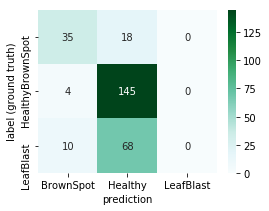

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 2	TRAIN	Loss: 0.63	Correct: 1555/2510(61.95%)
		VALID.:	Loss: 0.78	Correct: 179/280(63.93%)
----------------------------------------


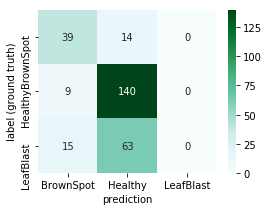

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 3	TRAIN	Loss: 0.83	Correct: 1595/2510(63.55%)
		VALID.:	Loss: 0.87	Correct: 181/280(64.64%)
----------------------------------------


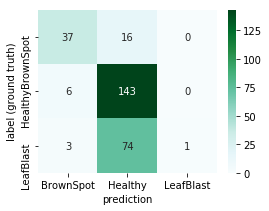

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 4	TRAIN	Loss: 0.78	Correct: 1548/2510(61.67%)
		VALID.:	Loss: 0.8	Correct: 180/280(64.29%)
----------------------------------------


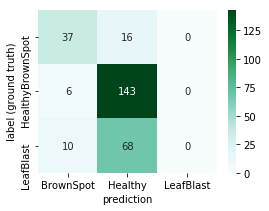

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 5	TRAIN	Loss: 0.76	Correct: 1571/2510(62.59%)
		VALID.:	Loss: 0.79	Correct: 180/280(64.29%)
----------------------------------------


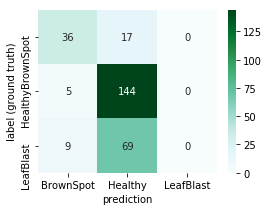

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 6	TRAIN	Loss: 0.61	Correct: 1573/2510(62.67%)
		VALID.:	Loss: 0.76	Correct: 177/280(63.21%)
----------------------------------------


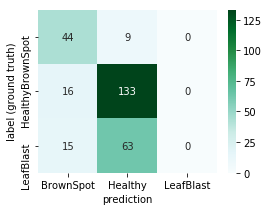

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 7	TRAIN	Loss: 0.52	Correct: 1584/2510(63.11%)
		VALID.:	Loss: 0.87	Correct: 175/280(62.5%)
----------------------------------------


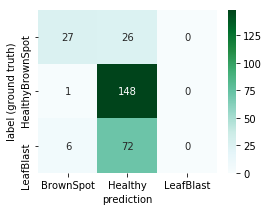

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 8	TRAIN	Loss: 0.66	Correct: 1584/2510(63.11%)
		VALID.:	Loss: 0.79	Correct: 177/280(63.21%)
----------------------------------------


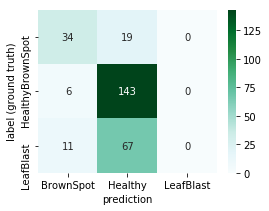

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 9	TRAIN	Loss: 0.9	Correct: 1569/2510(62.51%)
		VALID.:	Loss: 0.72	Correct: 180/280(64.29%)
----------------------------------------


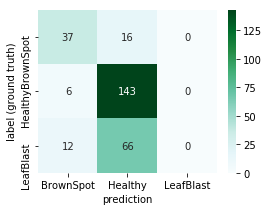

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 10	TRAIN	Loss: 0.74	Correct: 1582/2510(63.03%)
		VALID.:	Loss: 0.82	Correct: 178/280(63.57%)
----------------------------------------


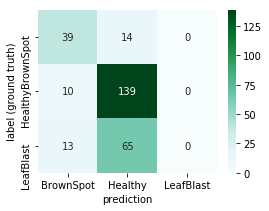

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 11	TRAIN	Loss: 1.14	Correct: 1588/2510(63.27%)
		VALID.:	Loss: 0.79	Correct: 179/280(63.93%)
----------------------------------------


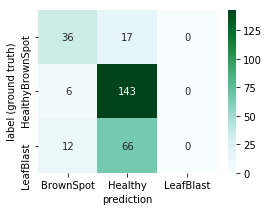

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 12	TRAIN	Loss: 0.58	Correct: 1598/2510(63.67%)
		VALID.:	Loss: 0.75	Correct: 177/280(63.21%)
----------------------------------------


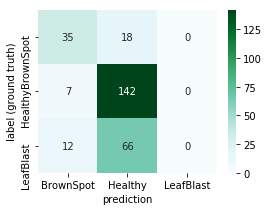

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 13	TRAIN	Loss: 0.76	Correct: 1546/2510(61.59%)
		VALID.:	Loss: 0.92	Correct: 171/280(61.07%)
----------------------------------------


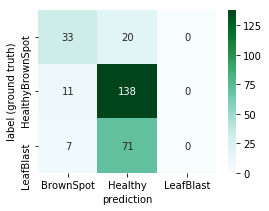

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 14	TRAIN	Loss: 1.51	Correct: 1522/2510(60.64%)
		VALID.:	Loss: 0.99	Correct: 166/280(59.29%)
----------------------------------------


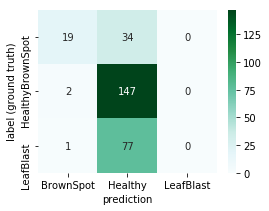

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 15	TRAIN	Loss: 0.66	Correct: 1527/2510(60.84%)
		VALID.:	Loss: 0.98	Correct: 171/280(61.07%)
----------------------------------------


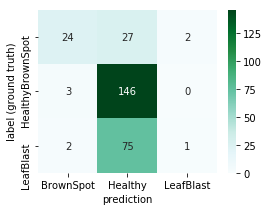

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 16	TRAIN	Loss: 0.91	Correct: 1552/2510(61.83%)
		VALID.:	Loss: 0.8	Correct: 182/280(65.0%)
----------------------------------------


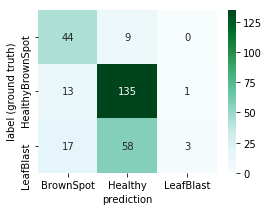

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 17	TRAIN	Loss: 0.85	Correct: 1572/2510(62.63%)
		VALID.:	Loss: 0.71	Correct: 182/280(65.0%)
----------------------------------------


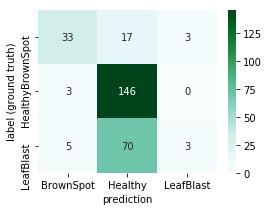

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 18	TRAIN	Loss: 0.87	Correct: 1556/2510(61.99%)
		VALID.:	Loss: 0.79	Correct: 174/280(62.14%)
----------------------------------------


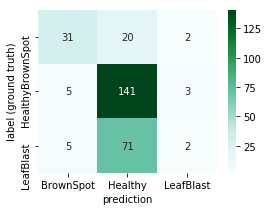

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 19	TRAIN	Loss: 0.63	Correct: 1573/2510(62.67%)
		VALID.:	Loss: 1.07	Correct: 182/280(65.0%)
----------------------------------------


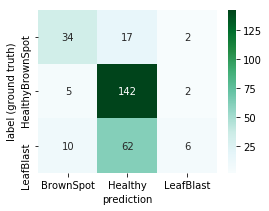

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 20	TRAIN	Loss: 1.13	Correct: 1563/2510(62.27%)
		VALID.:	Loss: 0.85	Correct: 183/280(65.36%)
----------------------------------------


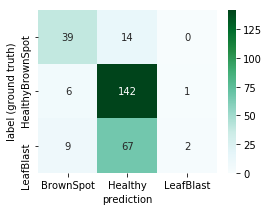

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 21	TRAIN	Loss: 0.9	Correct: 1616/2510(64.38%)
		VALID.:	Loss: 0.86	Correct: 185/280(66.07%)
----------------------------------------


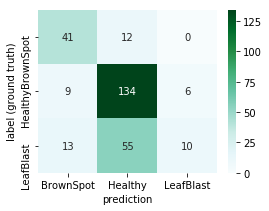

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 22	TRAIN	Loss: 0.54	Correct: 1571/2510(62.59%)
		VALID.:	Loss: 0.85	Correct: 170/280(60.71%)
----------------------------------------


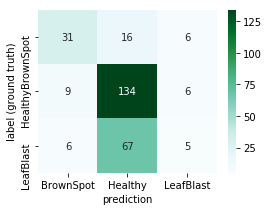

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 23	TRAIN	Loss: 0.86	Correct: 1599/2510(63.71%)
		VALID.:	Loss: 0.66	Correct: 186/280(66.43%)
----------------------------------------


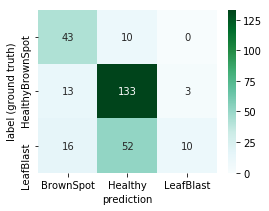

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 24	TRAIN	Loss: 0.9	Correct: 1642/2510(65.42%)
		VALID.:	Loss: 0.81	Correct: 190/280(67.86%)
----------------------------------------


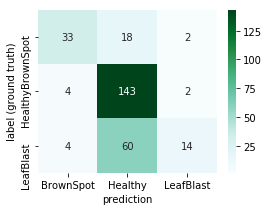

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 25	TRAIN	Loss: 0.56	Correct: 1630/2510(64.94%)
		VALID.:	Loss: 0.82	Correct: 195/280(69.64%)
----------------------------------------


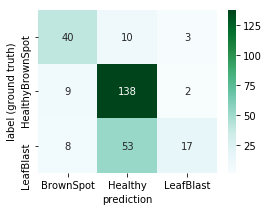

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 26	TRAIN	Loss: 1.02	Correct: 1629/2510(64.9%)
		VALID.:	Loss: 0.69	Correct: 180/280(64.29%)
----------------------------------------


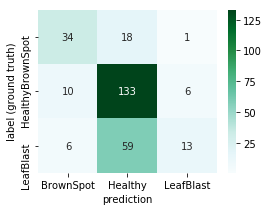

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 27	TRAIN	Loss: 0.78	Correct: 1660/2510(66.14%)
		VALID.:	Loss: 0.74	Correct: 194/280(69.29%)
----------------------------------------


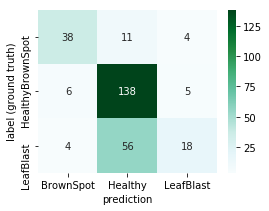

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 28	TRAIN	Loss: 0.69	Correct: 1643/2510(65.46%)
		VALID.:	Loss: 0.68	Correct: 197/280(70.36%)
----------------------------------------


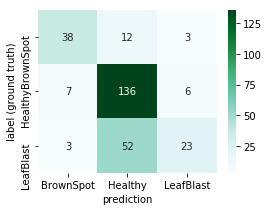

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 29	TRAIN	Loss: 0.63	Correct: 1664/2510(66.29%)
		VALID.:	Loss: 0.79	Correct: 192/280(68.57%)
----------------------------------------


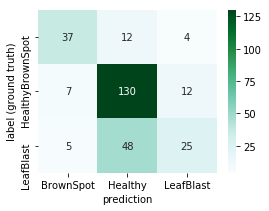

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 30	TRAIN	Loss: 0.78	Correct: 1663/2510(66.25%)
		VALID.:	Loss: 0.79	Correct: 201/280(71.79%)
----------------------------------------


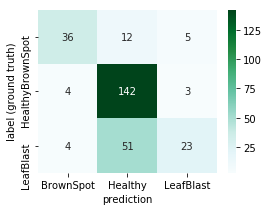

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 31	TRAIN	Loss: 0.76	Correct: 1683/2510(67.05%)
		VALID.:	Loss: 0.65	Correct: 203/280(72.5%)
----------------------------------------


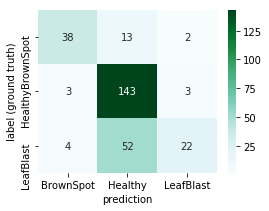

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 32	TRAIN	Loss: 0.74	Correct: 1672/2510(66.61%)
		VALID.:	Loss: 0.8	Correct: 203/280(72.5%)
----------------------------------------


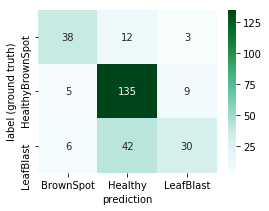

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 33	TRAIN	Loss: 1.06	Correct: 1679/2510(66.89%)
		VALID.:	Loss: 1.11	Correct: 192/280(68.57%)
----------------------------------------


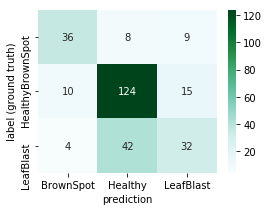

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 34	TRAIN	Loss: 0.76	Correct: 1646/2510(65.58%)
		VALID.:	Loss: 0.78	Correct: 184/280(65.71%)
----------------------------------------


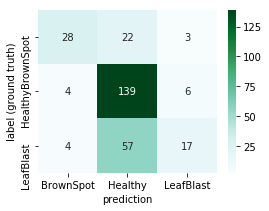

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 35	TRAIN	Loss: 1.04	Correct: 1615/2510(64.34%)
		VALID.:	Loss: 0.86	Correct: 178/280(63.57%)
----------------------------------------


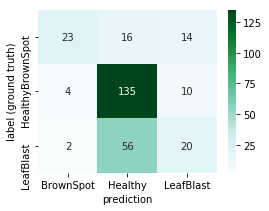

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 36	TRAIN	Loss: 0.58	Correct: 1644/2510(65.5%)
		VALID.:	Loss: 0.71	Correct: 190/280(67.86%)
----------------------------------------


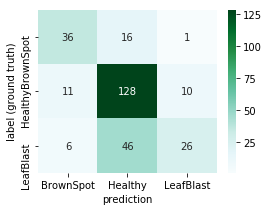

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 37	TRAIN	Loss: 0.84	Correct: 1674/2510(66.69%)
		VALID.:	Loss: 0.78	Correct: 188/280(67.14%)
----------------------------------------


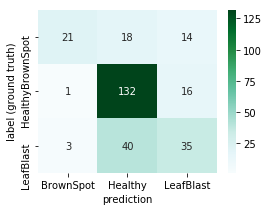

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 38	TRAIN	Loss: 1.0	Correct: 1688/2510(67.25%)
		VALID.:	Loss: 0.75	Correct: 193/280(68.93%)
----------------------------------------


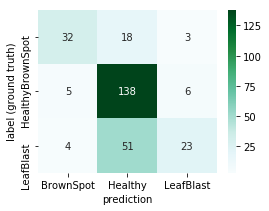

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 39	TRAIN	Loss: 0.77	Correct: 1672/2510(66.61%)
		VALID.:	Loss: 0.73	Correct: 198/280(70.71%)
----------------------------------------


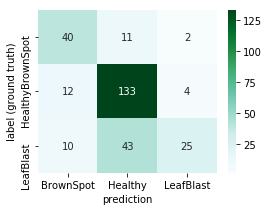

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 40	TRAIN	Loss: 0.82	Correct: 1703/2510(67.85%)
		VALID.:	Loss: 0.82	Correct: 203/280(72.5%)
----------------------------------------


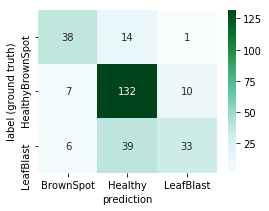

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 41	TRAIN	Loss: 0.88	Correct: 1710/2510(68.13%)
		VALID.:	Loss: 0.63	Correct: 216/280(77.14%)
----------------------------------------


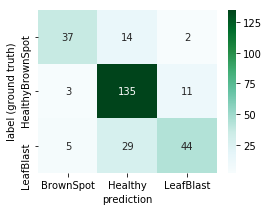

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 42	TRAIN	Loss: 0.96	Correct: 1739/2510(69.28%)
		VALID.:	Loss: 0.71	Correct: 202/280(72.14%)
----------------------------------------


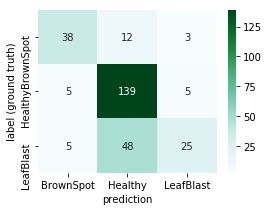

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 43	TRAIN	Loss: 0.76	Correct: 1740/2510(69.32%)
		VALID.:	Loss: 0.88	Correct: 208/280(74.29%)
----------------------------------------


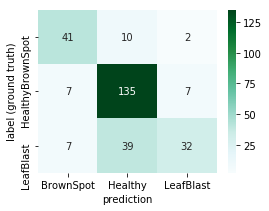

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 44	TRAIN	Loss: 0.88	Correct: 1753/2510(69.84%)
		VALID.:	Loss: 0.82	Correct: 196/280(70.0%)
----------------------------------------


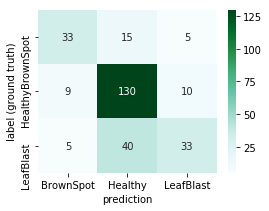

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 45	TRAIN	Loss: 1.09	Correct: 1724/2510(68.69%)
		VALID.:	Loss: 0.6	Correct: 201/280(71.79%)
----------------------------------------


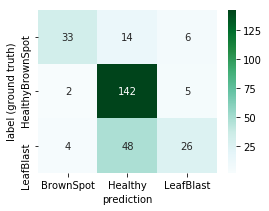

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 46	TRAIN	Loss: 0.47	Correct: 1726/2510(68.76%)
		VALID.:	Loss: 0.81	Correct: 198/280(70.71%)
----------------------------------------


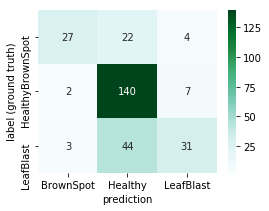

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 47	TRAIN	Loss: 0.78	Correct: 1713/2510(68.25%)
		VALID.:	Loss: 0.82	Correct: 194/280(69.29%)
----------------------------------------


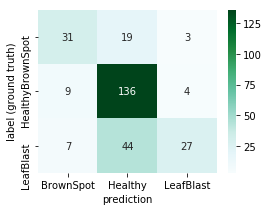

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 48	TRAIN	Loss: 1.3	Correct: 1724/2510(68.69%)
		VALID.:	Loss: 0.73	Correct: 198/280(70.71%)
----------------------------------------


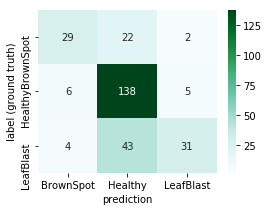

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 49	TRAIN	Loss: 0.7	Correct: 1751/2510(69.76%)
		VALID.:	Loss: 0.7	Correct: 205/280(73.21%)
----------------------------------------


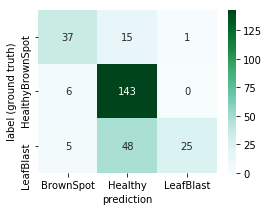

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 50	TRAIN	Loss: 0.9	Correct: 1754/2510(69.88%)
		VALID.:	Loss: 0.64	Correct: 206/280(73.57%)
----------------------------------------


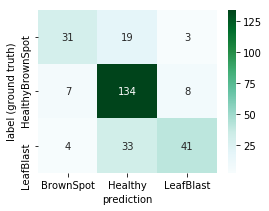

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 51	TRAIN	Loss: 1.02	Correct: 1799/2510(71.67%)
		VALID.:	Loss: 0.75	Correct: 212/280(75.71%)
----------------------------------------


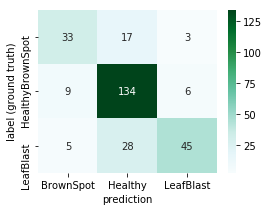

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 52	TRAIN	Loss: 0.5	Correct: 1787/2510(71.2%)
		VALID.:	Loss: 0.81	Correct: 210/280(75.0%)
----------------------------------------


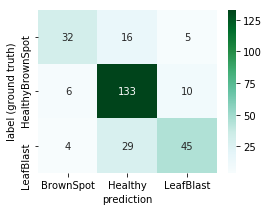

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 53	TRAIN	Loss: 0.63	Correct: 1778/2510(70.84%)
		VALID.:	Loss: 0.65	Correct: 222/280(79.29%)
----------------------------------------


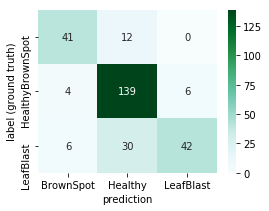

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 54	TRAIN	Loss: 0.66	Correct: 1795/2510(71.51%)
		VALID.:	Loss: 0.67	Correct: 213/280(76.07%)
----------------------------------------


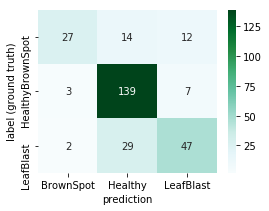

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 55	TRAIN	Loss: 0.85	Correct: 1788/2510(71.24%)
		VALID.:	Loss: 0.77	Correct: 205/280(73.21%)
----------------------------------------


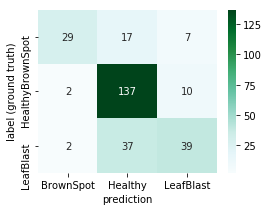

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 56	TRAIN	Loss: 0.7	Correct: 1781/2510(70.96%)
		VALID.:	Loss: 0.76	Correct: 210/280(75.0%)
----------------------------------------


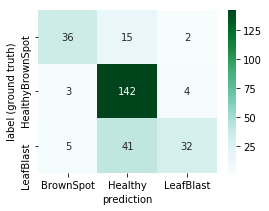

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 57	TRAIN	Loss: 0.77	Correct: 1790/2510(71.31%)
		VALID.:	Loss: 0.71	Correct: 215/280(76.79%)
----------------------------------------


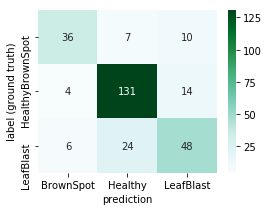

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 58	TRAIN	Loss: 0.56	Correct: 1826/2510(72.75%)
		VALID.:	Loss: 0.53	Correct: 220/280(78.57%)
----------------------------------------


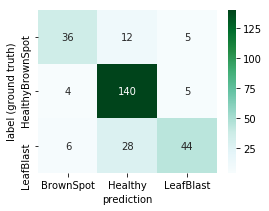

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 59	TRAIN	Loss: 0.52	Correct: 1746/2510(69.56%)
		VALID.:	Loss: 0.63	Correct: 215/280(76.79%)
----------------------------------------


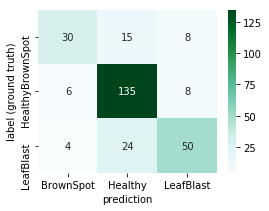

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 60	TRAIN	Loss: 0.42	Correct: 1792/2510(71.39%)
		VALID.:	Loss: 0.71	Correct: 215/280(76.79%)
----------------------------------------


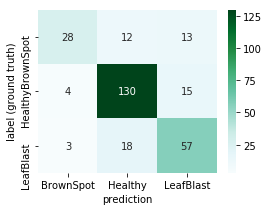

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 61	TRAIN	Loss: 0.64	Correct: 1781/2510(70.96%)
		VALID.:	Loss: 0.64	Correct: 224/280(80.0%)
----------------------------------------


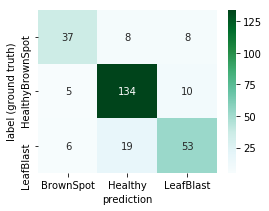

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 62	TRAIN	Loss: 0.74	Correct: 1824/2510(72.67%)
		VALID.:	Loss: 0.63	Correct: 207/280(73.93%)
----------------------------------------


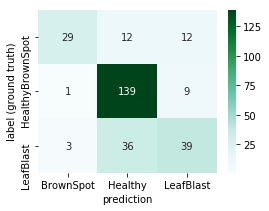

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 63	TRAIN	Loss: 0.35	Correct: 1836/2510(73.15%)
		VALID.:	Loss: 0.55	Correct: 229/280(81.79%)
----------------------------------------


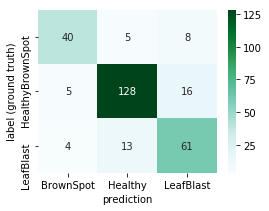

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 64	TRAIN	Loss: 0.89	Correct: 1820/2510(72.51%)
		VALID.:	Loss: 0.65	Correct: 225/280(80.36%)
----------------------------------------


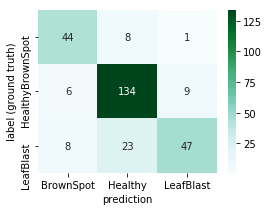

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 65	TRAIN	Loss: 0.6	Correct: 1832/2510(72.99%)
		VALID.:	Loss: 0.53	Correct: 216/280(77.14%)
----------------------------------------


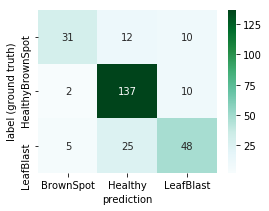

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 66	TRAIN	Loss: 0.83	Correct: 1852/2510(73.78%)
		VALID.:	Loss: 0.86	Correct: 212/280(75.71%)
----------------------------------------


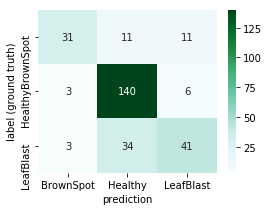

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 67	TRAIN	Loss: 0.42	Correct: 1813/2510(72.23%)
		VALID.:	Loss: 0.6	Correct: 211/280(75.36%)
----------------------------------------


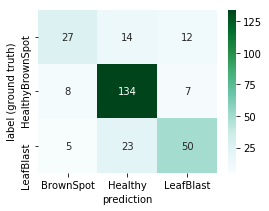

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 68	TRAIN	Loss: 1.09	Correct: 1841/2510(73.35%)
		VALID.:	Loss: 0.59	Correct: 214/280(76.43%)
----------------------------------------


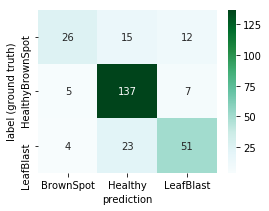

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 69	TRAIN	Loss: 1.17	Correct: 1857/2510(73.98%)
		VALID.:	Loss: 0.71	Correct: 216/280(77.14%)
----------------------------------------


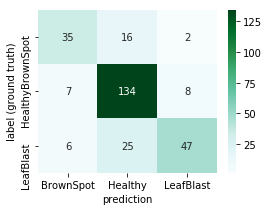

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 70	TRAIN	Loss: 0.74	Correct: 1850/2510(73.71%)
		VALID.:	Loss: 0.63	Correct: 224/280(80.0%)
----------------------------------------


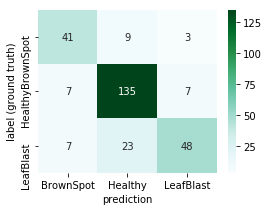

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 71	TRAIN	Loss: 1.03	Correct: 1893/2510(75.42%)
		VALID.:	Loss: 0.57	Correct: 219/280(78.21%)
----------------------------------------


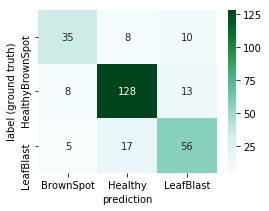

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 72	TRAIN	Loss: 0.47	Correct: 1853/2510(73.82%)
		VALID.:	Loss: 0.49	Correct: 221/280(78.93%)
----------------------------------------


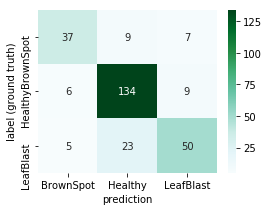

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 73	TRAIN	Loss: 0.52	Correct: 1855/2510(73.9%)
		VALID.:	Loss: 0.57	Correct: 225/280(80.36%)
----------------------------------------


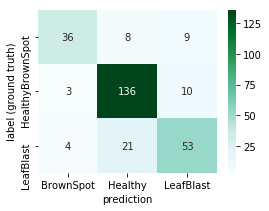

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 74	TRAIN	Loss: 0.78	Correct: 1814/2510(72.27%)
		VALID.:	Loss: 0.58	Correct: 223/280(79.64%)
----------------------------------------


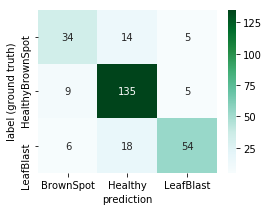

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 75	TRAIN	Loss: 0.66	Correct: 1832/2510(72.99%)
		VALID.:	Loss: 0.67	Correct: 221/280(78.93%)
----------------------------------------


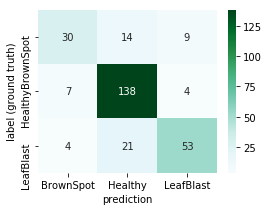

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 76	TRAIN	Loss: 0.46	Correct: 1824/2510(72.67%)
		VALID.:	Loss: 0.58	Correct: 225/280(80.36%)
----------------------------------------


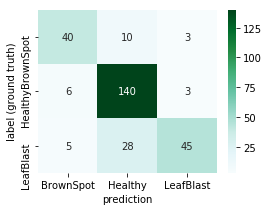

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 77	TRAIN	Loss: 1.01	Correct: 1866/2510(74.34%)
		VALID.:	Loss: 0.45	Correct: 231/280(82.5%)
----------------------------------------


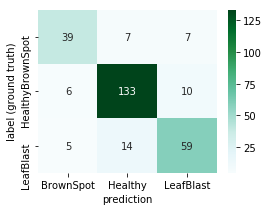

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 78	TRAIN	Loss: 0.64	Correct: 1823/2510(72.63%)
		VALID.:	Loss: 0.68	Correct: 211/280(75.36%)
----------------------------------------


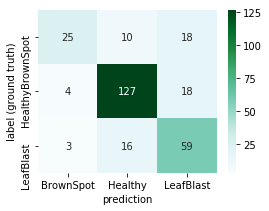

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 79	TRAIN	Loss: 0.19	Correct: 1846/2510(73.55%)
		VALID.:	Loss: 0.6	Correct: 215/280(76.79%)
----------------------------------------


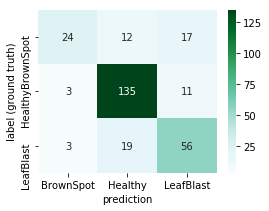

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 80	TRAIN	Loss: 0.6	Correct: 1817/2510(72.39%)
		VALID.:	Loss: 0.59	Correct: 221/280(78.93%)
----------------------------------------


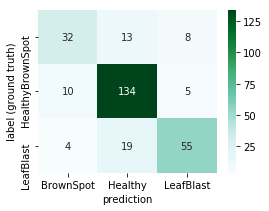

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 81	TRAIN	Loss: 0.19	Correct: 1868/2510(74.42%)
		VALID.:	Loss: 0.41	Correct: 227/280(81.07%)
----------------------------------------


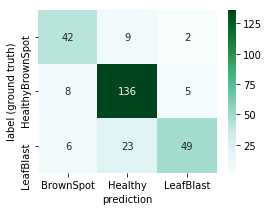

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 82	TRAIN	Loss: 1.24	Correct: 1870/2510(74.5%)
		VALID.:	Loss: 0.57	Correct: 231/280(82.5%)
----------------------------------------


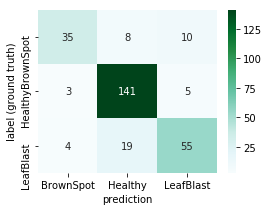

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 83	TRAIN	Loss: 0.41	Correct: 1816/2510(72.35%)
		VALID.:	Loss: 0.52	Correct: 227/280(81.07%)
----------------------------------------


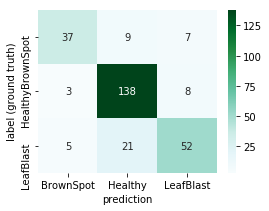

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 84	TRAIN	Loss: 0.96	Correct: 1882/2510(74.98%)
		VALID.:	Loss: 0.58	Correct: 227/280(81.07%)
----------------------------------------


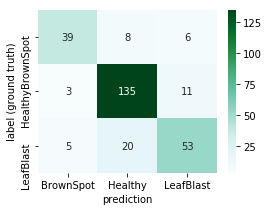

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 85	TRAIN	Loss: 0.28	Correct: 1858/2510(74.02%)
		VALID.:	Loss: 0.57	Correct: 230/280(82.14%)
----------------------------------------


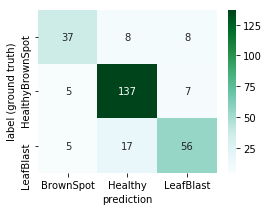

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 86	TRAIN	Loss: 0.66	Correct: 1855/2510(73.9%)
		VALID.:	Loss: 0.62	Correct: 221/280(78.93%)
----------------------------------------


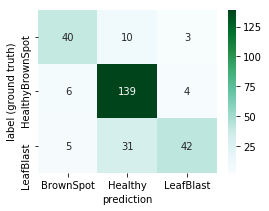

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 87	TRAIN	Loss: 0.85	Correct: 1880/2510(74.9%)
		VALID.:	Loss: 0.55	Correct: 233/280(83.21%)
----------------------------------------


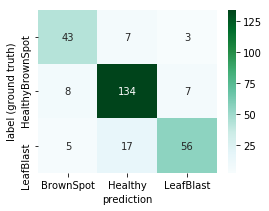

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 88	TRAIN	Loss: 0.79	Correct: 1897/2510(75.58%)
		VALID.:	Loss: 0.55	Correct: 232/280(82.86%)
----------------------------------------


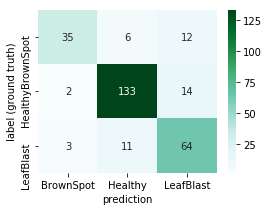

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 89	TRAIN	Loss: 0.46	Correct: 1876/2510(74.74%)
		VALID.:	Loss: 0.57	Correct: 228/280(81.43%)
----------------------------------------


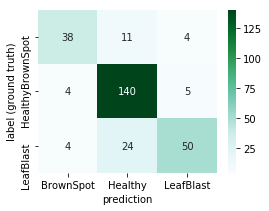

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 90	TRAIN	Loss: 0.6	Correct: 1885/2510(75.1%)
		VALID.:	Loss: 0.46	Correct: 233/280(83.21%)
----------------------------------------


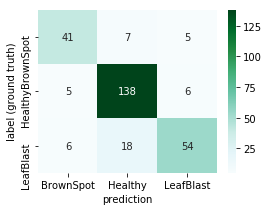

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 91	TRAIN	Loss: 0.63	Correct: 1869/2510(74.46%)
		VALID.:	Loss: 0.54	Correct: 230/280(82.14%)
----------------------------------------


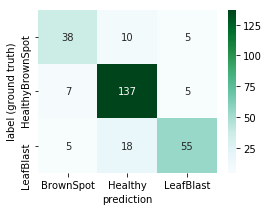

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 92	TRAIN	Loss: 0.49	Correct: 1809/2510(72.07%)
		VALID.:	Loss: 0.6	Correct: 222/280(79.29%)
----------------------------------------


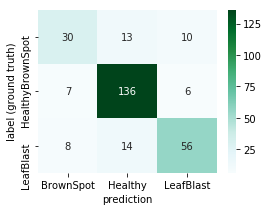

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 93	TRAIN	Loss: 0.57	Correct: 1821/2510(72.55%)
		VALID.:	Loss: 0.77	Correct: 221/280(78.93%)
----------------------------------------


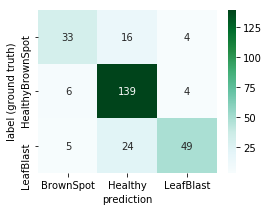

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 94	TRAIN	Loss: 0.32	Correct: 1859/2510(74.06%)
		VALID.:	Loss: 0.59	Correct: 227/280(81.07%)
----------------------------------------


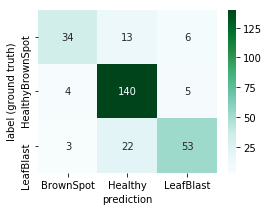

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 95	TRAIN	Loss: 0.42	Correct: 1862/2510(74.18%)
		VALID.:	Loss: 0.59	Correct: 229/280(81.79%)
----------------------------------------


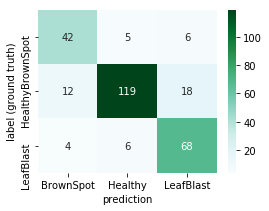

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 96	TRAIN	Loss: 0.87	Correct: 1876/2510(74.74%)
		VALID.:	Loss: 0.48	Correct: 228/280(81.43%)
----------------------------------------


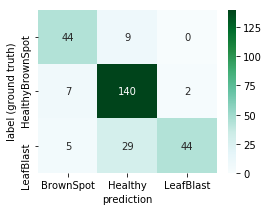

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 97	TRAIN	Loss: 0.5	Correct: 1862/2510(74.18%)
		VALID.:	Loss: 0.61	Correct: 217/280(77.5%)
----------------------------------------


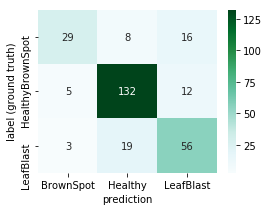

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 98	TRAIN	Loss: 0.75	Correct: 1881/2510(74.94%)
		VALID.:	Loss: 0.61	Correct: 203/280(72.5%)
----------------------------------------


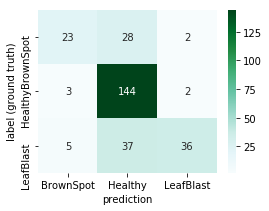

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 99	TRAIN	Loss: 0.39	Correct: 1758/2510(70.04%)
		VALID.:	Loss: 0.54	Correct: 223/280(79.64%)
----------------------------------------


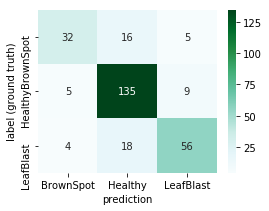

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 100	TRAIN	Loss: 0.68	Correct: 1807/2510(71.99%)
		VALID.:	Loss: 0.64	Correct: 225/280(80.36%)
----------------------------------------


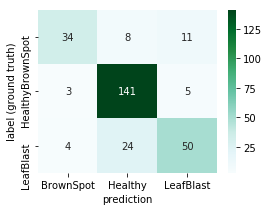

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 101	TRAIN	Loss: 0.79	Correct: 1857/2510(73.98%)
		VALID.:	Loss: 0.53	Correct: 232/280(82.86%)
----------------------------------------


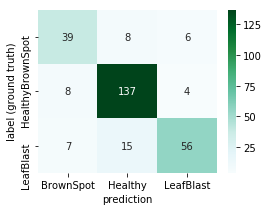

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 102	TRAIN	Loss: 0.99	Correct: 1929/2510(76.85%)
		VALID.:	Loss: 0.58	Correct: 230/280(82.14%)
----------------------------------------


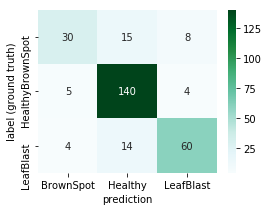

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 103	TRAIN	Loss: 0.74	Correct: 1880/2510(74.9%)
		VALID.:	Loss: 0.48	Correct: 231/280(82.5%)
----------------------------------------


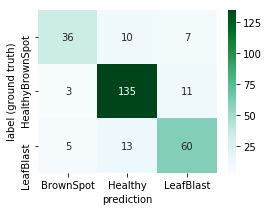

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 104	TRAIN	Loss: 0.34	Correct: 1850/2510(73.71%)
		VALID.:	Loss: 0.53	Correct: 226/280(80.71%)
----------------------------------------


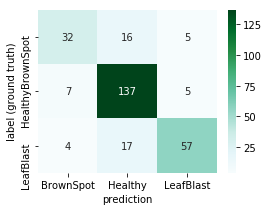

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 105	TRAIN	Loss: 0.85	Correct: 1832/2510(72.99%)
		VALID.:	Loss: 0.54	Correct: 222/280(79.29%)
----------------------------------------


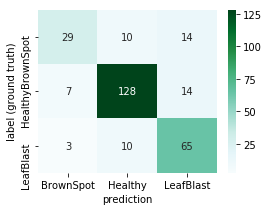

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 106	TRAIN	Loss: 0.64	Correct: 1860/2510(74.1%)
		VALID.:	Loss: 0.6	Correct: 230/280(82.14%)
----------------------------------------


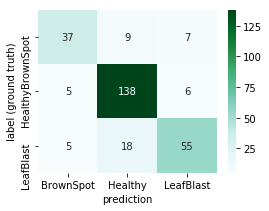

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 107	TRAIN	Loss: 1.2	Correct: 1927/2510(76.77%)
		VALID.:	Loss: 0.65	Correct: 226/280(80.71%)
----------------------------------------


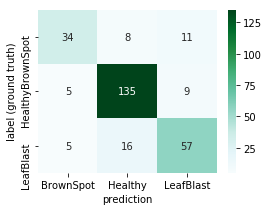

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 108	TRAIN	Loss: 0.74	Correct: 1891/2510(75.34%)
		VALID.:	Loss: 0.48	Correct: 233/280(83.21%)
----------------------------------------


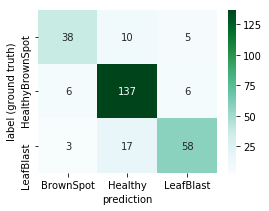

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 109	TRAIN	Loss: 0.44	Correct: 1876/2510(74.74%)
		VALID.:	Loss: 0.65	Correct: 224/280(80.0%)
----------------------------------------


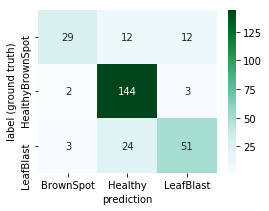

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 110	TRAIN	Loss: 0.61	Correct: 1897/2510(75.58%)
		VALID.:	Loss: 0.44	Correct: 223/280(79.64%)
----------------------------------------


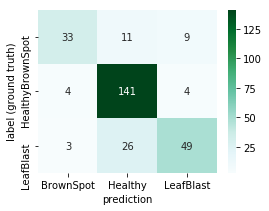

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 111	TRAIN	Loss: 0.68	Correct: 1935/2510(77.09%)
		VALID.:	Loss: 0.4	Correct: 232/280(82.86%)
----------------------------------------


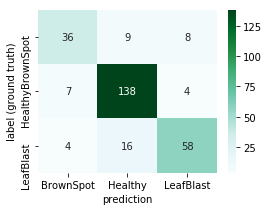

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 112	TRAIN	Loss: 0.58	Correct: 1904/2510(75.86%)
		VALID.:	Loss: 0.49	Correct: 238/280(85.0%)
----------------------------------------


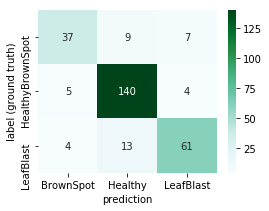

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 113	TRAIN	Loss: 0.31	Correct: 1908/2510(76.02%)
		VALID.:	Loss: 0.43	Correct: 235/280(83.93%)
----------------------------------------


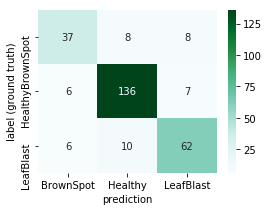

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 114	TRAIN	Loss: 0.8	Correct: 1921/2510(76.53%)
		VALID.:	Loss: 0.57	Correct: 229/280(81.79%)
----------------------------------------


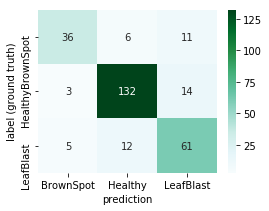

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 115	TRAIN	Loss: 0.41	Correct: 1915/2510(76.29%)
		VALID.:	Loss: 0.51	Correct: 230/280(82.14%)
----------------------------------------


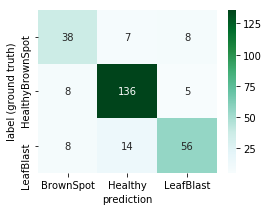

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 116	TRAIN	Loss: 0.64	Correct: 1915/2510(76.29%)
		VALID.:	Loss: 0.65	Correct: 237/280(84.64%)
----------------------------------------


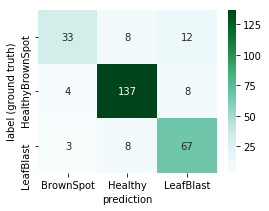

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 117	TRAIN	Loss: 0.8	Correct: 1909/2510(76.06%)
		VALID.:	Loss: 0.63	Correct: 232/280(82.86%)
----------------------------------------


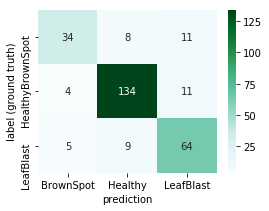

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 118	TRAIN	Loss: 0.42	Correct: 1914/2510(76.25%)
		VALID.:	Loss: 0.5	Correct: 243/280(86.79%)
----------------------------------------


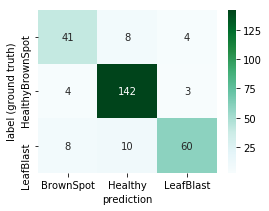

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 119	TRAIN	Loss: 0.48	Correct: 1918/2510(76.41%)
		VALID.:	Loss: 0.58	Correct: 226/280(80.71%)
----------------------------------------


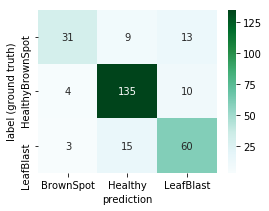

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 120	TRAIN	Loss: 0.64	Correct: 1912/2510(76.18%)
		VALID.:	Loss: 0.36	Correct: 242/280(86.43%)
----------------------------------------


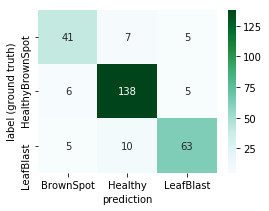

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 121	TRAIN	Loss: 0.72	Correct: 1898/2510(75.62%)
		VALID.:	Loss: 0.74	Correct: 227/280(81.07%)
----------------------------------------


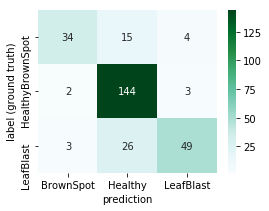

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 122	TRAIN	Loss: 0.69	Correct: 1924/2510(76.65%)
		VALID.:	Loss: 0.61	Correct: 233/280(83.21%)
----------------------------------------


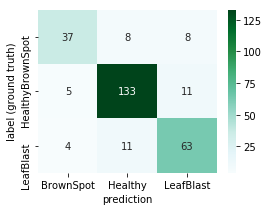

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 123	TRAIN	Loss: 1.05	Correct: 1891/2510(75.34%)
		VALID.:	Loss: 0.49	Correct: 235/280(83.93%)
----------------------------------------


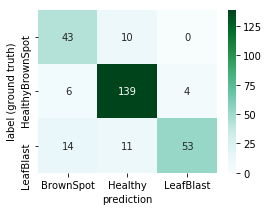

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 124	TRAIN	Loss: 1.02	Correct: 1950/2510(77.69%)
		VALID.:	Loss: 0.41	Correct: 237/280(84.64%)
----------------------------------------


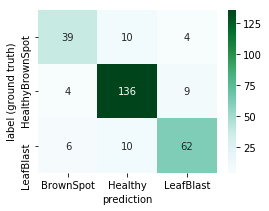

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 125	TRAIN	Loss: 0.82	Correct: 1915/2510(76.29%)
		VALID.:	Loss: 0.59	Correct: 233/280(83.21%)
----------------------------------------


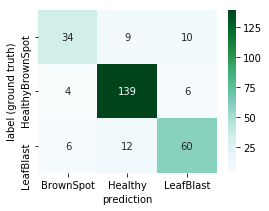

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 126	TRAIN	Loss: 0.74	Correct: 1909/2510(76.06%)
		VALID.:	Loss: 0.4	Correct: 230/280(82.14%)
----------------------------------------


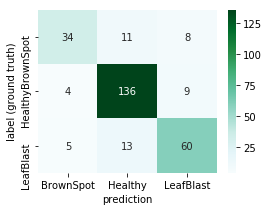

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 127	TRAIN	Loss: 0.74	Correct: 1878/2510(74.82%)
		VALID.:	Loss: 0.51	Correct: 237/280(84.64%)
----------------------------------------


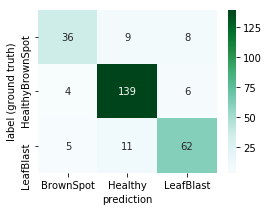

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 128	TRAIN	Loss: 0.73	Correct: 1893/2510(75.42%)
		VALID.:	Loss: 0.36	Correct: 236/280(84.29%)
----------------------------------------


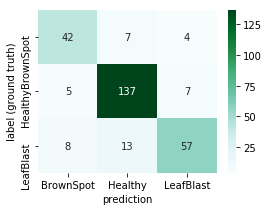

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 129	TRAIN	Loss: 0.37	Correct: 1908/2510(76.02%)
		VALID.:	Loss: 0.43	Correct: 244/280(87.14%)
----------------------------------------


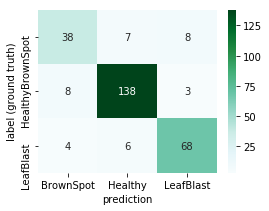

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 130	TRAIN	Loss: 0.32	Correct: 1894/2510(75.46%)
		VALID.:	Loss: 0.54	Correct: 233/280(83.21%)
----------------------------------------


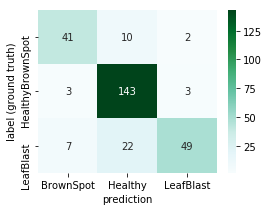

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 131	TRAIN	Loss: 0.48	Correct: 1925/2510(76.69%)
		VALID.:	Loss: 0.67	Correct: 238/280(85.0%)
----------------------------------------


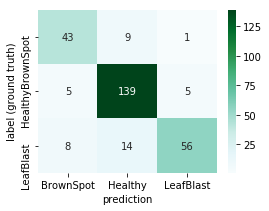

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 132	TRAIN	Loss: 1.84	Correct: 1930/2510(76.89%)
		VALID.:	Loss: 0.52	Correct: 236/280(84.29%)
----------------------------------------


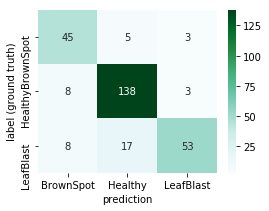

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 133	TRAIN	Loss: 0.41	Correct: 1922/2510(76.57%)
		VALID.:	Loss: 0.48	Correct: 237/280(84.64%)
----------------------------------------


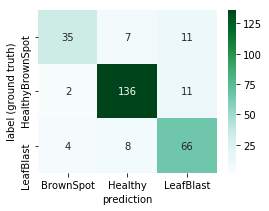

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 134	TRAIN	Loss: 0.45	Correct: 1914/2510(76.25%)
		VALID.:	Loss: 0.36	Correct: 234/280(83.57%)
----------------------------------------


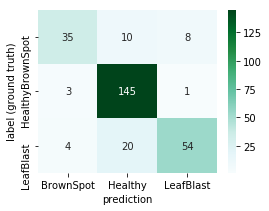

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 135	TRAIN	Loss: 0.58	Correct: 1929/2510(76.85%)
		VALID.:	Loss: 0.35	Correct: 244/280(87.14%)
----------------------------------------


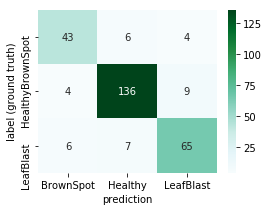

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 136	TRAIN	Loss: 0.71	Correct: 1875/2510(74.7%)
		VALID.:	Loss: 0.55	Correct: 217/280(77.5%)
----------------------------------------


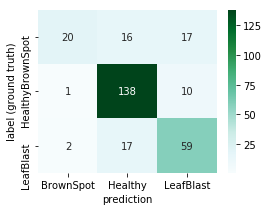

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 137	TRAIN	Loss: 0.82	Correct: 1842/2510(73.39%)
		VALID.:	Loss: 0.64	Correct: 228/280(81.43%)
----------------------------------------


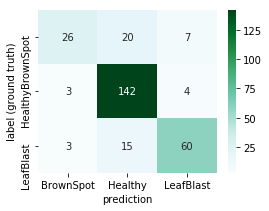

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 138	TRAIN	Loss: 1.01	Correct: 1827/2510(72.79%)
		VALID.:	Loss: 0.58	Correct: 220/280(78.57%)
----------------------------------------


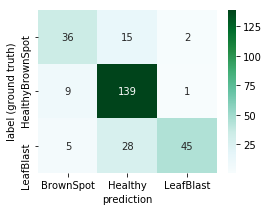

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 139	TRAIN	Loss: 0.75	Correct: 1855/2510(73.9%)
		VALID.:	Loss: 0.59	Correct: 225/280(80.36%)
----------------------------------------


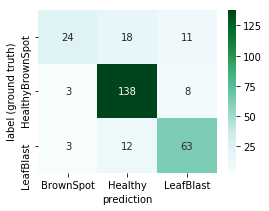

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 140	TRAIN	Loss: 0.59	Correct: 1864/2510(74.26%)
		VALID.:	Loss: 0.6	Correct: 228/280(81.43%)
----------------------------------------


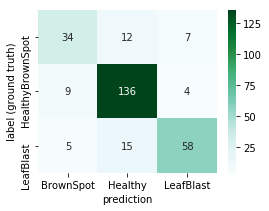

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 141	TRAIN	Loss: 0.88	Correct: 1873/2510(74.62%)
		VALID.:	Loss: 0.56	Correct: 233/280(83.21%)
----------------------------------------


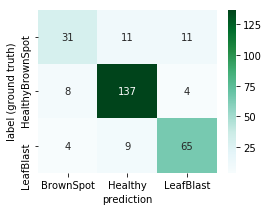

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 142	TRAIN	Loss: 0.41	Correct: 1870/2510(74.5%)
		VALID.:	Loss: 0.48	Correct: 236/280(84.29%)
----------------------------------------


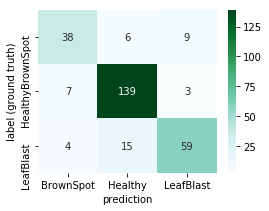

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 143	TRAIN	Loss: 0.46	Correct: 1919/2510(76.45%)
		VALID.:	Loss: 0.43	Correct: 235/280(83.93%)
----------------------------------------


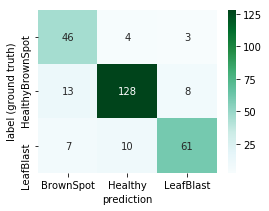

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 144	TRAIN	Loss: 0.38	Correct: 1910/2510(76.1%)
		VALID.:	Loss: 0.41	Correct: 245/280(87.5%)
----------------------------------------


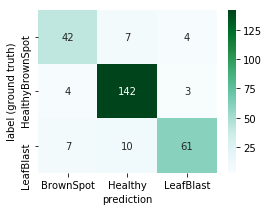

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 145	TRAIN	Loss: 0.46	Correct: 1892/2510(75.38%)
		VALID.:	Loss: 0.36	Correct: 249/280(88.93%)
----------------------------------------


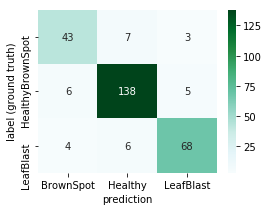

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 146	TRAIN	Loss: 0.59	Correct: 1887/2510(75.18%)
		VALID.:	Loss: 0.56	Correct: 221/280(78.93%)
----------------------------------------


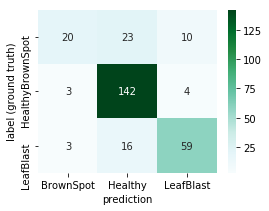

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 147	TRAIN	Loss: 0.64	Correct: 1928/2510(76.81%)
		VALID.:	Loss: 0.45	Correct: 240/280(85.71%)
----------------------------------------


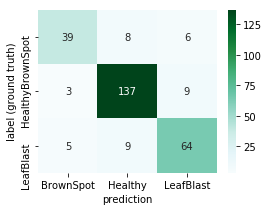

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 148	TRAIN	Loss: 0.85	Correct: 1907/2510(75.98%)
		VALID.:	Loss: 0.54	Correct: 226/280(80.71%)
----------------------------------------


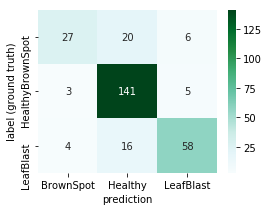

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 149	TRAIN	Loss: 0.48	Correct: 1842/2510(73.39%)
		VALID.:	Loss: 0.58	Correct: 237/280(84.64%)
----------------------------------------


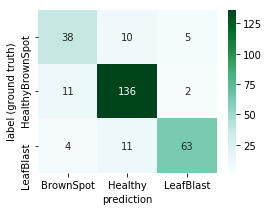

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 150	TRAIN	Loss: 0.87	Correct: 1887/2510(75.18%)
		VALID.:	Loss: 0.64	Correct: 230/280(82.14%)
----------------------------------------


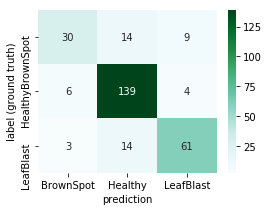

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 151	TRAIN	Loss: 0.45	Correct: 1899/2510(75.66%)
		VALID.:	Loss: 0.44	Correct: 238/280(85.0%)
----------------------------------------


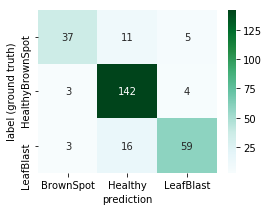

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 152	TRAIN	Loss: 0.67	Correct: 1900/2510(75.7%)
		VALID.:	Loss: 0.41	Correct: 230/280(82.14%)
----------------------------------------


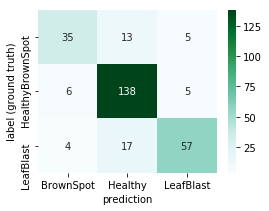

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 153	TRAIN	Loss: 0.93	Correct: 1912/2510(76.18%)
		VALID.:	Loss: 0.72	Correct: 213/280(76.07%)
----------------------------------------


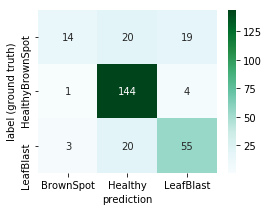

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 154	TRAIN	Loss: 0.16	Correct: 1937/2510(77.17%)
		VALID.:	Loss: 0.48	Correct: 239/280(85.36%)
----------------------------------------


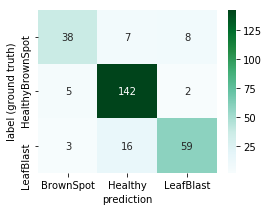

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 155	TRAIN	Loss: 0.52	Correct: 1901/2510(75.74%)
		VALID.:	Loss: 0.45	Correct: 238/280(85.0%)
----------------------------------------


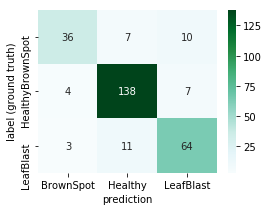

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 156	TRAIN	Loss: 0.83	Correct: 1944/2510(77.45%)
		VALID.:	Loss: 0.51	Correct: 238/280(85.0%)
----------------------------------------


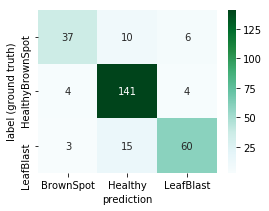

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 157	TRAIN	Loss: 0.39	Correct: 1937/2510(77.17%)
		VALID.:	Loss: 0.46	Correct: 244/280(87.14%)
----------------------------------------


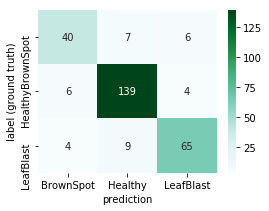

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 158	TRAIN	Loss: 0.39	Correct: 1885/2510(75.1%)
		VALID.:	Loss: 0.53	Correct: 230/280(82.14%)
----------------------------------------


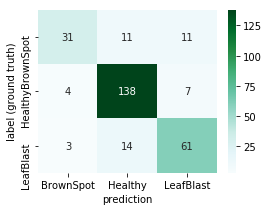

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 159	TRAIN	Loss: 0.27	Correct: 1881/2510(74.94%)
		VALID.:	Loss: 0.48	Correct: 236/280(84.29%)
----------------------------------------


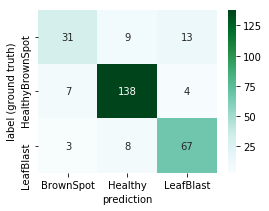

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 160	TRAIN	Loss: 1.09	Correct: 1860/2510(74.1%)
		VALID.:	Loss: 0.47	Correct: 233/280(83.21%)
----------------------------------------


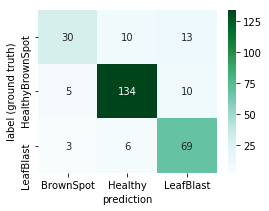

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 161	TRAIN	Loss: 0.91	Correct: 1865/2510(74.3%)
		VALID.:	Loss: 0.52	Correct: 233/280(83.21%)
----------------------------------------


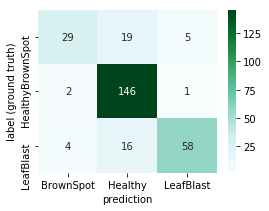

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 162	TRAIN	Loss: 0.48	Correct: 1901/2510(75.74%)
		VALID.:	Loss: 0.53	Correct: 240/280(85.71%)
----------------------------------------


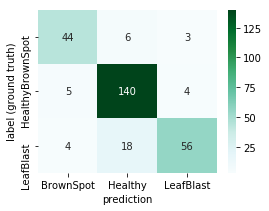

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 163	TRAIN	Loss: 0.44	Correct: 1912/2510(76.18%)
		VALID.:	Loss: 0.61	Correct: 241/280(86.07%)
----------------------------------------


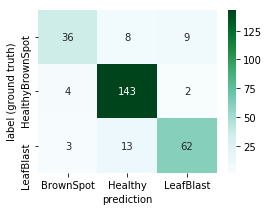

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 164	TRAIN	Loss: 1.15	Correct: 1917/2510(76.37%)
		VALID.:	Loss: 0.44	Correct: 243/280(86.79%)
----------------------------------------


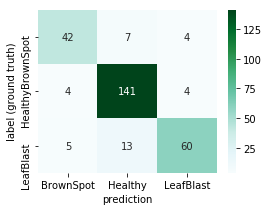

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 165	TRAIN	Loss: 0.37	Correct: 1936/2510(77.13%)
		VALID.:	Loss: 0.61	Correct: 245/280(87.5%)
----------------------------------------


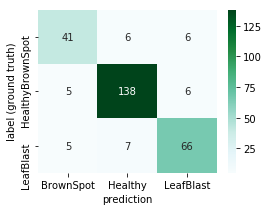

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 166	TRAIN	Loss: 0.45	Correct: 1898/2510(75.62%)
		VALID.:	Loss: 0.36	Correct: 244/280(87.14%)
----------------------------------------


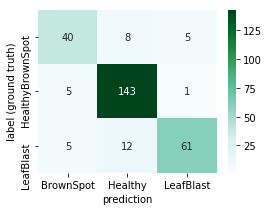

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 167	TRAIN	Loss: 0.57	Correct: 1924/2510(76.65%)
		VALID.:	Loss: 0.48	Correct: 241/280(86.07%)
----------------------------------------


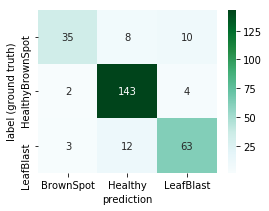

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 168	TRAIN	Loss: 0.4	Correct: 1950/2510(77.69%)
		VALID.:	Loss: 0.42	Correct: 239/280(85.36%)
----------------------------------------


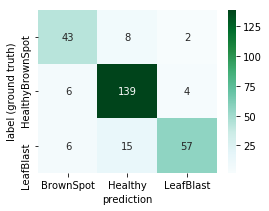

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 169	TRAIN	Loss: 0.35	Correct: 1918/2510(76.41%)
		VALID.:	Loss: 0.42	Correct: 234/280(83.57%)
----------------------------------------


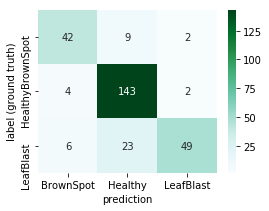

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 170	TRAIN	Loss: 1.08	Correct: 1916/2510(76.33%)
		VALID.:	Loss: 0.48	Correct: 242/280(86.43%)
----------------------------------------


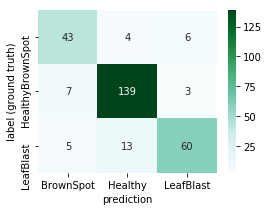

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 171	TRAIN	Loss: 0.55	Correct: 1924/2510(76.65%)
		VALID.:	Loss: 0.49	Correct: 243/280(86.79%)
----------------------------------------


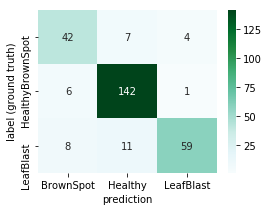

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 172	TRAIN	Loss: 0.63	Correct: 1932/2510(76.97%)
		VALID.:	Loss: 0.5	Correct: 236/280(84.29%)
----------------------------------------


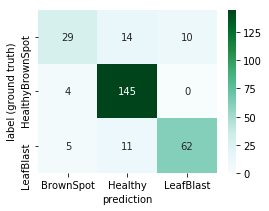

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 173	TRAIN	Loss: 0.29	Correct: 1895/2510(75.5%)
		VALID.:	Loss: 0.45	Correct: 237/280(84.64%)
----------------------------------------


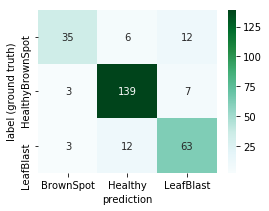

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 174	TRAIN	Loss: 1.09	Correct: 1926/2510(76.73%)
		VALID.:	Loss: 0.61	Correct: 224/280(80.0%)
----------------------------------------


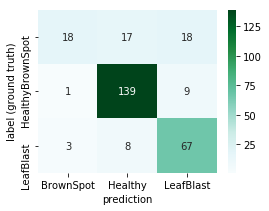

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 175	TRAIN	Loss: 0.64	Correct: 1936/2510(77.13%)
		VALID.:	Loss: 0.39	Correct: 244/280(87.14%)
----------------------------------------


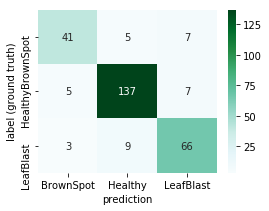

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 176	TRAIN	Loss: 0.66	Correct: 1891/2510(75.34%)
		VALID.:	Loss: 0.43	Correct: 246/280(87.86%)
----------------------------------------


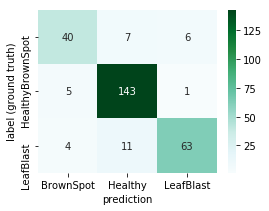

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 177	TRAIN	Loss: 0.49	Correct: 1971/2510(78.53%)
		VALID.:	Loss: 0.45	Correct: 249/280(88.93%)
----------------------------------------


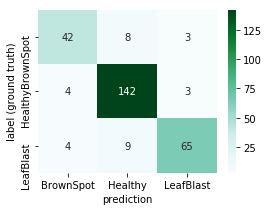

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 178	TRAIN	Loss: 0.57	Correct: 1935/2510(77.09%)
		VALID.:	Loss: 0.56	Correct: 244/280(87.14%)
----------------------------------------


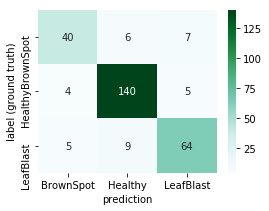

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 179	TRAIN	Loss: 1.4	Correct: 1932/2510(76.97%)
		VALID.:	Loss: 0.5	Correct: 238/280(85.0%)
----------------------------------------


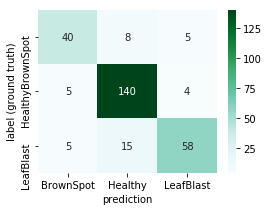

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 180	TRAIN	Loss: 0.41	Correct: 1944/2510(77.45%)
		VALID.:	Loss: 0.42	Correct: 235/280(83.93%)
----------------------------------------


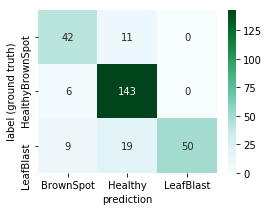

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 181	TRAIN	Loss: 0.55	Correct: 1941/2510(77.33%)
		VALID.:	Loss: 0.58	Correct: 237/280(84.64%)
----------------------------------------


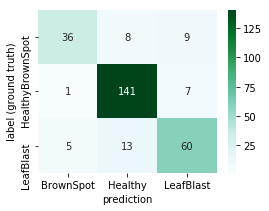

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 182	TRAIN	Loss: 0.62	Correct: 1935/2510(77.09%)
		VALID.:	Loss: 0.53	Correct: 247/280(88.21%)
----------------------------------------


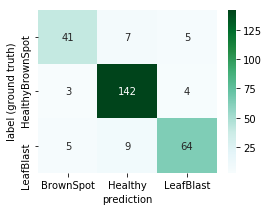

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 183	TRAIN	Loss: 0.51	Correct: 1939/2510(77.25%)
		VALID.:	Loss: 0.42	Correct: 238/280(85.0%)
----------------------------------------


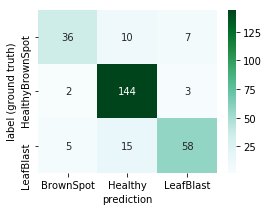

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 184	TRAIN	Loss: 0.6	Correct: 1973/2510(78.61%)
		VALID.:	Loss: 0.43	Correct: 238/280(85.0%)
----------------------------------------


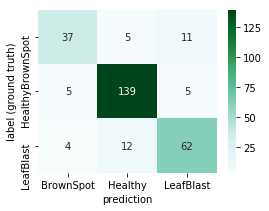

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 185	TRAIN	Loss: 0.76	Correct: 1928/2510(76.81%)
		VALID.:	Loss: 0.36	Correct: 237/280(84.64%)
----------------------------------------


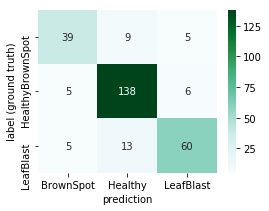

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 186	TRAIN	Loss: 0.45	Correct: 1978/2510(78.8%)
		VALID.:	Loss: 0.35	Correct: 245/280(87.5%)
----------------------------------------


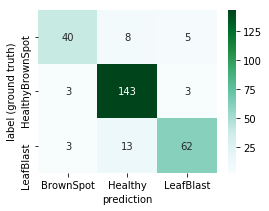

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 187	TRAIN	Loss: 0.4	Correct: 1937/2510(77.17%)
		VALID.:	Loss: 0.47	Correct: 244/280(87.14%)
----------------------------------------


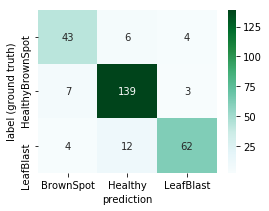

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 188	TRAIN	Loss: 0.09	Correct: 1939/2510(77.25%)
		VALID.:	Loss: 0.42	Correct: 236/280(84.29%)
----------------------------------------


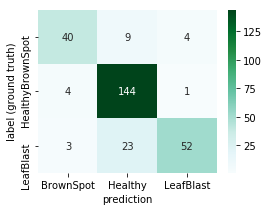

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 189	TRAIN	Loss: 0.4	Correct: 1963/2510(78.21%)
		VALID.:	Loss: 0.31	Correct: 243/280(86.79%)
----------------------------------------


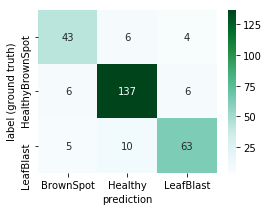

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 190	TRAIN	Loss: 0.5	Correct: 1926/2510(76.73%)
		VALID.:	Loss: 0.59	Correct: 212/280(75.71%)
----------------------------------------


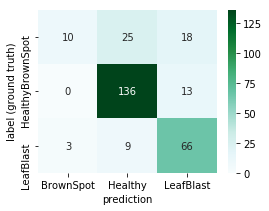

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 191	TRAIN	Loss: 0.37	Correct: 1950/2510(77.69%)
		VALID.:	Loss: 0.47	Correct: 246/280(87.86%)
----------------------------------------


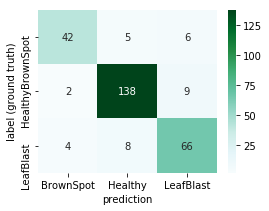

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 192	TRAIN	Loss: 0.4	Correct: 1936/2510(77.13%)
		VALID.:	Loss: 0.33	Correct: 245/280(87.5%)
----------------------------------------


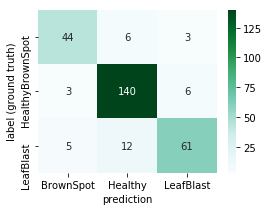

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 193	TRAIN	Loss: 0.49	Correct: 1944/2510(77.45%)
		VALID.:	Loss: 0.48	Correct: 236/280(84.29%)
----------------------------------------


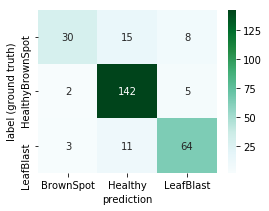

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 194	TRAIN	Loss: 0.31	Correct: 1942/2510(77.37%)
		VALID.:	Loss: 0.37	Correct: 241/280(86.07%)
----------------------------------------


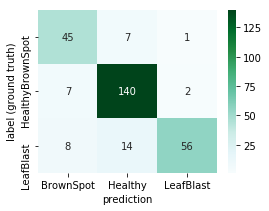

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 195	TRAIN	Loss: 0.34	Correct: 1930/2510(76.89%)
		VALID.:	Loss: 0.48	Correct: 234/280(83.57%)
----------------------------------------


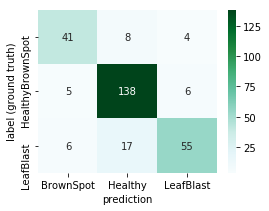

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 196	TRAIN	Loss: 0.51	Correct: 1947/2510(77.57%)
		VALID.:	Loss: 0.45	Correct: 239/280(85.36%)
----------------------------------------


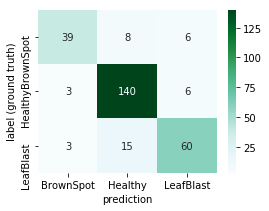

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 197	TRAIN	Loss: 0.59	Correct: 1963/2510(78.21%)
		VALID.:	Loss: 0.42	Correct: 243/280(86.79%)
----------------------------------------


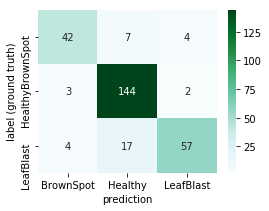

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 198	TRAIN	Loss: 0.18	Correct: 1960/2510(78.09%)
		VALID.:	Loss: 0.4	Correct: 249/280(88.93%)
----------------------------------------


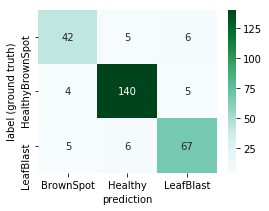

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 199	TRAIN	Loss: 0.31	Correct: 1956/2510(77.93%)
		VALID.:	Loss: 0.45	Correct: 233/280(83.21%)
----------------------------------------


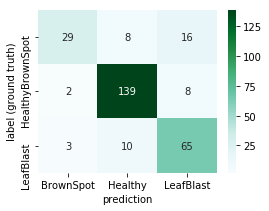

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 200	TRAIN	Loss: 0.95	Correct: 1943/2510(77.41%)
		VALID.:	Loss: 0.41	Correct: 245/280(87.5%)
----------------------------------------


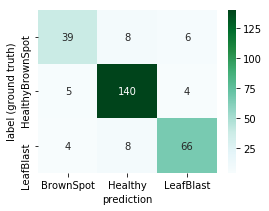

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 201	TRAIN	Loss: 0.32	Correct: 1964/2510(78.25%)
		VALID.:	Loss: 0.41	Correct: 241/280(86.07%)
----------------------------------------


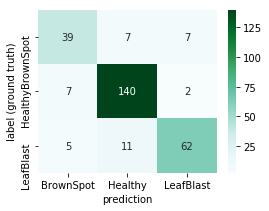

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 202	TRAIN	Loss: 0.52	Correct: 1961/2510(78.13%)
		VALID.:	Loss: 0.48	Correct: 235/280(83.93%)
----------------------------------------


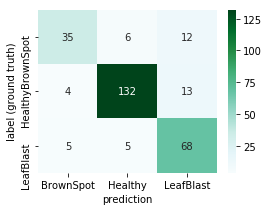

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 203	TRAIN	Loss: 0.93	Correct: 1949/2510(77.65%)
		VALID.:	Loss: 0.47	Correct: 234/280(83.57%)
----------------------------------------


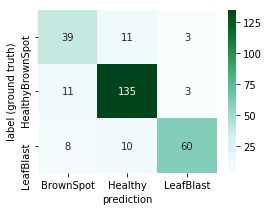

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 204	TRAIN	Loss: 0.75	Correct: 1937/2510(77.17%)
		VALID.:	Loss: 0.34	Correct: 244/280(87.14%)
----------------------------------------


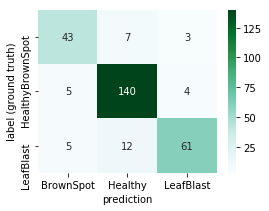

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 205	TRAIN	Loss: 0.76	Correct: 1954/2510(77.85%)
		VALID.:	Loss: 0.38	Correct: 249/280(88.93%)
----------------------------------------


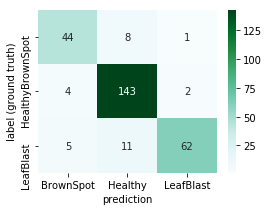

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 206	TRAIN	Loss: 0.38	Correct: 1947/2510(77.57%)
		VALID.:	Loss: 0.38	Correct: 242/280(86.43%)
----------------------------------------


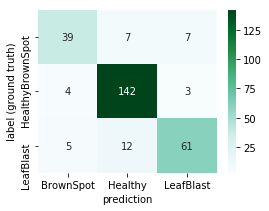

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 207	TRAIN	Loss: 0.35	Correct: 1934/2510(77.05%)
		VALID.:	Loss: 0.52	Correct: 239/280(85.36%)
----------------------------------------


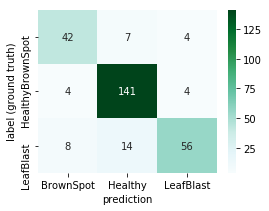

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 208	TRAIN	Loss: 0.33	Correct: 1947/2510(77.57%)
		VALID.:	Loss: 0.64	Correct: 244/280(87.14%)
----------------------------------------


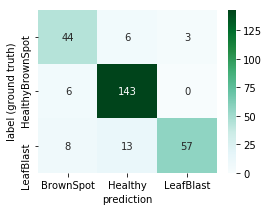

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 209	TRAIN	Loss: 0.65	Correct: 1939/2510(77.25%)
		VALID.:	Loss: 0.45	Correct: 236/280(84.29%)
----------------------------------------


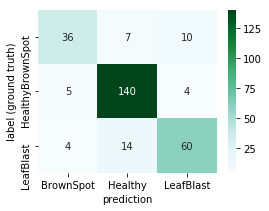

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 210	TRAIN	Loss: 0.41	Correct: 1966/2510(78.33%)
		VALID.:	Loss: 0.49	Correct: 233/280(83.21%)
----------------------------------------


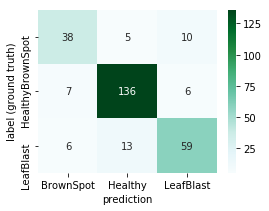

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 211	TRAIN	Loss: 0.67	Correct: 1937/2510(77.17%)
		VALID.:	Loss: 0.38	Correct: 236/280(84.29%)
----------------------------------------


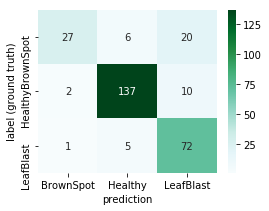

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 212	TRAIN	Loss: 0.45	Correct: 1927/2510(76.77%)
		VALID.:	Loss: 0.44	Correct: 245/280(87.5%)
----------------------------------------


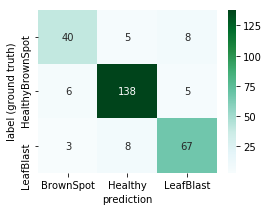

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 213	TRAIN	Loss: 0.2	Correct: 1946/2510(77.53%)
		VALID.:	Loss: 0.45	Correct: 240/280(85.71%)
----------------------------------------


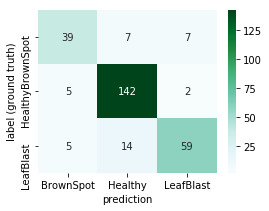

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 214	TRAIN	Loss: 0.48	Correct: 1950/2510(77.69%)
		VALID.:	Loss: 0.43	Correct: 242/280(86.43%)
----------------------------------------


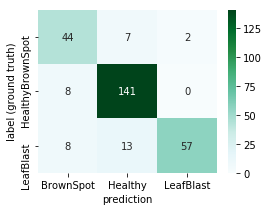

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 215	TRAIN	Loss: 0.58	Correct: 1952/2510(77.77%)
		VALID.:	Loss: 0.38	Correct: 244/280(87.14%)
----------------------------------------


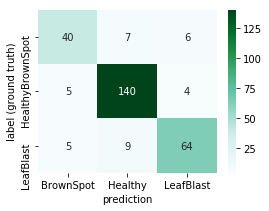

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 216	TRAIN	Loss: 0.45	Correct: 1936/2510(77.13%)
		VALID.:	Loss: 0.45	Correct: 243/280(86.79%)
----------------------------------------


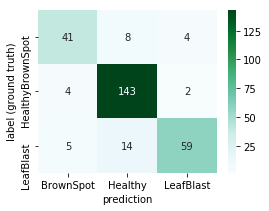

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 217	TRAIN	Loss: 0.39	Correct: 1933/2510(77.01%)
		VALID.:	Loss: 0.38	Correct: 243/280(86.79%)
----------------------------------------


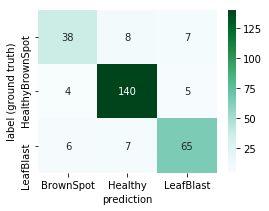

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 218	TRAIN	Loss: 0.64	Correct: 1959/2510(78.05%)
		VALID.:	Loss: 0.42	Correct: 245/280(87.5%)
----------------------------------------


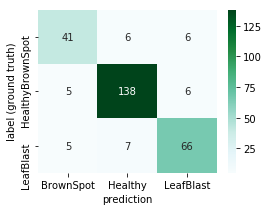

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 219	TRAIN	Loss: 0.7	Correct: 1952/2510(77.77%)
		VALID.:	Loss: 0.49	Correct: 240/280(85.71%)
----------------------------------------


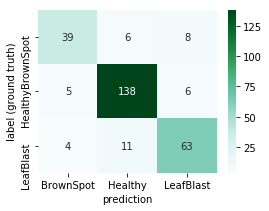

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 220	TRAIN	Loss: 0.25	Correct: 1954/2510(77.85%)
		VALID.:	Loss: 0.41	Correct: 242/280(86.43%)
----------------------------------------


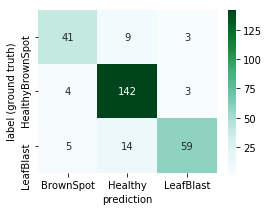

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 221	TRAIN	Loss: 0.48	Correct: 1942/2510(77.37%)
		VALID.:	Loss: 0.36	Correct: 246/280(87.86%)
----------------------------------------


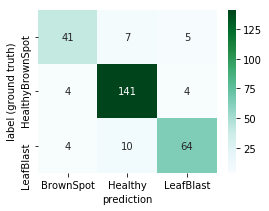

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 222	TRAIN	Loss: 0.67	Correct: 1935/2510(77.09%)
		VALID.:	Loss: 0.59	Correct: 246/280(87.86%)
----------------------------------------


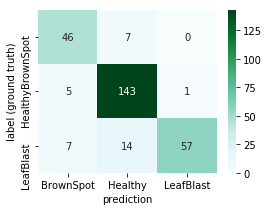

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 223	TRAIN	Loss: 1.2	Correct: 1968/2510(78.41%)
		VALID.:	Loss: 0.45	Correct: 246/280(87.86%)
----------------------------------------


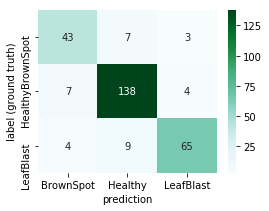

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 224	TRAIN	Loss: 0.49	Correct: 1969/2510(78.45%)
		VALID.:	Loss: 0.5	Correct: 244/280(87.14%)
----------------------------------------


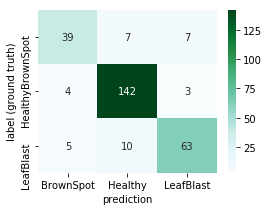

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 225	TRAIN	Loss: 0.57	Correct: 1949/2510(77.65%)
		VALID.:	Loss: 0.43	Correct: 235/280(83.93%)
----------------------------------------


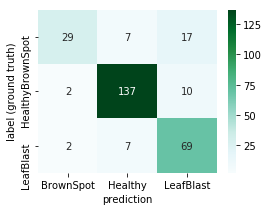

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 226	TRAIN	Loss: 0.53	Correct: 1977/2510(78.76%)
		VALID.:	Loss: 0.42	Correct: 240/280(85.71%)
----------------------------------------


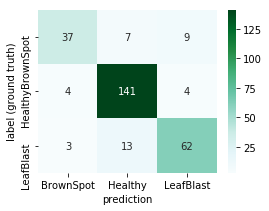

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 227	TRAIN	Loss: 0.53	Correct: 1973/2510(78.61%)
		VALID.:	Loss: 0.4	Correct: 246/280(87.86%)
----------------------------------------


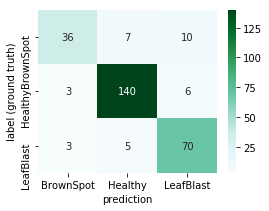

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 228	TRAIN	Loss: 0.67	Correct: 1882/2510(74.98%)
		VALID.:	Loss: 0.53	Correct: 240/280(85.71%)
----------------------------------------


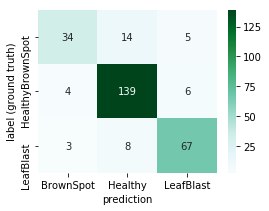

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 229	TRAIN	Loss: 0.2	Correct: 1878/2510(74.82%)
		VALID.:	Loss: 0.45	Correct: 230/280(82.14%)
----------------------------------------


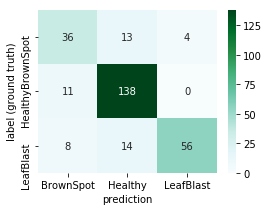

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 230	TRAIN	Loss: 0.7	Correct: 1907/2510(75.98%)
		VALID.:	Loss: 0.45	Correct: 236/280(84.29%)
----------------------------------------


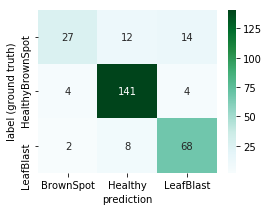

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 231	TRAIN	Loss: 1.28	Correct: 1886/2510(75.14%)
		VALID.:	Loss: 0.47	Correct: 237/280(84.64%)
----------------------------------------


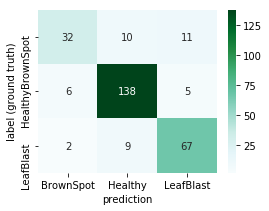

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 232	TRAIN	Loss: 0.56	Correct: 1903/2510(75.82%)
		VALID.:	Loss: 0.53	Correct: 239/280(85.36%)
----------------------------------------


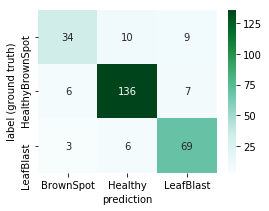

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 233	TRAIN	Loss: 0.86	Correct: 1906/2510(75.94%)
		VALID.:	Loss: 0.39	Correct: 225/280(80.36%)
----------------------------------------


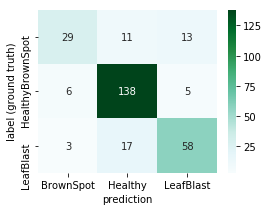

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 234	TRAIN	Loss: 0.24	Correct: 1910/2510(76.1%)
		VALID.:	Loss: 0.48	Correct: 231/280(82.5%)
----------------------------------------


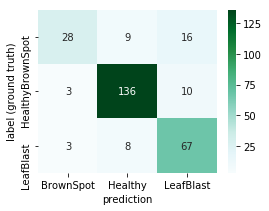

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 235	TRAIN	Loss: 0.9	Correct: 1880/2510(74.9%)
		VALID.:	Loss: 0.45	Correct: 234/280(83.57%)
----------------------------------------


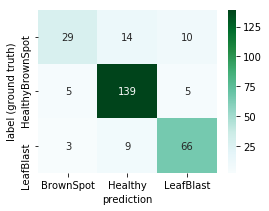

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 236	TRAIN	Loss: 0.37	Correct: 1911/2510(76.14%)
		VALID.:	Loss: 0.48	Correct: 244/280(87.14%)
----------------------------------------


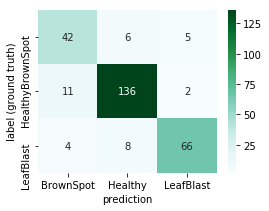

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 237	TRAIN	Loss: 0.59	Correct: 1960/2510(78.09%)
		VALID.:	Loss: 0.48	Correct: 244/280(87.14%)
----------------------------------------


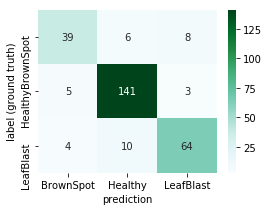

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 238	TRAIN	Loss: 0.25	Correct: 1956/2510(77.93%)
		VALID.:	Loss: 0.42	Correct: 253/280(90.36%)
----------------------------------------


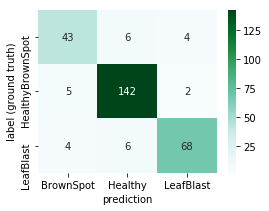

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 239	TRAIN	Loss: 0.74	Correct: 1972/2510(78.57%)
		VALID.:	Loss: 0.33	Correct: 244/280(87.14%)
----------------------------------------


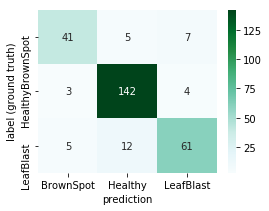

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 240	TRAIN	Loss: 0.93	Correct: 1956/2510(77.93%)
		VALID.:	Loss: 0.43	Correct: 245/280(87.5%)
----------------------------------------


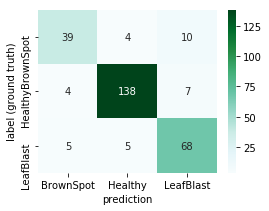

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 241	TRAIN	Loss: 0.65	Correct: 1929/2510(76.85%)
		VALID.:	Loss: 0.52	Correct: 231/280(82.5%)
----------------------------------------


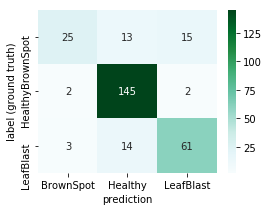

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 242	TRAIN	Loss: 0.72	Correct: 1931/2510(76.93%)
		VALID.:	Loss: 0.42	Correct: 240/280(85.71%)
----------------------------------------


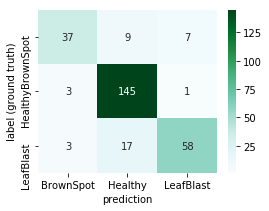

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 243	TRAIN	Loss: 0.37	Correct: 1972/2510(78.57%)
		VALID.:	Loss: 0.49	Correct: 240/280(85.71%)
----------------------------------------


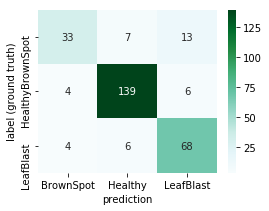

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 244	TRAIN	Loss: 0.61	Correct: 1985/2510(79.08%)
		VALID.:	Loss: 0.54	Correct: 248/280(88.57%)
----------------------------------------


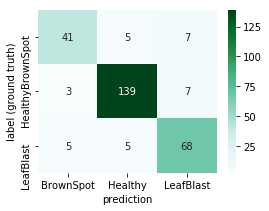

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 245	TRAIN	Loss: 0.42	Correct: 1948/2510(77.61%)
		VALID.:	Loss: 0.36	Correct: 242/280(86.43%)
----------------------------------------


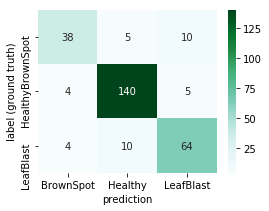

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 246	TRAIN	Loss: 0.45	Correct: 1952/2510(77.77%)
		VALID.:	Loss: 0.46	Correct: 239/280(85.36%)
----------------------------------------


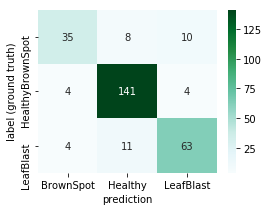

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 247	TRAIN	Loss: 0.26	Correct: 1930/2510(76.89%)
		VALID.:	Loss: 0.35	Correct: 245/280(87.5%)
----------------------------------------


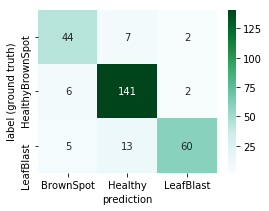

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 248	TRAIN	Loss: 0.67	Correct: 1995/2510(79.48%)
		VALID.:	Loss: 0.51	Correct: 245/280(87.5%)
----------------------------------------


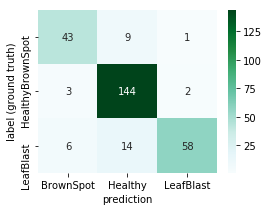

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 249	TRAIN	Loss: 0.36	Correct: 1928/2510(76.81%)
		VALID.:	Loss: 0.42	Correct: 241/280(86.07%)
----------------------------------------


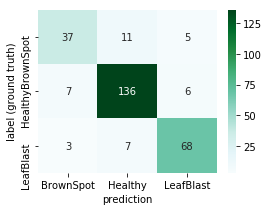

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 250	TRAIN	Loss: 0.29	Correct: 1958/2510(78.01%)
		VALID.:	Loss: 0.45	Correct: 237/280(84.64%)
----------------------------------------


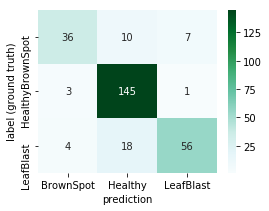

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 251	TRAIN	Loss: 0.42	Correct: 1973/2510(78.61%)
		VALID.:	Loss: 0.37	Correct: 244/280(87.14%)
----------------------------------------


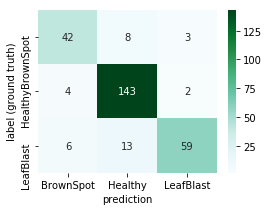

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 252	TRAIN	Loss: 0.63	Correct: 1962/2510(78.17%)
		VALID.:	Loss: 0.54	Correct: 242/280(86.43%)
----------------------------------------


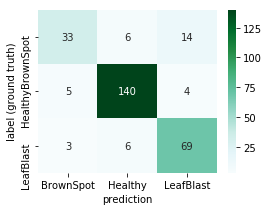

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 253	TRAIN	Loss: 0.38	Correct: 1968/2510(78.41%)
		VALID.:	Loss: 0.39	Correct: 246/280(87.86%)
----------------------------------------


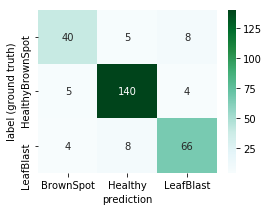

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 254	TRAIN	Loss: 0.44	Correct: 1963/2510(78.21%)
		VALID.:	Loss: 0.35	Correct: 241/280(86.07%)
----------------------------------------


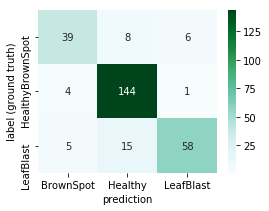

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 255	TRAIN	Loss: 0.77	Correct: 1929/2510(76.85%)
		VALID.:	Loss: 0.41	Correct: 242/280(86.43%)
----------------------------------------


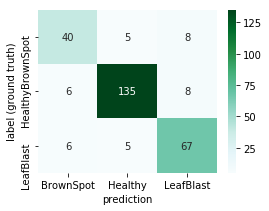

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 256	TRAIN	Loss: 0.53	Correct: 1979/2510(78.84%)
		VALID.:	Loss: 0.39	Correct: 235/280(83.93%)
----------------------------------------


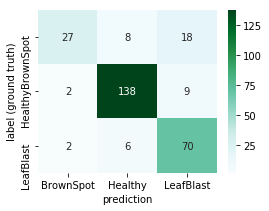

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 257	TRAIN	Loss: 0.74	Correct: 1983/2510(79.0%)
		VALID.:	Loss: 0.47	Correct: 240/280(85.71%)
----------------------------------------


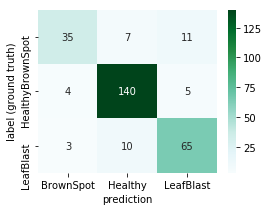

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 258	TRAIN	Loss: 0.59	Correct: 1975/2510(78.69%)
		VALID.:	Loss: 0.4	Correct: 238/280(85.0%)
----------------------------------------


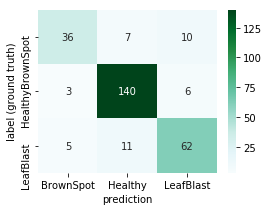

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 259	TRAIN	Loss: 0.52	Correct: 1956/2510(77.93%)
		VALID.:	Loss: 0.44	Correct: 240/280(85.71%)
----------------------------------------


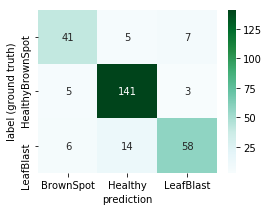

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 260	TRAIN	Loss: 0.84	Correct: 1952/2510(77.77%)
		VALID.:	Loss: 0.59	Correct: 226/280(80.71%)
----------------------------------------


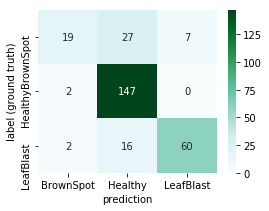

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 261	TRAIN	Loss: 0.85	Correct: 1887/2510(75.18%)
		VALID.:	Loss: 0.59	Correct: 235/280(83.93%)
----------------------------------------


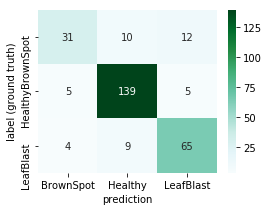

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 262	TRAIN	Loss: 0.67	Correct: 1919/2510(76.45%)
		VALID.:	Loss: 0.48	Correct: 237/280(84.64%)
----------------------------------------


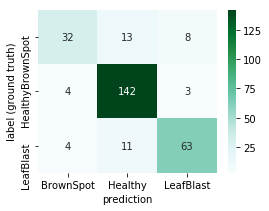

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 263	TRAIN	Loss: 0.27	Correct: 1915/2510(76.29%)
		VALID.:	Loss: 0.6	Correct: 224/280(80.0%)
----------------------------------------


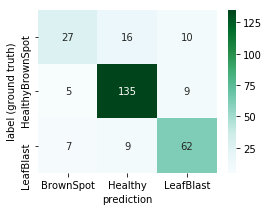

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 264	TRAIN	Loss: 0.68	Correct: 1931/2510(76.93%)
		VALID.:	Loss: 0.44	Correct: 238/280(85.0%)
----------------------------------------


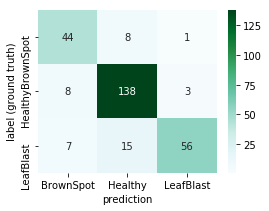

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 265	TRAIN	Loss: 0.56	Correct: 1974/2510(78.65%)
		VALID.:	Loss: 0.39	Correct: 242/280(86.43%)
----------------------------------------


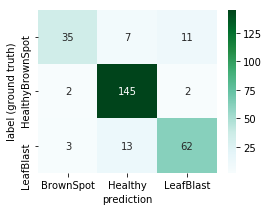

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 266	TRAIN	Loss: 0.47	Correct: 1948/2510(77.61%)
		VALID.:	Loss: 0.48	Correct: 240/280(85.71%)
----------------------------------------


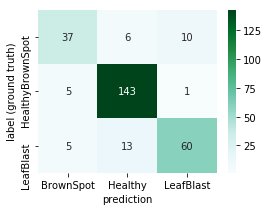

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 267	TRAIN	Loss: 0.76	Correct: 1989/2510(79.24%)
		VALID.:	Loss: 0.45	Correct: 251/280(89.64%)
----------------------------------------


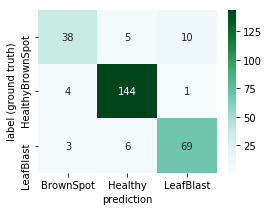

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 268	TRAIN	Loss: 0.64	Correct: 1984/2510(79.04%)
		VALID.:	Loss: 0.35	Correct: 250/280(89.29%)
----------------------------------------


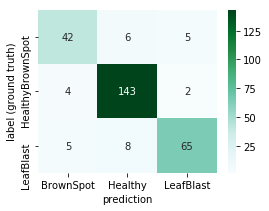

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 269	TRAIN	Loss: 0.37	Correct: 1955/2510(77.89%)
		VALID.:	Loss: 0.41	Correct: 241/280(86.07%)
----------------------------------------


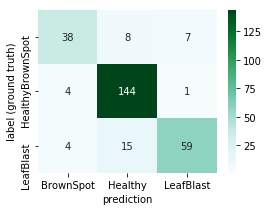

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 270	TRAIN	Loss: 0.3	Correct: 1970/2510(78.49%)
		VALID.:	Loss: 0.46	Correct: 242/280(86.43%)
----------------------------------------


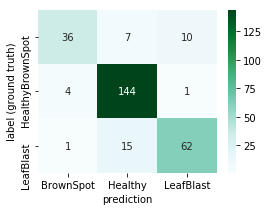

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 271	TRAIN	Loss: 0.45	Correct: 1950/2510(77.69%)
		VALID.:	Loss: 0.52	Correct: 238/280(85.0%)
----------------------------------------


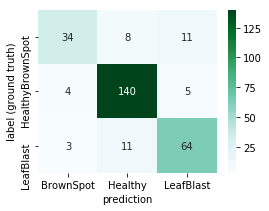

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 272	TRAIN	Loss: 0.67	Correct: 1955/2510(77.89%)
		VALID.:	Loss: 0.58	Correct: 238/280(85.0%)
----------------------------------------


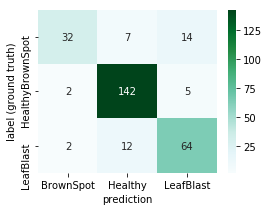

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 273	TRAIN	Loss: 0.32	Correct: 1963/2510(78.21%)
		VALID.:	Loss: 0.31	Correct: 249/280(88.93%)
----------------------------------------


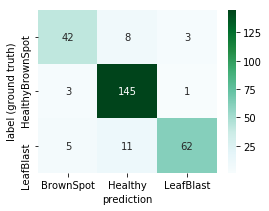

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 274	TRAIN	Loss: 0.62	Correct: 1975/2510(78.69%)
		VALID.:	Loss: 0.42	Correct: 239/280(85.36%)
----------------------------------------


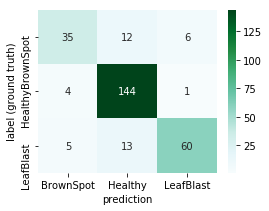

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 275	TRAIN	Loss: 0.61	Correct: 1961/2510(78.13%)
		VALID.:	Loss: 0.41	Correct: 239/280(85.36%)
----------------------------------------


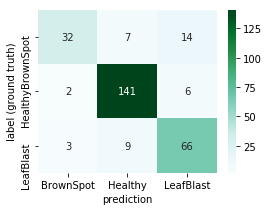

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 276	TRAIN	Loss: 0.59	Correct: 1990/2510(79.28%)
		VALID.:	Loss: 0.5	Correct: 250/280(89.29%)
----------------------------------------


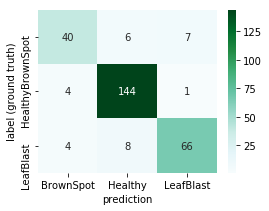

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 277	TRAIN	Loss: 0.45	Correct: 1948/2510(77.61%)
		VALID.:	Loss: 0.47	Correct: 240/280(85.71%)
----------------------------------------


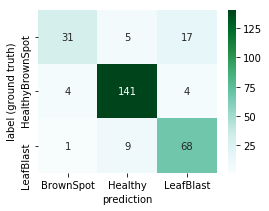

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 278	TRAIN	Loss: 1.46	Correct: 1910/2510(76.1%)
		VALID.:	Loss: 0.4	Correct: 237/280(84.64%)
----------------------------------------


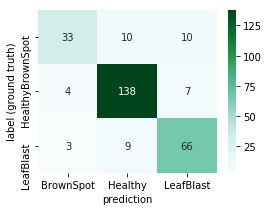

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 279	TRAIN	Loss: 1.18	Correct: 1914/2510(76.25%)
		VALID.:	Loss: 0.53	Correct: 230/280(82.14%)
----------------------------------------


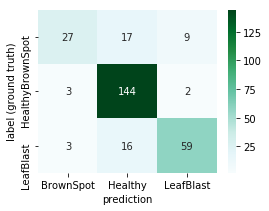

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 280	TRAIN	Loss: 0.21	Correct: 1898/2510(75.62%)
		VALID.:	Loss: 0.45	Correct: 232/280(82.86%)
----------------------------------------


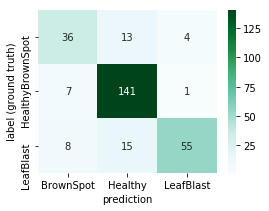

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 281	TRAIN	Loss: 0.63	Correct: 1906/2510(75.94%)
		VALID.:	Loss: 0.41	Correct: 236/280(84.29%)
----------------------------------------


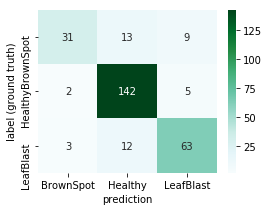

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 282	TRAIN	Loss: 0.56	Correct: 1916/2510(76.33%)
		VALID.:	Loss: 0.4	Correct: 245/280(87.5%)
----------------------------------------


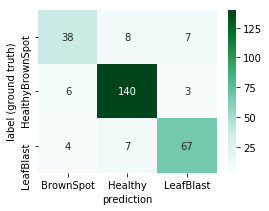

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 283	TRAIN	Loss: 1.03	Correct: 1895/2510(75.5%)
		VALID.:	Loss: 0.37	Correct: 241/280(86.07%)
----------------------------------------


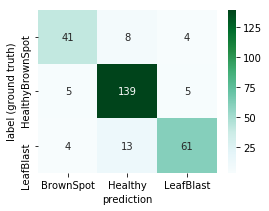

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 284	TRAIN	Loss: 0.67	Correct: 1912/2510(76.18%)
		VALID.:	Loss: 0.53	Correct: 238/280(85.0%)
----------------------------------------


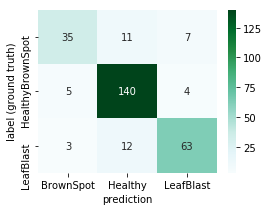

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 285	TRAIN	Loss: 0.65	Correct: 1912/2510(76.18%)
		VALID.:	Loss: 0.48	Correct: 236/280(84.29%)
----------------------------------------


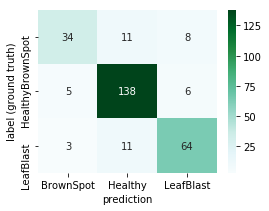

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 286	TRAIN	Loss: 0.26	Correct: 1928/2510(76.81%)
		VALID.:	Loss: 0.52	Correct: 232/280(82.86%)
----------------------------------------


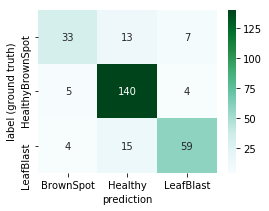

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 287	TRAIN	Loss: 0.57	Correct: 1893/2510(75.42%)
		VALID.:	Loss: 0.65	Correct: 230/280(82.14%)
----------------------------------------


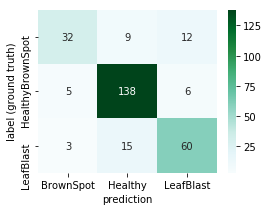

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 288	TRAIN	Loss: 0.59	Correct: 1942/2510(77.37%)
		VALID.:	Loss: 0.43	Correct: 239/280(85.36%)
----------------------------------------


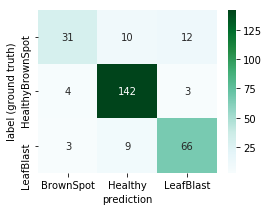

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 289	TRAIN	Loss: 0.97	Correct: 1887/2510(75.18%)
		VALID.:	Loss: 0.49	Correct: 238/280(85.0%)
----------------------------------------


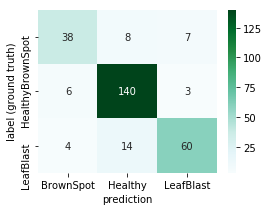

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 290	TRAIN	Loss: 0.65	Correct: 1946/2510(77.53%)
		VALID.:	Loss: 0.42	Correct: 239/280(85.36%)
----------------------------------------


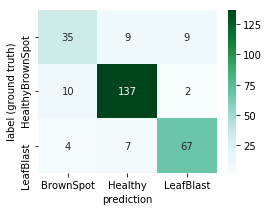

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 291	TRAIN	Loss: 0.38	Correct: 1885/2510(75.1%)
		VALID.:	Loss: 0.56	Correct: 234/280(83.57%)
----------------------------------------


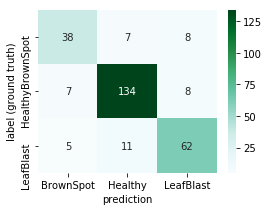

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 292	TRAIN	Loss: 0.42	Correct: 1943/2510(77.41%)
		VALID.:	Loss: 0.39	Correct: 237/280(84.64%)
----------------------------------------


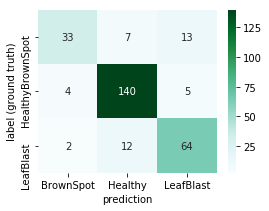

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 293	TRAIN	Loss: 0.37	Correct: 1917/2510(76.37%)
		VALID.:	Loss: 0.5	Correct: 243/280(86.79%)
----------------------------------------


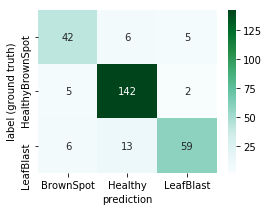

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 294	TRAIN	Loss: 0.79	Correct: 1945/2510(77.49%)
		VALID.:	Loss: 0.39	Correct: 243/280(86.79%)
----------------------------------------


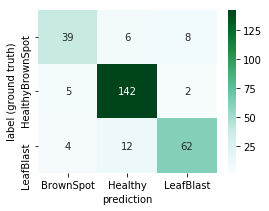

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 295	TRAIN	Loss: 0.31	Correct: 1916/2510(76.33%)
		VALID.:	Loss: 0.45	Correct: 231/280(82.5%)
----------------------------------------


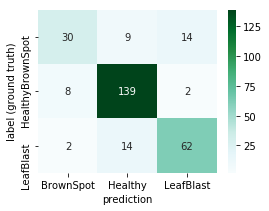

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 296	TRAIN	Loss: 0.51	Correct: 1945/2510(77.49%)
		VALID.:	Loss: 0.38	Correct: 240/280(85.71%)
----------------------------------------


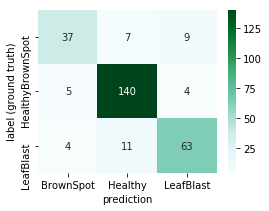

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 297	TRAIN	Loss: 0.83	Correct: 1955/2510(77.89%)
		VALID.:	Loss: 0.44	Correct: 237/280(84.64%)
----------------------------------------


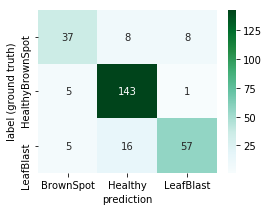

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 298	TRAIN	Loss: 0.5	Correct: 1931/2510(76.93%)
		VALID.:	Loss: 0.41	Correct: 240/280(85.71%)
----------------------------------------


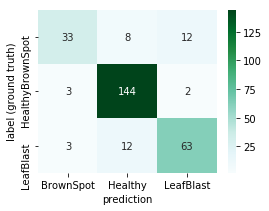

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 299	TRAIN	Loss: 0.22	Correct: 1960/2510(78.09%)
		VALID.:	Loss: 0.37	Correct: 242/280(86.43%)
----------------------------------------


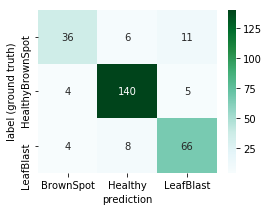

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 300	TRAIN	Loss: 0.41	Correct: 1917/2510(76.37%)
		VALID.:	Loss: 0.5	Correct: 234/280(83.57%)
----------------------------------------


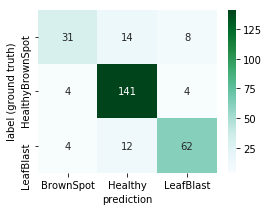

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 301	TRAIN	Loss: 0.84	Correct: 1918/2510(76.41%)
		VALID.:	Loss: 0.51	Correct: 239/280(85.36%)
----------------------------------------


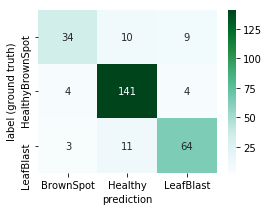

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 302	TRAIN	Loss: 0.44	Correct: 1944/2510(77.45%)
		VALID.:	Loss: 0.49	Correct: 236/280(84.29%)
----------------------------------------


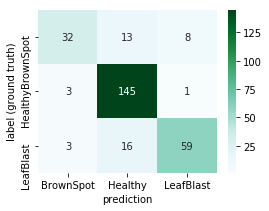

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 303	TRAIN	Loss: 0.27	Correct: 1966/2510(78.33%)
		VALID.:	Loss: 0.31	Correct: 244/280(87.14%)
----------------------------------------


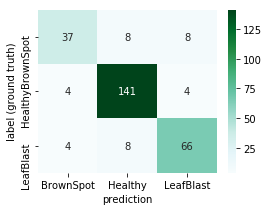

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 304	TRAIN	Loss: 0.52	Correct: 1962/2510(78.17%)
		VALID.:	Loss: 0.35	Correct: 247/280(88.21%)
----------------------------------------


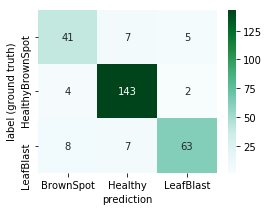

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 305	TRAIN	Loss: 0.58	Correct: 1919/2510(76.45%)
		VALID.:	Loss: 0.48	Correct: 236/280(84.29%)
----------------------------------------


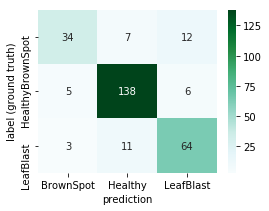

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 306	TRAIN	Loss: 0.15	Correct: 1925/2510(76.69%)
		VALID.:	Loss: 0.33	Correct: 243/280(86.79%)
----------------------------------------


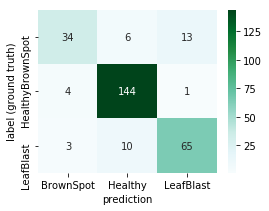

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 307	TRAIN	Loss: 0.45	Correct: 1922/2510(76.57%)
		VALID.:	Loss: 0.57	Correct: 239/280(85.36%)
----------------------------------------


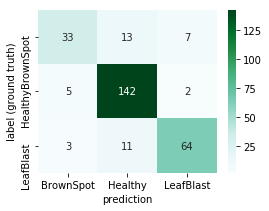

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 308	TRAIN	Loss: 0.53	Correct: 1912/2510(76.18%)
		VALID.:	Loss: 0.36	Correct: 240/280(85.71%)
----------------------------------------


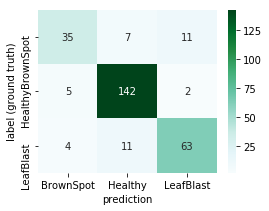

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 309	TRAIN	Loss: 0.38	Correct: 1987/2510(79.16%)
		VALID.:	Loss: 0.43	Correct: 247/280(88.21%)
----------------------------------------


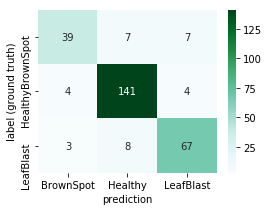

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 310	TRAIN	Loss: 0.23	Correct: 1971/2510(78.53%)
		VALID.:	Loss: 0.45	Correct: 241/280(86.07%)
----------------------------------------


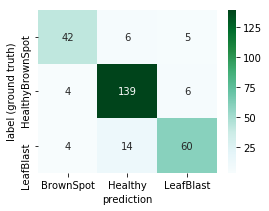

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 311	TRAIN	Loss: 0.52	Correct: 1954/2510(77.85%)
		VALID.:	Loss: 0.44	Correct: 244/280(87.14%)
----------------------------------------


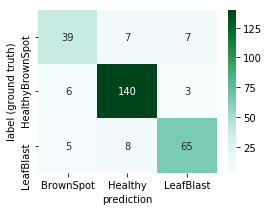

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 312	TRAIN	Loss: 0.76	Correct: 1986/2510(79.12%)
		VALID.:	Loss: 0.46	Correct: 242/280(86.43%)
----------------------------------------


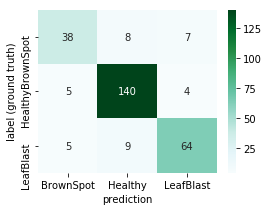

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 313	TRAIN	Loss: 0.97	Correct: 1987/2510(79.16%)
		VALID.:	Loss: 0.44	Correct: 243/280(86.79%)
----------------------------------------


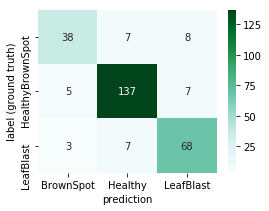

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 314	TRAIN	Loss: 0.67	Correct: 1926/2510(76.73%)
		VALID.:	Loss: 0.57	Correct: 232/280(82.86%)
----------------------------------------


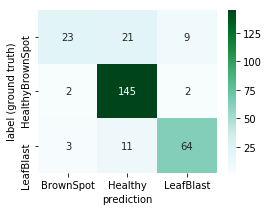

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 315	TRAIN	Loss: 0.73	Correct: 1933/2510(77.01%)
		VALID.:	Loss: 0.42	Correct: 245/280(87.5%)
----------------------------------------


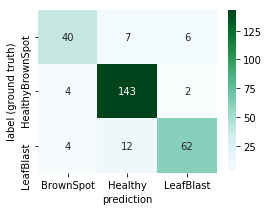

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 316	TRAIN	Loss: 1.43	Correct: 1943/2510(77.41%)
		VALID.:	Loss: 0.44	Correct: 247/280(88.21%)
----------------------------------------


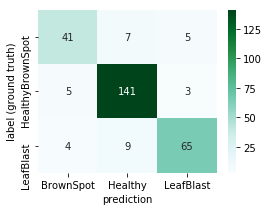

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 317	TRAIN	Loss: 0.79	Correct: 1993/2510(79.4%)
		VALID.:	Loss: 0.31	Correct: 246/280(87.86%)
----------------------------------------


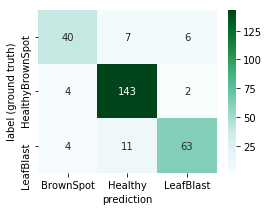

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 318	TRAIN	Loss: 0.47	Correct: 1977/2510(78.76%)
		VALID.:	Loss: 0.51	Correct: 235/280(83.93%)
----------------------------------------


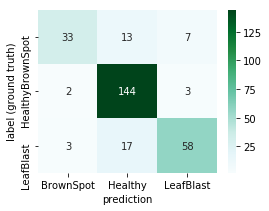

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 319	TRAIN	Loss: 0.54	Correct: 1949/2510(77.65%)
		VALID.:	Loss: 0.38	Correct: 236/280(84.29%)
----------------------------------------


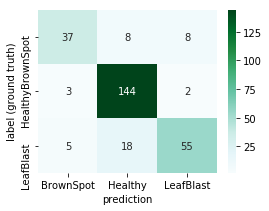

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 320	TRAIN	Loss: 0.79	Correct: 1954/2510(77.85%)
		VALID.:	Loss: 0.34	Correct: 247/280(88.21%)
----------------------------------------


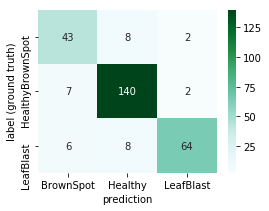

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 321	TRAIN	Loss: 0.49	Correct: 1935/2510(77.09%)
		VALID.:	Loss: 0.44	Correct: 230/280(82.14%)
----------------------------------------


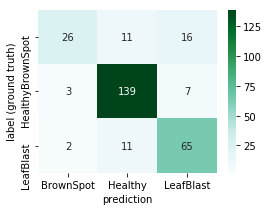

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 322	TRAIN	Loss: 1.01	Correct: 1933/2510(77.01%)
		VALID.:	Loss: 0.64	Correct: 234/280(83.57%)
----------------------------------------


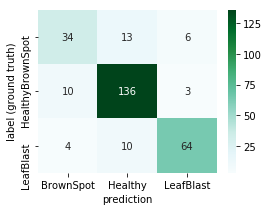

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 323	TRAIN	Loss: 0.89	Correct: 1920/2510(76.49%)
		VALID.:	Loss: 0.52	Correct: 237/280(84.64%)
----------------------------------------


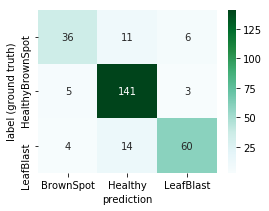

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 324	TRAIN	Loss: 0.46	Correct: 1912/2510(76.18%)
		VALID.:	Loss: 0.4	Correct: 243/280(86.79%)
----------------------------------------


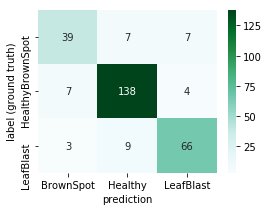

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 325	TRAIN	Loss: 0.74	Correct: 1983/2510(79.0%)
		VALID.:	Loss: 0.45	Correct: 230/280(82.14%)
----------------------------------------


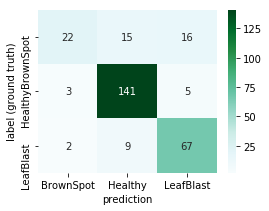

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 326	TRAIN	Loss: 0.21	Correct: 1905/2510(75.9%)
		VALID.:	Loss: 0.49	Correct: 222/280(79.29%)
----------------------------------------


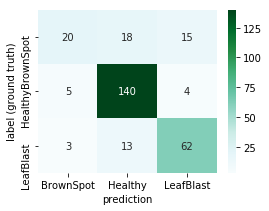

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 327	TRAIN	Loss: 1.18	Correct: 1934/2510(77.05%)
		VALID.:	Loss: 0.42	Correct: 235/280(83.93%)
----------------------------------------


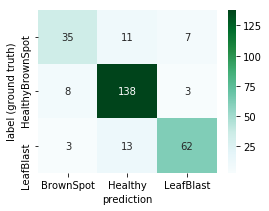

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 328	TRAIN	Loss: 0.59	Correct: 1892/2510(75.38%)
		VALID.:	Loss: 0.35	Correct: 237/280(84.64%)
----------------------------------------


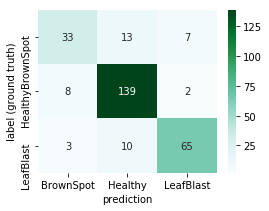

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 329	TRAIN	Loss: 0.71	Correct: 1923/2510(76.61%)
		VALID.:	Loss: 0.52	Correct: 233/280(83.21%)
----------------------------------------


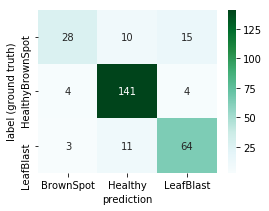

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 330	TRAIN	Loss: 0.53	Correct: 1905/2510(75.9%)
		VALID.:	Loss: 0.52	Correct: 233/280(83.21%)
----------------------------------------


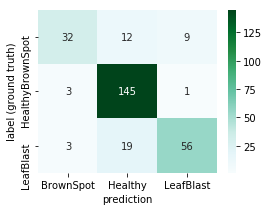

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 331	TRAIN	Loss: 0.91	Correct: 1933/2510(77.01%)
		VALID.:	Loss: 0.36	Correct: 241/280(86.07%)
----------------------------------------


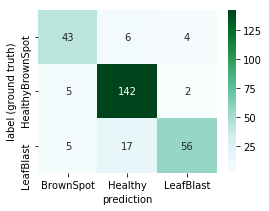

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 332	TRAIN	Loss: 0.64	Correct: 1976/2510(78.73%)
		VALID.:	Loss: 0.51	Correct: 236/280(84.29%)
----------------------------------------


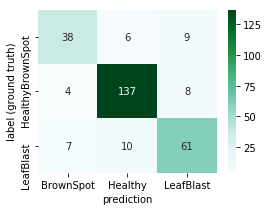

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 333	TRAIN	Loss: 0.83	Correct: 1968/2510(78.41%)
		VALID.:	Loss: 0.37	Correct: 244/280(87.14%)
----------------------------------------


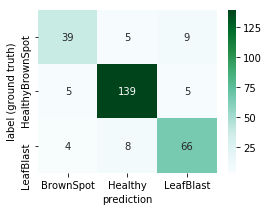

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 334	TRAIN	Loss: 0.78	Correct: 1937/2510(77.17%)
		VALID.:	Loss: 0.46	Correct: 243/280(86.79%)
----------------------------------------


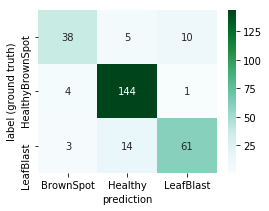

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 335	TRAIN	Loss: 0.64	Correct: 1952/2510(77.77%)
		VALID.:	Loss: 0.42	Correct: 234/280(83.57%)
----------------------------------------


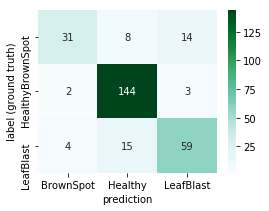

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 336	TRAIN	Loss: 0.22	Correct: 1944/2510(77.45%)
		VALID.:	Loss: 0.37	Correct: 237/280(84.64%)
----------------------------------------


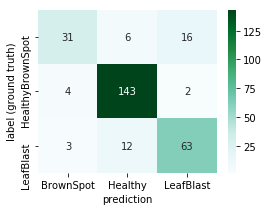

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 337	TRAIN	Loss: 0.31	Correct: 1945/2510(77.49%)
		VALID.:	Loss: 0.47	Correct: 234/280(83.57%)
----------------------------------------


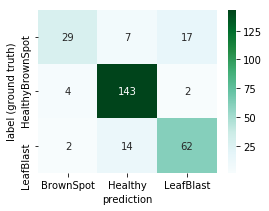

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 338	TRAIN	Loss: 1.16	Correct: 1958/2510(78.01%)
		VALID.:	Loss: 0.41	Correct: 240/280(85.71%)
----------------------------------------


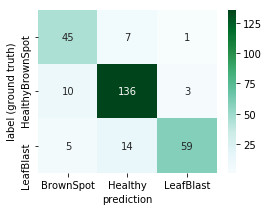

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 339	TRAIN	Loss: 0.22	Correct: 1982/2510(78.96%)
		VALID.:	Loss: 0.33	Correct: 244/280(87.14%)
----------------------------------------


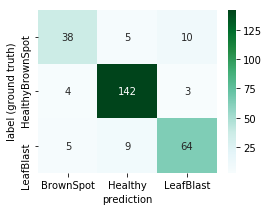

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 340	TRAIN	Loss: 0.58	Correct: 1944/2510(77.45%)
		VALID.:	Loss: 0.38	Correct: 243/280(86.79%)
----------------------------------------


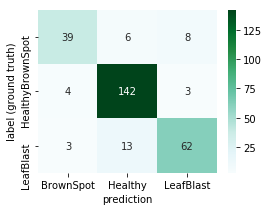

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 341	TRAIN	Loss: 1.43	Correct: 1983/2510(79.0%)
		VALID.:	Loss: 0.63	Correct: 236/280(84.29%)
----------------------------------------


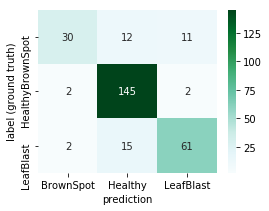

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 342	TRAIN	Loss: 0.41	Correct: 1914/2510(76.25%)
		VALID.:	Loss: 0.6	Correct: 235/280(83.93%)
----------------------------------------


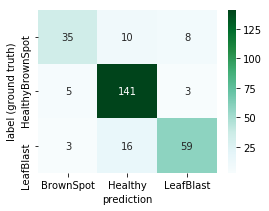

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 343	TRAIN	Loss: 0.7	Correct: 1932/2510(76.97%)
		VALID.:	Loss: 0.47	Correct: 233/280(83.21%)
----------------------------------------


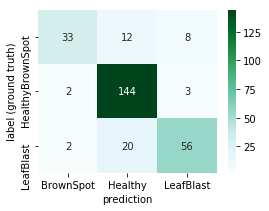

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 344	TRAIN	Loss: 0.49	Correct: 1947/2510(77.57%)
		VALID.:	Loss: 0.48	Correct: 243/280(86.79%)
----------------------------------------


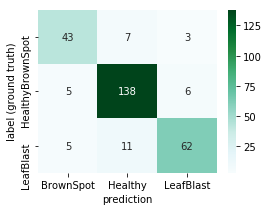

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 345	TRAIN	Loss: 0.42	Correct: 1943/2510(77.41%)
		VALID.:	Loss: 0.38	Correct: 246/280(87.86%)
----------------------------------------


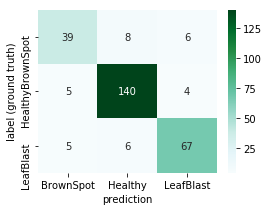

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 346	TRAIN	Loss: 0.65	Correct: 1991/2510(79.32%)
		VALID.:	Loss: 0.54	Correct: 235/280(83.93%)
----------------------------------------


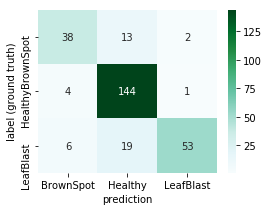

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 347	TRAIN	Loss: 0.32	Correct: 1980/2510(78.88%)
		VALID.:	Loss: 0.42	Correct: 239/280(85.36%)
----------------------------------------


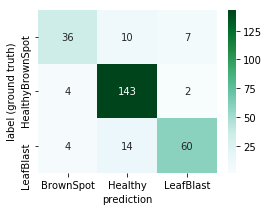

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 348	TRAIN	Loss: 0.18	Correct: 1987/2510(79.16%)
		VALID.:	Loss: 0.35	Correct: 243/280(86.79%)
----------------------------------------


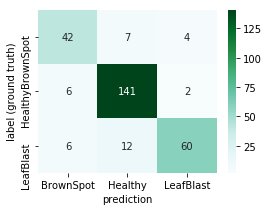

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 349	TRAIN	Loss: 0.32	Correct: 1971/2510(78.53%)
		VALID.:	Loss: 0.41	Correct: 240/280(85.71%)
----------------------------------------


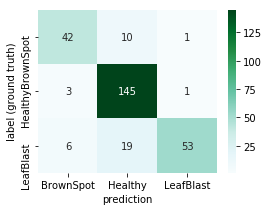

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 350	TRAIN	Loss: 0.8	Correct: 1989/2510(79.24%)
		VALID.:	Loss: 0.41	Correct: 249/280(88.93%)
----------------------------------------


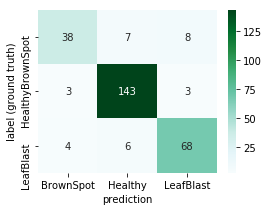

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 351	TRAIN	Loss: 0.37	Correct: 1964/2510(78.25%)
		VALID.:	Loss: 0.42	Correct: 243/280(86.79%)
----------------------------------------


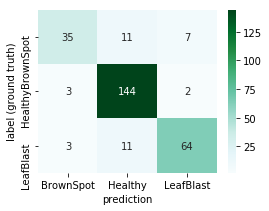

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 352	TRAIN	Loss: 0.5	Correct: 1949/2510(77.65%)
		VALID.:	Loss: 0.46	Correct: 240/280(85.71%)
----------------------------------------


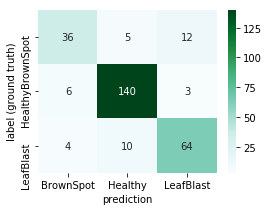

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 353	TRAIN	Loss: 0.48	Correct: 1958/2510(78.01%)
		VALID.:	Loss: 0.4	Correct: 235/280(83.93%)
----------------------------------------


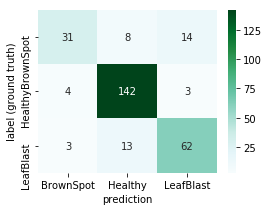

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 354	TRAIN	Loss: 0.28	Correct: 1975/2510(78.69%)
		VALID.:	Loss: 0.3	Correct: 244/280(87.14%)
----------------------------------------


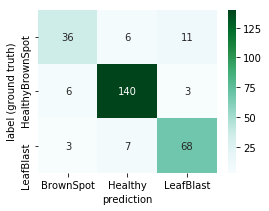

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 355	TRAIN	Loss: 0.39	Correct: 1975/2510(78.69%)
		VALID.:	Loss: 0.49	Correct: 235/280(83.93%)
----------------------------------------


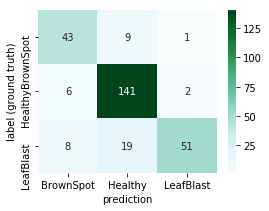

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 356	TRAIN	Loss: 0.78	Correct: 1978/2510(78.8%)
		VALID.:	Loss: 0.38	Correct: 237/280(84.64%)
----------------------------------------


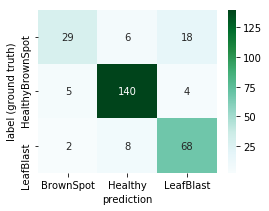

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 357	TRAIN	Loss: 0.61	Correct: 1988/2510(79.2%)
		VALID.:	Loss: 0.37	Correct: 243/280(86.79%)
----------------------------------------


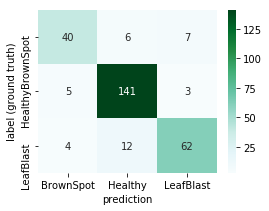

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 358	TRAIN	Loss: 0.53	Correct: 1982/2510(78.96%)
		VALID.:	Loss: 0.38	Correct: 240/280(85.71%)
----------------------------------------


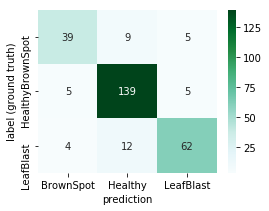

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 359	TRAIN	Loss: 0.44	Correct: 1979/2510(78.84%)
		VALID.:	Loss: 0.45	Correct: 242/280(86.43%)
----------------------------------------


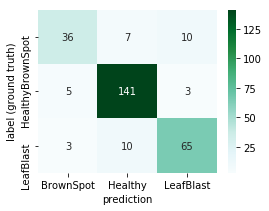

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 360	TRAIN	Loss: 0.4	Correct: 1897/2510(75.58%)
		VALID.:	Loss: 0.45	Correct: 235/280(83.93%)
----------------------------------------


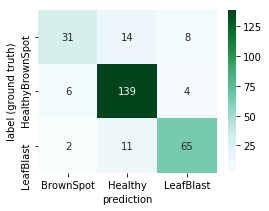

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 361	TRAIN	Loss: 0.3	Correct: 1926/2510(76.73%)
		VALID.:	Loss: 0.53	Correct: 229/280(81.79%)
----------------------------------------


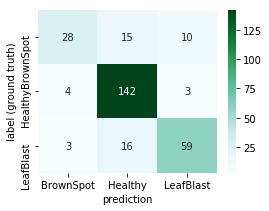

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 362	TRAIN	Loss: 0.33	Correct: 1944/2510(77.45%)
		VALID.:	Loss: 0.49	Correct: 241/280(86.07%)
----------------------------------------


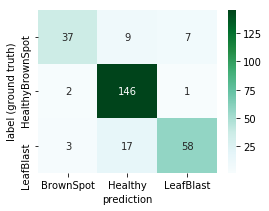

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 363	TRAIN	Loss: 0.69	Correct: 1961/2510(78.13%)
		VALID.:	Loss: 0.45	Correct: 244/280(87.14%)
----------------------------------------


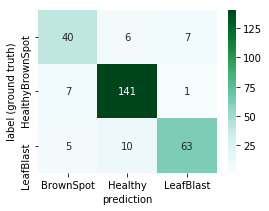

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 364	TRAIN	Loss: 0.3	Correct: 1974/2510(78.65%)
		VALID.:	Loss: 0.43	Correct: 248/280(88.57%)
----------------------------------------


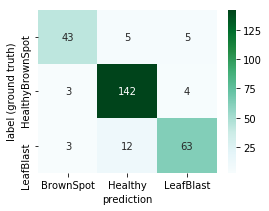

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 365	TRAIN	Loss: 0.51	Correct: 1971/2510(78.53%)
		VALID.:	Loss: 0.41	Correct: 245/280(87.5%)
----------------------------------------


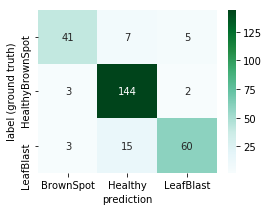

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 366	TRAIN	Loss: 0.82	Correct: 1979/2510(78.84%)
		VALID.:	Loss: 0.33	Correct: 244/280(87.14%)
----------------------------------------


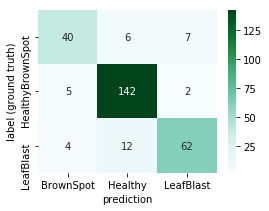

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 367	TRAIN	Loss: 0.54	Correct: 1969/2510(78.45%)
		VALID.:	Loss: 0.41	Correct: 243/280(86.79%)
----------------------------------------


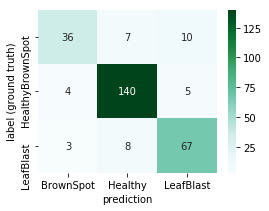

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 368	TRAIN	Loss: 0.73	Correct: 1971/2510(78.53%)
		VALID.:	Loss: 0.25	Correct: 241/280(86.07%)
----------------------------------------


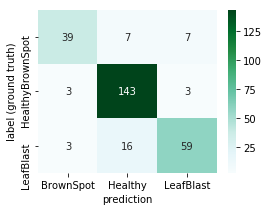

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 369	TRAIN	Loss: 0.34	Correct: 1985/2510(79.08%)
		VALID.:	Loss: 0.44	Correct: 245/280(87.5%)
----------------------------------------


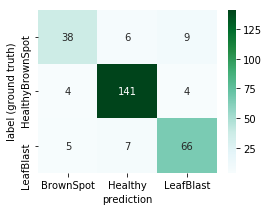

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 370	TRAIN	Loss: 0.52	Correct: 1969/2510(78.45%)
		VALID.:	Loss: 0.36	Correct: 243/280(86.79%)
----------------------------------------


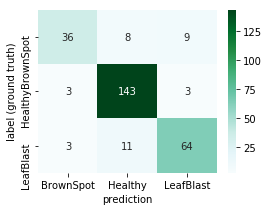

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 371	TRAIN	Loss: 0.39	Correct: 1947/2510(77.57%)
		VALID.:	Loss: 0.4	Correct: 245/280(87.5%)
----------------------------------------


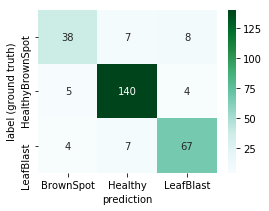

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 372	TRAIN	Loss: 0.64	Correct: 1978/2510(78.8%)
		VALID.:	Loss: 0.41	Correct: 245/280(87.5%)
----------------------------------------


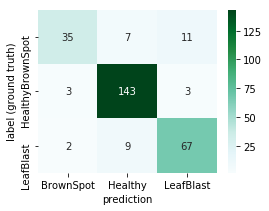

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 373	TRAIN	Loss: 0.49	Correct: 1955/2510(77.89%)
		VALID.:	Loss: 0.37	Correct: 244/280(87.14%)
----------------------------------------


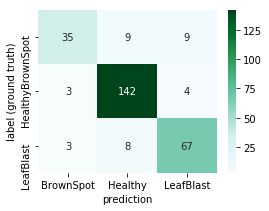

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 374	TRAIN	Loss: 1.1	Correct: 1957/2510(77.97%)
		VALID.:	Loss: 0.44	Correct: 244/280(87.14%)
----------------------------------------


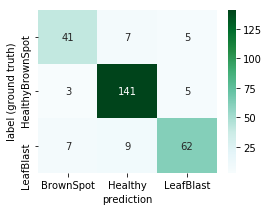

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 375	TRAIN	Loss: 0.37	Correct: 1991/2510(79.32%)
		VALID.:	Loss: 0.32	Correct: 244/280(87.14%)
----------------------------------------


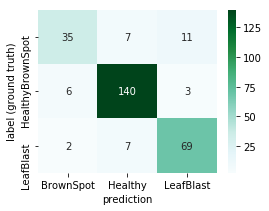

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 376	TRAIN	Loss: 0.36	Correct: 1991/2510(79.32%)
		VALID.:	Loss: 0.36	Correct: 247/280(88.21%)
----------------------------------------


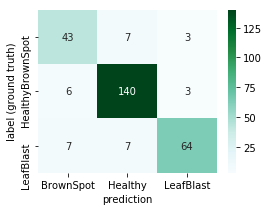

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 377	TRAIN	Loss: 0.19	Correct: 1994/2510(79.44%)
		VALID.:	Loss: 0.36	Correct: 242/280(86.43%)
----------------------------------------


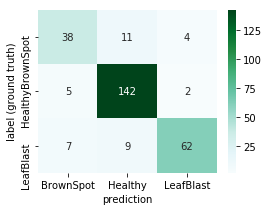

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 378	TRAIN	Loss: 0.38	Correct: 1971/2510(78.53%)
		VALID.:	Loss: 0.49	Correct: 236/280(84.29%)
----------------------------------------


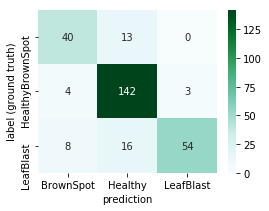

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 379	TRAIN	Loss: 0.61	Correct: 1987/2510(79.16%)
		VALID.:	Loss: 0.37	Correct: 240/280(85.71%)
----------------------------------------


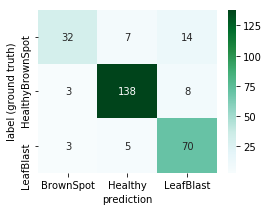

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 380	TRAIN	Loss: 0.81	Correct: 1981/2510(78.92%)
		VALID.:	Loss: 0.56	Correct: 234/280(83.57%)
----------------------------------------


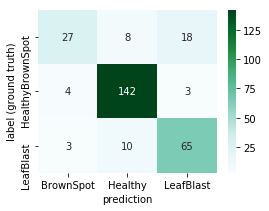

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 381	TRAIN	Loss: 0.29	Correct: 1920/2510(76.49%)
		VALID.:	Loss: 0.53	Correct: 225/280(80.36%)
----------------------------------------


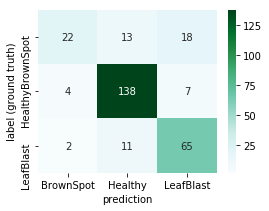

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 382	TRAIN	Loss: 0.17	Correct: 1910/2510(76.1%)
		VALID.:	Loss: 0.55	Correct: 230/280(82.14%)
----------------------------------------


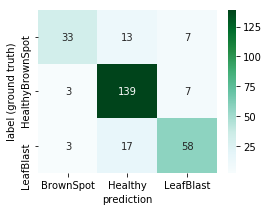

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 383	TRAIN	Loss: 0.43	Correct: 1985/2510(79.08%)
		VALID.:	Loss: 0.41	Correct: 242/280(86.43%)
----------------------------------------


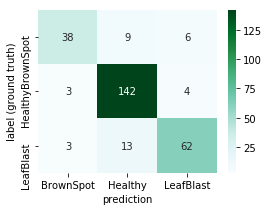

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 384	TRAIN	Loss: 0.62	Correct: 2003/2510(79.8%)
		VALID.:	Loss: 0.44	Correct: 248/280(88.57%)
----------------------------------------


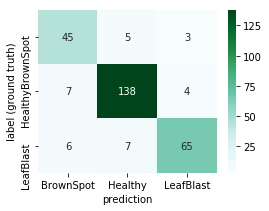

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 385	TRAIN	Loss: 0.19	Correct: 1982/2510(78.96%)
		VALID.:	Loss: 0.39	Correct: 243/280(86.79%)
----------------------------------------


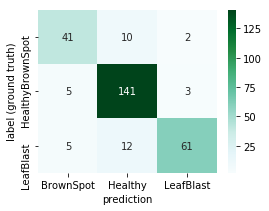

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 386	TRAIN	Loss: 0.59	Correct: 1992/2510(79.36%)
		VALID.:	Loss: 0.39	Correct: 241/280(86.07%)
----------------------------------------


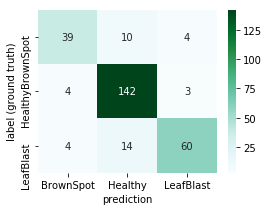

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 387	TRAIN	Loss: 0.32	Correct: 2003/2510(79.8%)
		VALID.:	Loss: 0.31	Correct: 244/280(87.14%)
----------------------------------------


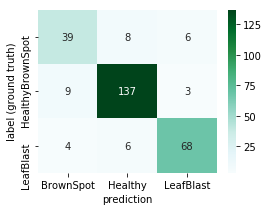

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 388	TRAIN	Loss: 0.78	Correct: 1972/2510(78.57%)
		VALID.:	Loss: 0.44	Correct: 238/280(85.0%)
----------------------------------------


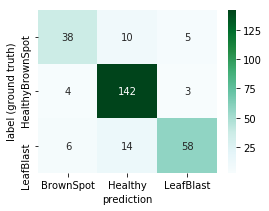

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 389	TRAIN	Loss: 0.48	Correct: 1974/2510(78.65%)
		VALID.:	Loss: 0.51	Correct: 238/280(85.0%)
----------------------------------------


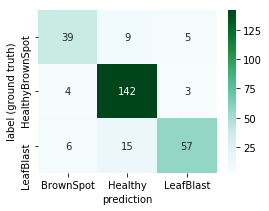

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 390	TRAIN	Loss: 1.01	Correct: 1963/2510(78.21%)
		VALID.:	Loss: 0.44	Correct: 242/280(86.43%)
----------------------------------------


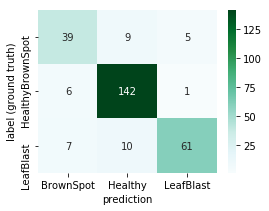

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 391	TRAIN	Loss: 0.21	Correct: 1983/2510(79.0%)
		VALID.:	Loss: 0.35	Correct: 246/280(87.86%)
----------------------------------------


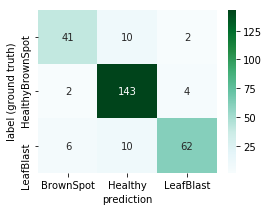

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 392	TRAIN	Loss: 0.76	Correct: 1989/2510(79.24%)
		VALID.:	Loss: 0.39	Correct: 246/280(87.86%)
----------------------------------------


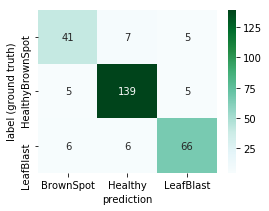

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 393	TRAIN	Loss: 0.19	Correct: 1999/2510(79.64%)
		VALID.:	Loss: 0.33	Correct: 244/280(87.14%)
----------------------------------------


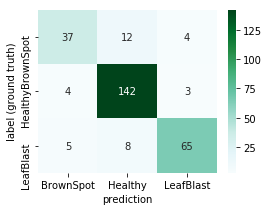

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 394	TRAIN	Loss: 0.46	Correct: 2001/2510(79.72%)
		VALID.:	Loss: 0.3	Correct: 246/280(87.86%)
----------------------------------------


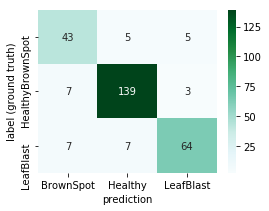

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 395	TRAIN	Loss: 0.5	Correct: 1977/2510(78.76%)
		VALID.:	Loss: 0.47	Correct: 246/280(87.86%)
----------------------------------------


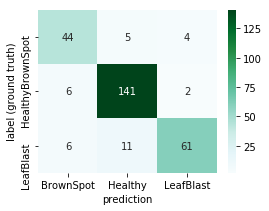

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 396	TRAIN	Loss: 0.72	Correct: 1977/2510(78.76%)
		VALID.:	Loss: 0.39	Correct: 242/280(86.43%)
----------------------------------------


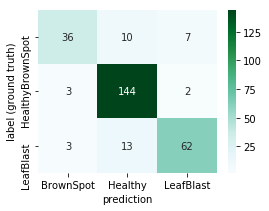

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 397	TRAIN	Loss: 0.69	Correct: 1978/2510(78.8%)
		VALID.:	Loss: 0.38	Correct: 244/280(87.14%)
----------------------------------------


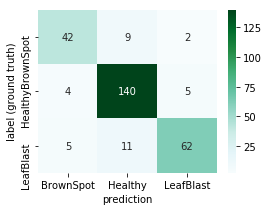

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 398	TRAIN	Loss: 0.37	Correct: 1956/2510(77.93%)
		VALID.:	Loss: 0.41	Correct: 241/280(86.07%)
----------------------------------------


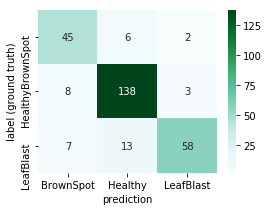

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 399	TRAIN	Loss: 0.36	Correct: 1963/2510(78.21%)
		VALID.:	Loss: 0.39	Correct: 246/280(87.86%)
----------------------------------------


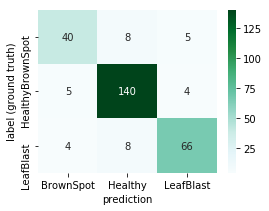

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 400	TRAIN	Loss: 0.23	Correct: 1977/2510(78.76%)
		VALID.:	Loss: 0.41	Correct: 239/280(85.36%)
----------------------------------------


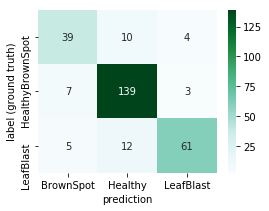

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 401	TRAIN	Loss: 0.45	Correct: 1987/2510(79.16%)
		VALID.:	Loss: 0.35	Correct: 246/280(87.86%)
----------------------------------------


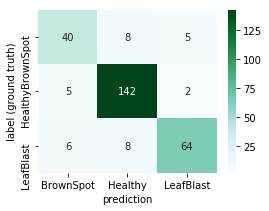

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 402	TRAIN	Loss: 0.73	Correct: 1990/2510(79.28%)
		VALID.:	Loss: 0.42	Correct: 243/280(86.79%)
----------------------------------------


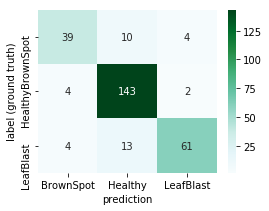

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 403	TRAIN	Loss: 0.2	Correct: 2010/2510(80.08%)
		VALID.:	Loss: 0.38	Correct: 244/280(87.14%)
----------------------------------------


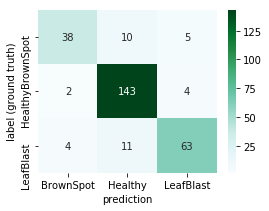

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 404	TRAIN	Loss: 0.55	Correct: 2019/2510(80.44%)
		VALID.:	Loss: 0.27	Correct: 246/280(87.86%)
----------------------------------------


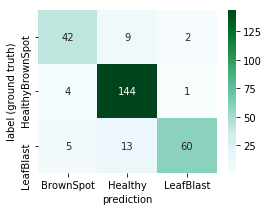

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 405	TRAIN	Loss: 0.83	Correct: 1975/2510(78.69%)
		VALID.:	Loss: 0.31	Correct: 244/280(87.14%)
----------------------------------------


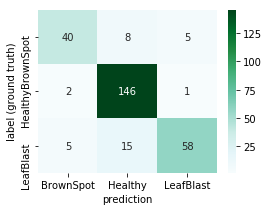

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 406	TRAIN	Loss: 0.36	Correct: 2003/2510(79.8%)
		VALID.:	Loss: 0.37	Correct: 243/280(86.79%)
----------------------------------------


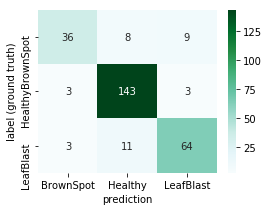

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 407	TRAIN	Loss: 0.61	Correct: 1981/2510(78.92%)
		VALID.:	Loss: 0.43	Correct: 241/280(86.07%)
----------------------------------------


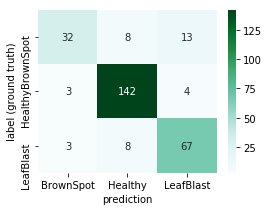

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 408	TRAIN	Loss: 0.51	Correct: 1972/2510(78.57%)
		VALID.:	Loss: 0.4	Correct: 246/280(87.86%)
----------------------------------------


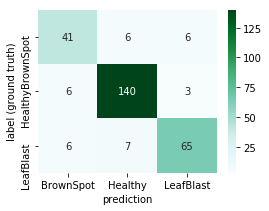

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 409	TRAIN	Loss: 0.4	Correct: 1989/2510(79.24%)
		VALID.:	Loss: 0.51	Correct: 236/280(84.29%)
----------------------------------------


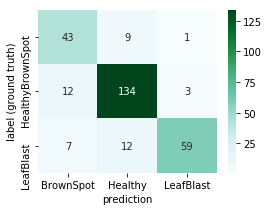

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 410	TRAIN	Loss: 0.55	Correct: 1900/2510(75.7%)
		VALID.:	Loss: 0.36	Correct: 241/280(86.07%)
----------------------------------------


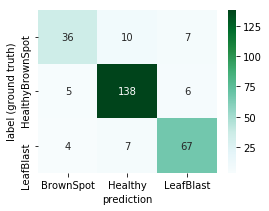

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 411	TRAIN	Loss: 1.19	Correct: 1899/2510(75.66%)
		VALID.:	Loss: 0.61	Correct: 225/280(80.36%)
----------------------------------------


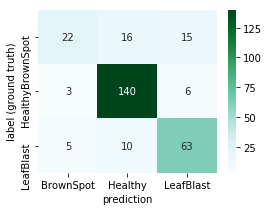

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 412	TRAIN	Loss: 0.56	Correct: 1896/2510(75.54%)
		VALID.:	Loss: 0.47	Correct: 227/280(81.07%)
----------------------------------------


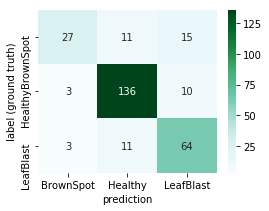

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 413	TRAIN	Loss: 0.6	Correct: 1953/2510(77.81%)
		VALID.:	Loss: 0.33	Correct: 236/280(84.29%)
----------------------------------------


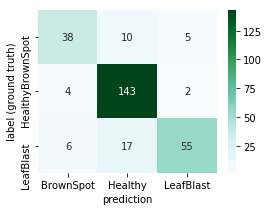

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 414	TRAIN	Loss: 0.42	Correct: 2002/2510(79.76%)
		VALID.:	Loss: 0.32	Correct: 230/280(82.14%)
----------------------------------------


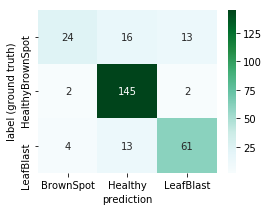

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 415	TRAIN	Loss: 0.49	Correct: 1960/2510(78.09%)
		VALID.:	Loss: 0.72	Correct: 240/280(85.71%)
----------------------------------------


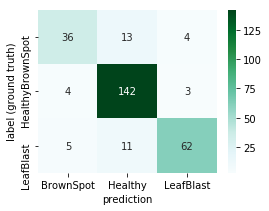

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 416	TRAIN	Loss: 0.52	Correct: 1923/2510(76.61%)
		VALID.:	Loss: 0.37	Correct: 243/280(86.79%)
----------------------------------------


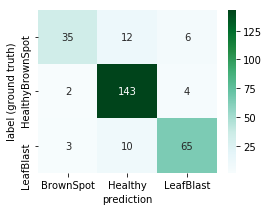

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 417	TRAIN	Loss: 0.3	Correct: 2031/2510(80.92%)
		VALID.:	Loss: 0.49	Correct: 242/280(86.43%)
----------------------------------------


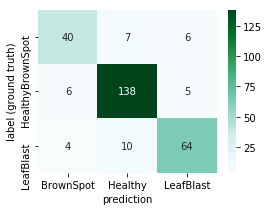

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 418	TRAIN	Loss: 0.85	Correct: 1962/2510(78.17%)
		VALID.:	Loss: 0.43	Correct: 234/280(83.57%)
----------------------------------------


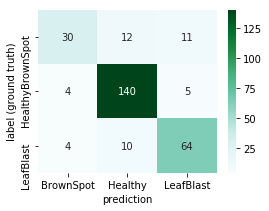

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 419	TRAIN	Loss: 0.98	Correct: 1919/2510(76.45%)
		VALID.:	Loss: 0.52	Correct: 236/280(84.29%)
----------------------------------------


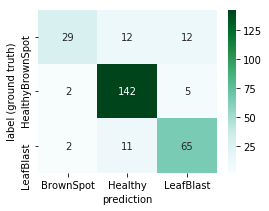

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 420	TRAIN	Loss: 0.63	Correct: 1920/2510(76.49%)
		VALID.:	Loss: 0.42	Correct: 228/280(81.43%)
----------------------------------------


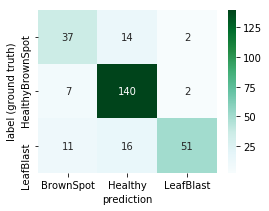

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 421	TRAIN	Loss: 0.67	Correct: 1873/2510(74.62%)
		VALID.:	Loss: 0.51	Correct: 231/280(82.5%)
----------------------------------------


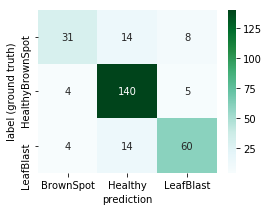

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 422	TRAIN	Loss: 0.49	Correct: 1938/2510(77.21%)
		VALID.:	Loss: 0.38	Correct: 236/280(84.29%)
----------------------------------------


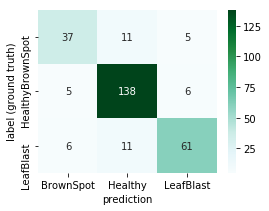

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 423	TRAIN	Loss: 0.78	Correct: 1935/2510(77.09%)
		VALID.:	Loss: 0.43	Correct: 241/280(86.07%)
----------------------------------------


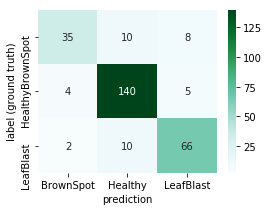

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 424	TRAIN	Loss: 0.64	Correct: 1937/2510(77.17%)
		VALID.:	Loss: 0.4	Correct: 237/280(84.64%)
----------------------------------------


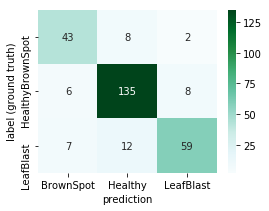

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 425	TRAIN	Loss: 0.3	Correct: 1952/2510(77.77%)
		VALID.:	Loss: 0.45	Correct: 238/280(85.0%)
----------------------------------------


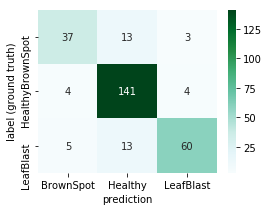

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 426	TRAIN	Loss: 0.58	Correct: 1942/2510(77.37%)
		VALID.:	Loss: 0.38	Correct: 239/280(85.36%)
----------------------------------------


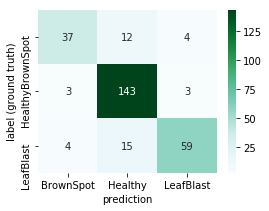

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 427	TRAIN	Loss: 0.66	Correct: 1958/2510(78.01%)
		VALID.:	Loss: 0.4	Correct: 240/280(85.71%)
----------------------------------------


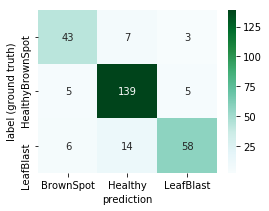

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 428	TRAIN	Loss: 0.95	Correct: 1942/2510(77.37%)
		VALID.:	Loss: 0.57	Correct: 237/280(84.64%)
----------------------------------------


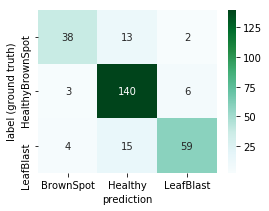

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 429	TRAIN	Loss: 0.57	Correct: 1940/2510(77.29%)
		VALID.:	Loss: 0.38	Correct: 238/280(85.0%)
----------------------------------------


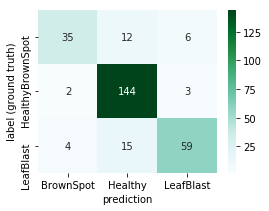

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 430	TRAIN	Loss: 0.46	Correct: 1930/2510(76.89%)
		VALID.:	Loss: 0.47	Correct: 242/280(86.43%)
----------------------------------------


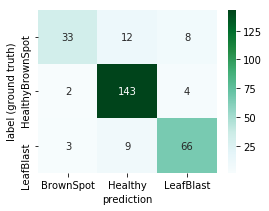

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 431	TRAIN	Loss: 0.65	Correct: 1923/2510(76.61%)
		VALID.:	Loss: 0.43	Correct: 237/280(84.64%)
----------------------------------------


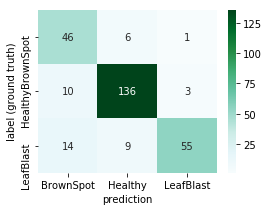

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 432	TRAIN	Loss: 1.63	Correct: 1923/2510(76.61%)
		VALID.:	Loss: 0.44	Correct: 238/280(85.0%)
----------------------------------------


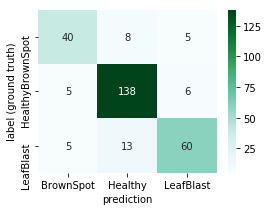

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 433	TRAIN	Loss: 0.64	Correct: 1969/2510(78.45%)
		VALID.:	Loss: 0.5	Correct: 240/280(85.71%)
----------------------------------------


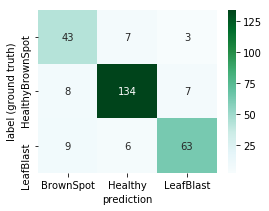

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 434	TRAIN	Loss: 0.5	Correct: 1931/2510(76.93%)
		VALID.:	Loss: 0.45	Correct: 244/280(87.14%)
----------------------------------------


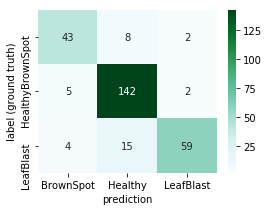

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 435	TRAIN	Loss: 0.85	Correct: 1947/2510(77.57%)
		VALID.:	Loss: 0.41	Correct: 242/280(86.43%)
----------------------------------------


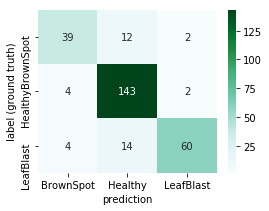

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 436	TRAIN	Loss: 1.12	Correct: 1968/2510(78.41%)
		VALID.:	Loss: 0.32	Correct: 245/280(87.5%)
----------------------------------------


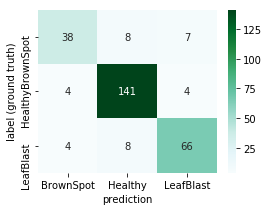

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 437	TRAIN	Loss: 1.05	Correct: 1955/2510(77.89%)
		VALID.:	Loss: 0.49	Correct: 240/280(85.71%)
----------------------------------------


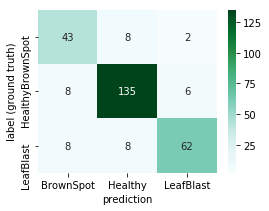

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 438	TRAIN	Loss: 0.23	Correct: 1970/2510(78.49%)
		VALID.:	Loss: 0.33	Correct: 246/280(87.86%)
----------------------------------------


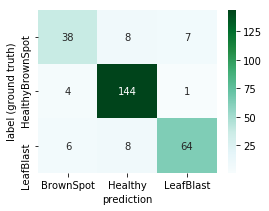

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 439	TRAIN	Loss: 0.62	Correct: 1914/2510(76.25%)
		VALID.:	Loss: 0.4	Correct: 245/280(87.5%)
----------------------------------------


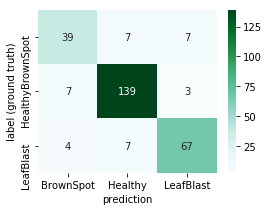

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 440	TRAIN	Loss: 0.83	Correct: 1968/2510(78.41%)
		VALID.:	Loss: 0.28	Correct: 244/280(87.14%)
----------------------------------------


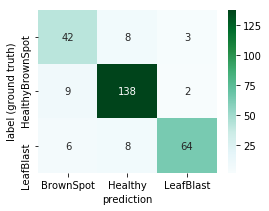

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 441	TRAIN	Loss: 0.66	Correct: 1987/2510(79.16%)
		VALID.:	Loss: 0.52	Correct: 240/280(85.71%)
----------------------------------------


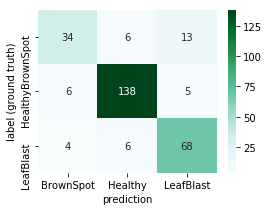

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 442	TRAIN	Loss: 0.47	Correct: 1905/2510(75.9%)
		VALID.:	Loss: 0.41	Correct: 243/280(86.79%)
----------------------------------------


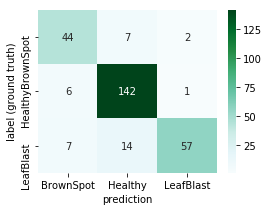

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 443	TRAIN	Loss: 0.45	Correct: 1994/2510(79.44%)
		VALID.:	Loss: 0.38	Correct: 249/280(88.93%)
----------------------------------------


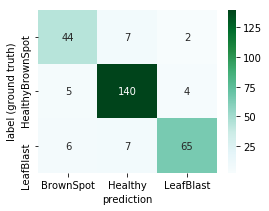

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 444	TRAIN	Loss: 0.47	Correct: 1982/2510(78.96%)
		VALID.:	Loss: 0.42	Correct: 248/280(88.57%)
----------------------------------------


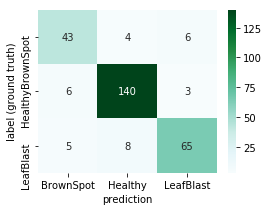

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 445	TRAIN	Loss: 0.16	Correct: 1981/2510(78.92%)
		VALID.:	Loss: 0.36	Correct: 247/280(88.21%)
----------------------------------------


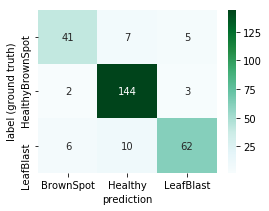

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 446	TRAIN	Loss: 0.4	Correct: 1988/2510(79.2%)
		VALID.:	Loss: 0.32	Correct: 248/280(88.57%)
----------------------------------------


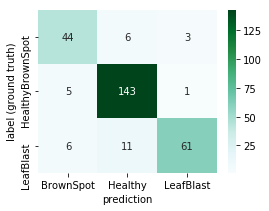

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 447	TRAIN	Loss: 0.52	Correct: 1984/2510(79.04%)
		VALID.:	Loss: 0.46	Correct: 244/280(87.14%)
----------------------------------------


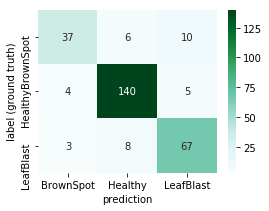

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 448	TRAIN	Loss: 0.32	Correct: 1946/2510(77.53%)
		VALID.:	Loss: 0.6	Correct: 233/280(83.21%)
----------------------------------------


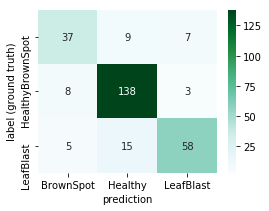

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 449	TRAIN	Loss: 0.14	Correct: 1992/2510(79.36%)
		VALID.:	Loss: 0.45	Correct: 240/280(85.71%)
----------------------------------------


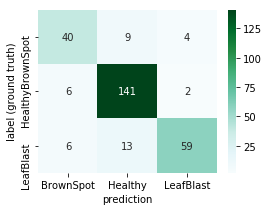

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 450	TRAIN	Loss: 0.56	Correct: 1959/2510(78.05%)
		VALID.:	Loss: 0.38	Correct: 248/280(88.57%)
----------------------------------------


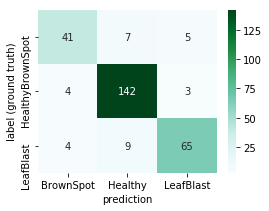

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 451	TRAIN	Loss: 0.68	Correct: 1973/2510(78.61%)
		VALID.:	Loss: 0.4	Correct: 242/280(86.43%)
----------------------------------------


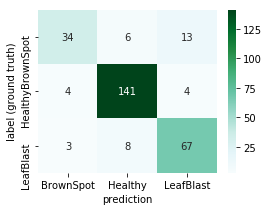

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 452	TRAIN	Loss: 0.33	Correct: 1977/2510(78.76%)
		VALID.:	Loss: 0.3	Correct: 242/280(86.43%)
----------------------------------------


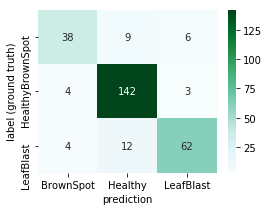

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 453	TRAIN	Loss: 0.2	Correct: 2007/2510(79.96%)
		VALID.:	Loss: 0.33	Correct: 245/280(87.5%)
----------------------------------------


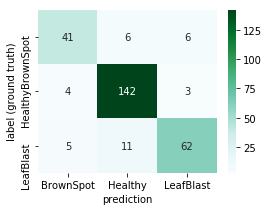

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 454	TRAIN	Loss: 0.3	Correct: 1984/2510(79.04%)
		VALID.:	Loss: 0.32	Correct: 242/280(86.43%)
----------------------------------------


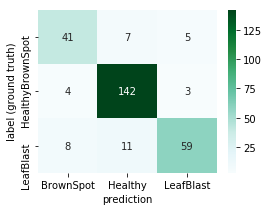

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 455	TRAIN	Loss: 0.33	Correct: 2003/2510(79.8%)
		VALID.:	Loss: 0.28	Correct: 245/280(87.5%)
----------------------------------------


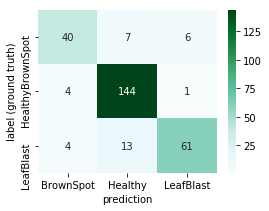

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 456	TRAIN	Loss: 0.61	Correct: 2014/2510(80.24%)
		VALID.:	Loss: 0.48	Correct: 242/280(86.43%)
----------------------------------------


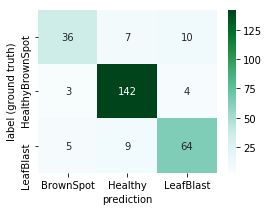

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 457	TRAIN	Loss: 0.37	Correct: 1944/2510(77.45%)
		VALID.:	Loss: 0.36	Correct: 243/280(86.79%)
----------------------------------------


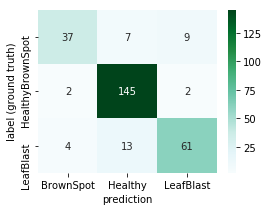

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 458	TRAIN	Loss: 0.78	Correct: 2006/2510(79.92%)
		VALID.:	Loss: 0.31	Correct: 244/280(87.14%)
----------------------------------------


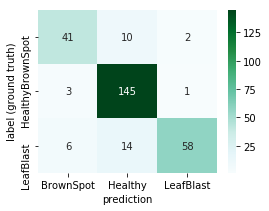

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 459	TRAIN	Loss: 0.32	Correct: 1996/2510(79.52%)
		VALID.:	Loss: 0.61	Correct: 224/280(80.0%)
----------------------------------------


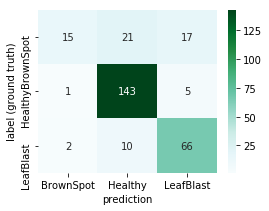

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 460	TRAIN	Loss: 0.77	Correct: 2011/2510(80.12%)
		VALID.:	Loss: 0.36	Correct: 246/280(87.86%)
----------------------------------------


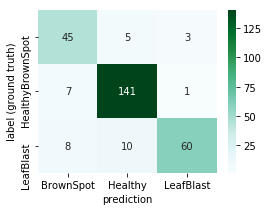

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 461	TRAIN	Loss: 0.68	Correct: 1921/2510(76.53%)
		VALID.:	Loss: 0.34	Correct: 247/280(88.21%)
----------------------------------------


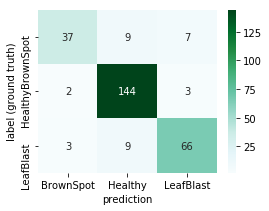

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 462	TRAIN	Loss: 0.8	Correct: 1989/2510(79.24%)
		VALID.:	Loss: 0.4	Correct: 239/280(85.36%)
----------------------------------------


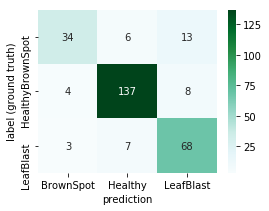

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 463	TRAIN	Loss: 0.72	Correct: 1981/2510(78.92%)
		VALID.:	Loss: 0.44	Correct: 242/280(86.43%)
----------------------------------------


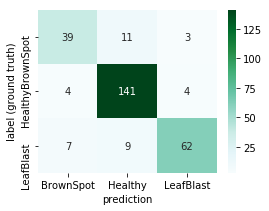

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 464	TRAIN	Loss: 0.42	Correct: 1933/2510(77.01%)
		VALID.:	Loss: 0.45	Correct: 237/280(84.64%)
----------------------------------------


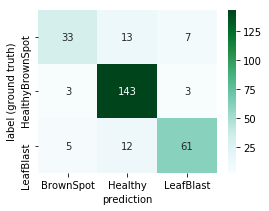

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 465	TRAIN	Loss: 0.39	Correct: 1949/2510(77.65%)
		VALID.:	Loss: 0.38	Correct: 233/280(83.21%)
----------------------------------------


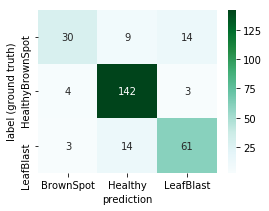

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 466	TRAIN	Loss: 0.19	Correct: 1996/2510(79.52%)
		VALID.:	Loss: 0.35	Correct: 245/280(87.5%)
----------------------------------------


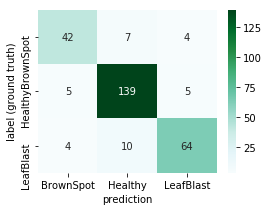

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 467	TRAIN	Loss: 0.58	Correct: 1980/2510(78.88%)
		VALID.:	Loss: 0.4	Correct: 243/280(86.79%)
----------------------------------------


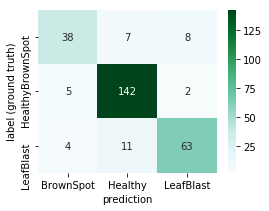

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 468	TRAIN	Loss: 0.15	Correct: 1985/2510(79.08%)
		VALID.:	Loss: 0.35	Correct: 247/280(88.21%)
----------------------------------------


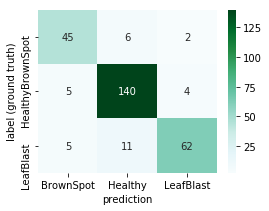

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 469	TRAIN	Loss: 0.69	Correct: 1994/2510(79.44%)
		VALID.:	Loss: 0.38	Correct: 243/280(86.79%)
----------------------------------------


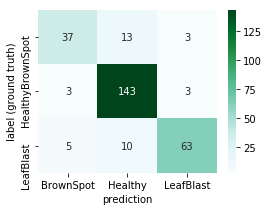

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 470	TRAIN	Loss: 0.59	Correct: 1963/2510(78.21%)
		VALID.:	Loss: 0.45	Correct: 233/280(83.21%)
----------------------------------------


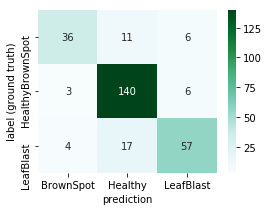

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 471	TRAIN	Loss: 0.72	Correct: 2004/2510(79.84%)
		VALID.:	Loss: 0.49	Correct: 244/280(87.14%)
----------------------------------------


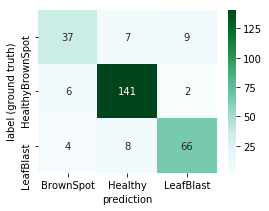

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 472	TRAIN	Loss: 0.78	Correct: 1986/2510(79.12%)
		VALID.:	Loss: 0.37	Correct: 238/280(85.0%)
----------------------------------------


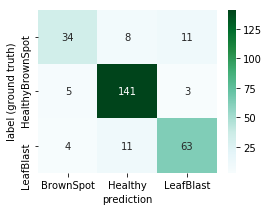

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 473	TRAIN	Loss: 0.48	Correct: 1992/2510(79.36%)
		VALID.:	Loss: 0.41	Correct: 246/280(87.86%)
----------------------------------------


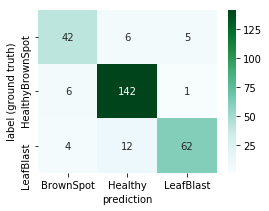

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 474	TRAIN	Loss: 0.71	Correct: 1951/2510(77.73%)
		VALID.:	Loss: 0.44	Correct: 244/280(87.14%)
----------------------------------------


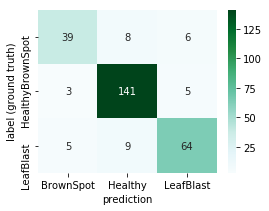

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 475	TRAIN	Loss: 0.9	Correct: 1919/2510(76.45%)
		VALID.:	Loss: 0.48	Correct: 238/280(85.0%)
----------------------------------------


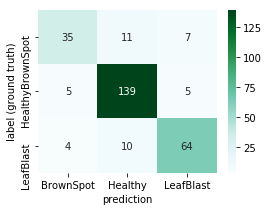

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 476	TRAIN	Loss: 0.65	Correct: 1942/2510(77.37%)
		VALID.:	Loss: 0.4	Correct: 241/280(86.07%)
----------------------------------------


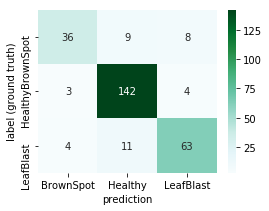

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 477	TRAIN	Loss: 0.55	Correct: 1947/2510(77.57%)
		VALID.:	Loss: 0.48	Correct: 231/280(82.5%)
----------------------------------------


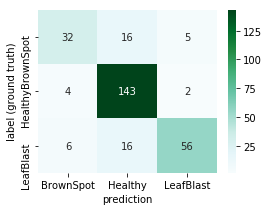

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 478	TRAIN	Loss: 1.06	Correct: 1979/2510(78.84%)
		VALID.:	Loss: 0.41	Correct: 237/280(84.64%)
----------------------------------------


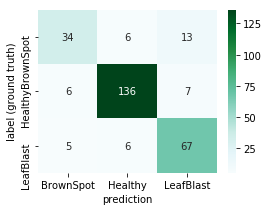

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 479	TRAIN	Loss: 0.4	Correct: 1948/2510(77.61%)
		VALID.:	Loss: 0.36	Correct: 243/280(86.79%)
----------------------------------------


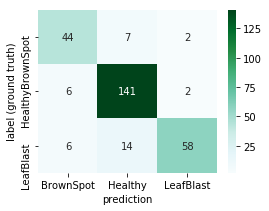

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 480	TRAIN	Loss: 0.5	Correct: 1997/2510(79.56%)
		VALID.:	Loss: 0.38	Correct: 238/280(85.0%)
----------------------------------------


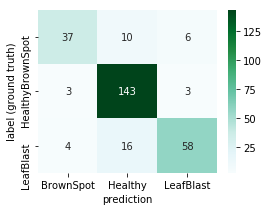

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 481	TRAIN	Loss: 0.3	Correct: 1977/2510(78.76%)
		VALID.:	Loss: 0.25	Correct: 249/280(88.93%)
----------------------------------------


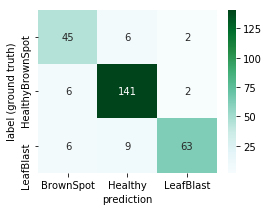

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 482	TRAIN	Loss: 0.21	Correct: 1967/2510(78.37%)
		VALID.:	Loss: 0.48	Correct: 243/280(86.79%)
----------------------------------------


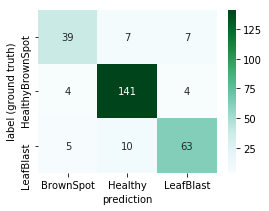

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 483	TRAIN	Loss: 0.63	Correct: 1982/2510(78.96%)
		VALID.:	Loss: 0.47	Correct: 237/280(84.64%)
----------------------------------------


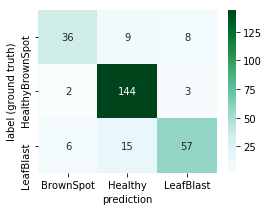

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 484	TRAIN	Loss: 0.37	Correct: 1982/2510(78.96%)
		VALID.:	Loss: 0.42	Correct: 235/280(83.93%)
----------------------------------------


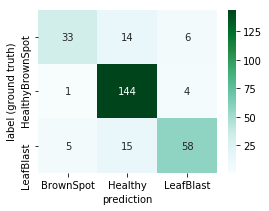

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 485	TRAIN	Loss: 0.6	Correct: 1970/2510(78.49%)
		VALID.:	Loss: 0.55	Correct: 237/280(84.64%)
----------------------------------------


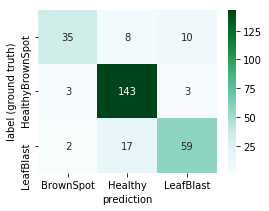

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 486	TRAIN	Loss: 0.47	Correct: 1981/2510(78.92%)
		VALID.:	Loss: 0.4	Correct: 244/280(87.14%)
----------------------------------------


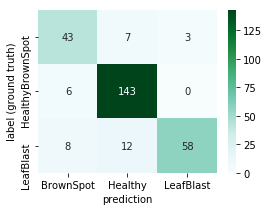

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 487	TRAIN	Loss: 1.44	Correct: 1975/2510(78.69%)
		VALID.:	Loss: 0.32	Correct: 242/280(86.43%)
----------------------------------------


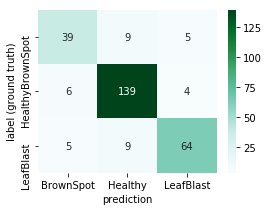

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 488	TRAIN	Loss: 0.65	Correct: 1932/2510(76.97%)
		VALID.:	Loss: 0.44	Correct: 236/280(84.29%)
----------------------------------------


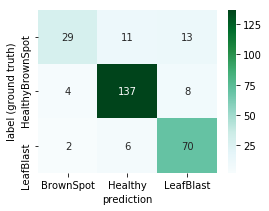

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 489	TRAIN	Loss: 0.34	Correct: 1964/2510(78.25%)
		VALID.:	Loss: 0.36	Correct: 240/280(85.71%)
----------------------------------------


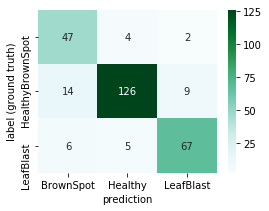

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 490	TRAIN	Loss: 0.59	Correct: 1932/2510(76.97%)
		VALID.:	Loss: 0.48	Correct: 241/280(86.07%)
----------------------------------------


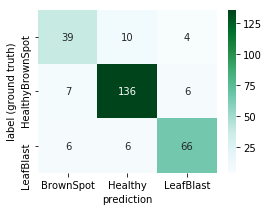

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 491	TRAIN	Loss: 0.43	Correct: 1935/2510(77.09%)
		VALID.:	Loss: 0.4	Correct: 235/280(83.93%)
----------------------------------------


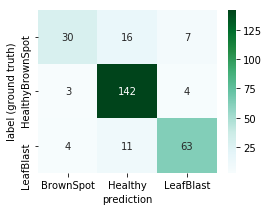

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 492	TRAIN	Loss: 0.14	Correct: 1908/2510(76.02%)
		VALID.:	Loss: 0.57	Correct: 235/280(83.93%)
----------------------------------------


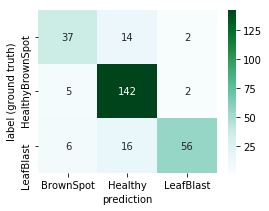

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 493	TRAIN	Loss: 0.51	Correct: 1979/2510(78.84%)
		VALID.:	Loss: 0.54	Correct: 238/280(85.0%)
----------------------------------------


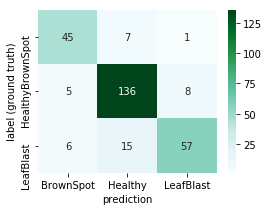

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 494	TRAIN	Loss: 0.47	Correct: 1966/2510(78.33%)
		VALID.:	Loss: 0.37	Correct: 244/280(87.14%)
----------------------------------------


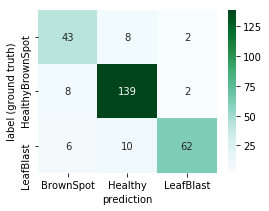

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 495	TRAIN	Loss: 0.24	Correct: 1977/2510(78.76%)
		VALID.:	Loss: 0.31	Correct: 250/280(89.29%)
----------------------------------------


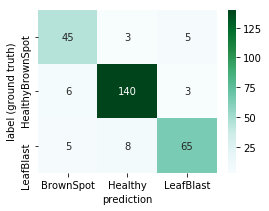

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 496	TRAIN	Loss: 0.36	Correct: 1968/2510(78.41%)
		VALID.:	Loss: 0.42	Correct: 234/280(83.57%)
----------------------------------------


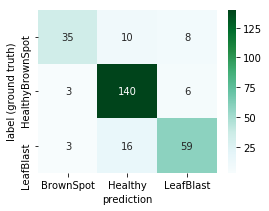

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 497	TRAIN	Loss: 0.3	Correct: 1949/2510(77.65%)
		VALID.:	Loss: 0.39	Correct: 243/280(86.79%)
----------------------------------------


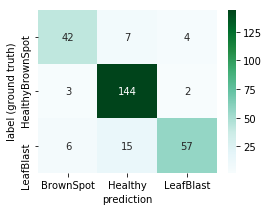

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 498	TRAIN	Loss: 0.94	Correct: 2000/2510(79.68%)
		VALID.:	Loss: 0.33	Correct: 241/280(86.07%)
----------------------------------------


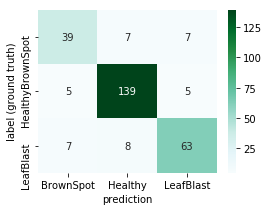

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 499	TRAIN	Loss: 0.28	Correct: 2003/2510(79.8%)
		VALID.:	Loss: 0.44	Correct: 246/280(87.86%)
----------------------------------------


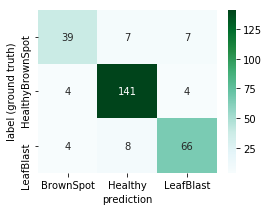

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 500	TRAIN	Loss: 0.74	Correct: 1997/2510(79.56%)
		VALID.:	Loss: 0.45	Correct: 239/280(85.36%)
----------------------------------------


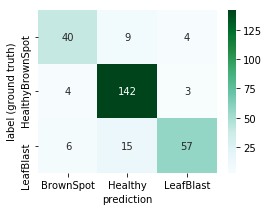

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 501	TRAIN	Loss: 0.55	Correct: 1962/2510(78.17%)
		VALID.:	Loss: 0.39	Correct: 240/280(85.71%)
----------------------------------------


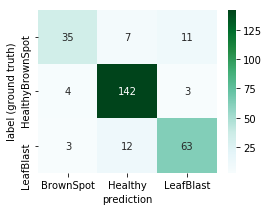

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 502	TRAIN	Loss: 0.93	Correct: 1948/2510(77.61%)
		VALID.:	Loss: 0.44	Correct: 240/280(85.71%)
----------------------------------------


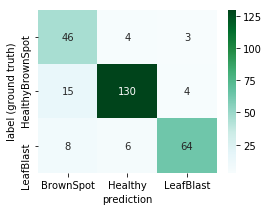

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 503	TRAIN	Loss: 0.92	Correct: 1932/2510(76.97%)
		VALID.:	Loss: 0.38	Correct: 242/280(86.43%)
----------------------------------------


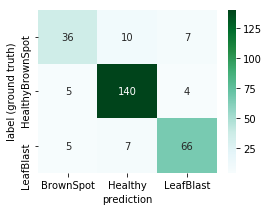

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 504	TRAIN	Loss: 0.23	Correct: 1953/2510(77.81%)
		VALID.:	Loss: 0.31	Correct: 246/280(87.86%)
----------------------------------------


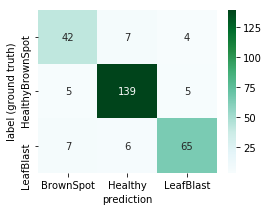

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 505	TRAIN	Loss: 0.89	Correct: 1966/2510(78.33%)
		VALID.:	Loss: 0.43	Correct: 239/280(85.36%)
----------------------------------------


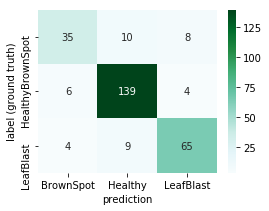

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 506	TRAIN	Loss: 0.44	Correct: 1947/2510(77.57%)
		VALID.:	Loss: 0.49	Correct: 235/280(83.93%)
----------------------------------------


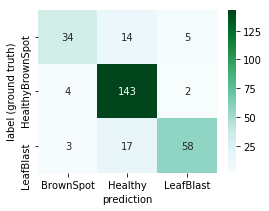

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 507	TRAIN	Loss: 0.87	Correct: 2007/2510(79.96%)
		VALID.:	Loss: 0.35	Correct: 244/280(87.14%)
----------------------------------------


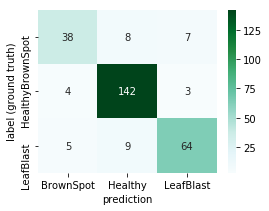

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 508	TRAIN	Loss: 0.43	Correct: 2008/2510(80.0%)
		VALID.:	Loss: 0.42	Correct: 241/280(86.07%)
----------------------------------------


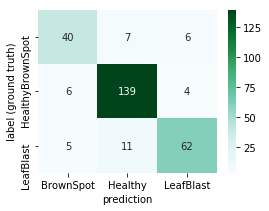

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 509	TRAIN	Loss: 0.44	Correct: 1992/2510(79.36%)
		VALID.:	Loss: 0.45	Correct: 243/280(86.79%)
----------------------------------------


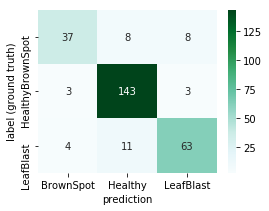

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 510	TRAIN	Loss: 0.52	Correct: 1996/2510(79.52%)
		VALID.:	Loss: 0.46	Correct: 244/280(87.14%)
----------------------------------------


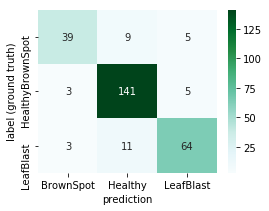

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 511	TRAIN	Loss: 0.29	Correct: 1997/2510(79.56%)
		VALID.:	Loss: 0.43	Correct: 246/280(87.86%)
----------------------------------------


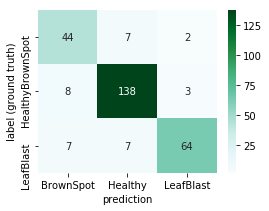

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 512	TRAIN	Loss: 0.75	Correct: 1983/2510(79.0%)
		VALID.:	Loss: 0.51	Correct: 225/280(80.36%)
----------------------------------------


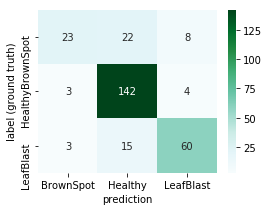

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 513	TRAIN	Loss: 0.93	Correct: 1942/2510(77.37%)
		VALID.:	Loss: 0.41	Correct: 232/280(82.86%)
----------------------------------------


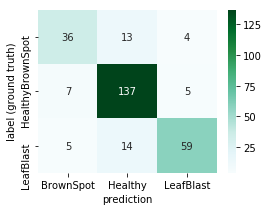

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 514	TRAIN	Loss: 0.23	Correct: 1955/2510(77.89%)
		VALID.:	Loss: 0.32	Correct: 245/280(87.5%)
----------------------------------------


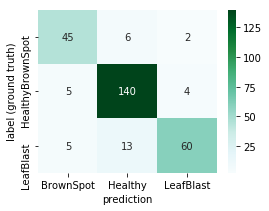

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 515	TRAIN	Loss: 0.56	Correct: 1973/2510(78.61%)
		VALID.:	Loss: 0.4	Correct: 239/280(85.36%)
----------------------------------------


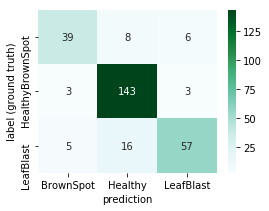

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 516	TRAIN	Loss: 0.76	Correct: 1993/2510(79.4%)
		VALID.:	Loss: 0.34	Correct: 244/280(87.14%)
----------------------------------------


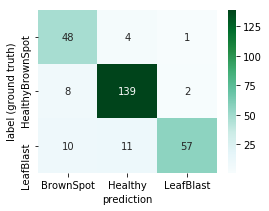

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 517	TRAIN	Loss: 0.64	Correct: 1986/2510(79.12%)
		VALID.:	Loss: 0.49	Correct: 237/280(84.64%)
----------------------------------------


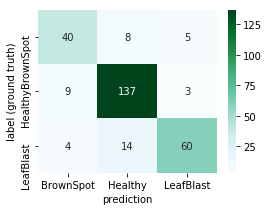

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 518	TRAIN	Loss: 0.52	Correct: 2000/2510(79.68%)
		VALID.:	Loss: 0.38	Correct: 247/280(88.21%)
----------------------------------------


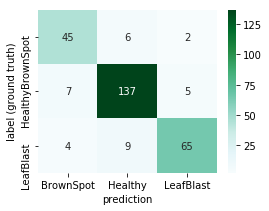

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 519	TRAIN	Loss: 0.37	Correct: 2001/2510(79.72%)
		VALID.:	Loss: 0.31	Correct: 243/280(86.79%)
----------------------------------------


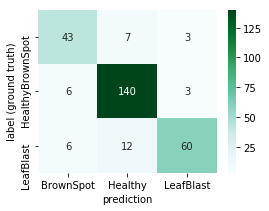

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 520	TRAIN	Loss: 0.25	Correct: 1980/2510(78.88%)
		VALID.:	Loss: 0.44	Correct: 239/280(85.36%)
----------------------------------------


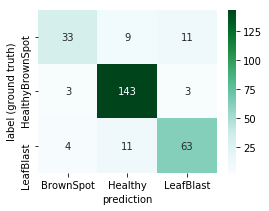

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 521	TRAIN	Loss: 0.41	Correct: 2012/2510(80.16%)
		VALID.:	Loss: 0.32	Correct: 243/280(86.79%)
----------------------------------------


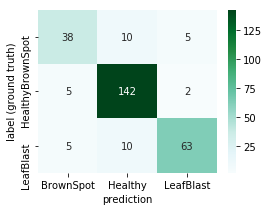

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 522	TRAIN	Loss: 1.17	Correct: 1988/2510(79.2%)
		VALID.:	Loss: 0.38	Correct: 241/280(86.07%)
----------------------------------------


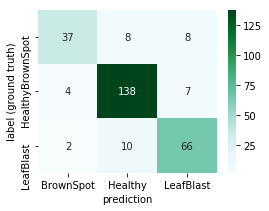

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 523	TRAIN	Loss: 0.63	Correct: 2015/2510(80.28%)
		VALID.:	Loss: 0.39	Correct: 242/280(86.43%)
----------------------------------------


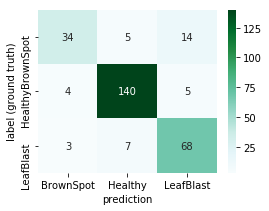

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 524	TRAIN	Loss: 1.17	Correct: 1971/2510(78.53%)
		VALID.:	Loss: 0.44	Correct: 250/280(89.29%)
----------------------------------------


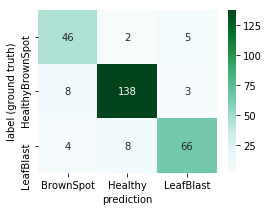

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 525	TRAIN	Loss: 0.38	Correct: 1983/2510(79.0%)
		VALID.:	Loss: 0.45	Correct: 238/280(85.0%)
----------------------------------------


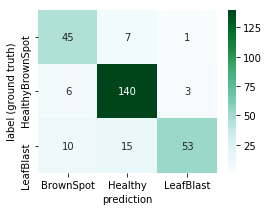

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 526	TRAIN	Loss: 0.45	Correct: 2000/2510(79.68%)
		VALID.:	Loss: 0.45	Correct: 242/280(86.43%)
----------------------------------------


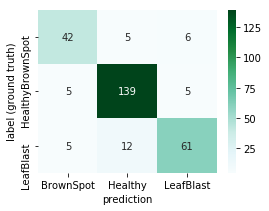

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 527	TRAIN	Loss: 1.13	Correct: 1989/2510(79.24%)
		VALID.:	Loss: 0.5	Correct: 245/280(87.5%)
----------------------------------------


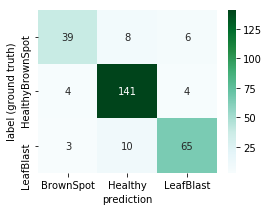

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 528	TRAIN	Loss: 0.41	Correct: 2002/2510(79.76%)
		VALID.:	Loss: 0.44	Correct: 248/280(88.57%)
----------------------------------------


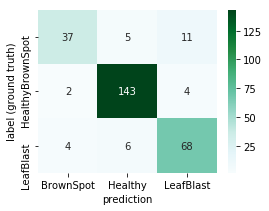

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 529	TRAIN	Loss: 0.29	Correct: 1982/2510(78.96%)
		VALID.:	Loss: 0.34	Correct: 249/280(88.93%)
----------------------------------------


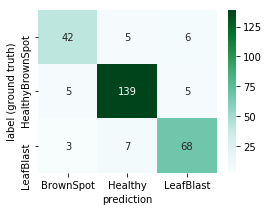

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 530	TRAIN	Loss: 0.65	Correct: 1963/2510(78.21%)
		VALID.:	Loss: 0.37	Correct: 231/280(82.5%)
----------------------------------------


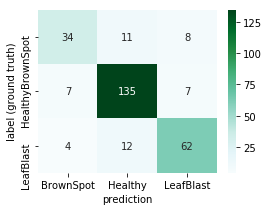

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 531	TRAIN	Loss: 0.34	Correct: 1954/2510(77.85%)
		VALID.:	Loss: 0.53	Correct: 229/280(81.79%)
----------------------------------------


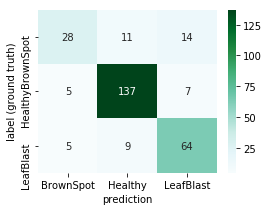

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 532	TRAIN	Loss: 0.47	Correct: 1946/2510(77.53%)
		VALID.:	Loss: 0.53	Correct: 241/280(86.07%)
----------------------------------------


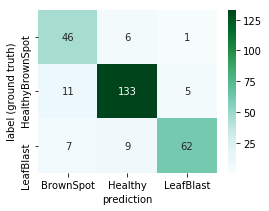

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 533	TRAIN	Loss: 0.61	Correct: 1951/2510(77.73%)
		VALID.:	Loss: 0.36	Correct: 240/280(85.71%)
----------------------------------------


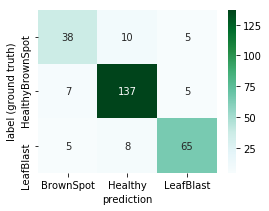

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 534	TRAIN	Loss: 0.65	Correct: 1960/2510(78.09%)
		VALID.:	Loss: 0.41	Correct: 237/280(84.64%)
----------------------------------------


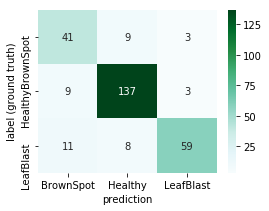

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 535	TRAIN	Loss: 0.5	Correct: 1957/2510(77.97%)
		VALID.:	Loss: 0.51	Correct: 241/280(86.07%)
----------------------------------------


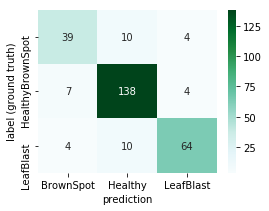

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 536	TRAIN	Loss: 0.62	Correct: 1948/2510(77.61%)
		VALID.:	Loss: 0.44	Correct: 241/280(86.07%)
----------------------------------------


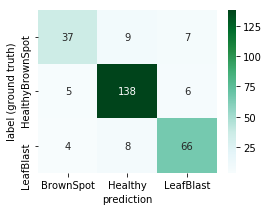

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 537	TRAIN	Loss: 0.37	Correct: 1967/2510(78.37%)
		VALID.:	Loss: 0.39	Correct: 244/280(87.14%)
----------------------------------------


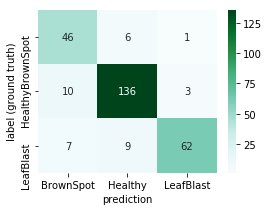

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 538	TRAIN	Loss: 0.3	Correct: 1970/2510(78.49%)
		VALID.:	Loss: 0.46	Correct: 240/280(85.71%)
----------------------------------------


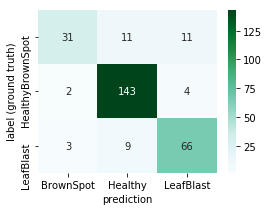

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 539	TRAIN	Loss: 0.48	Correct: 1912/2510(76.18%)
		VALID.:	Loss: 0.45	Correct: 241/280(86.07%)
----------------------------------------


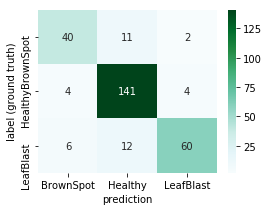

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 540	TRAIN	Loss: 0.33	Correct: 1967/2510(78.37%)
		VALID.:	Loss: 0.36	Correct: 247/280(88.21%)
----------------------------------------


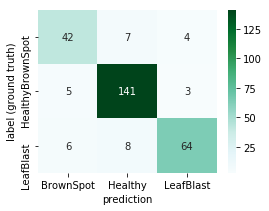

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 541	TRAIN	Loss: 0.38	Correct: 2015/2510(80.28%)
		VALID.:	Loss: 0.42	Correct: 244/280(87.14%)
----------------------------------------


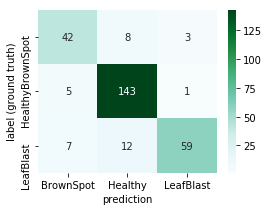

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 542	TRAIN	Loss: 0.5	Correct: 1980/2510(78.88%)
		VALID.:	Loss: 0.54	Correct: 243/280(86.79%)
----------------------------------------


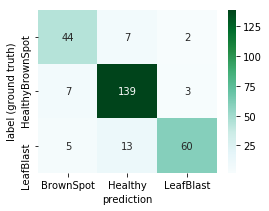

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 543	TRAIN	Loss: 0.62	Correct: 1992/2510(79.36%)
		VALID.:	Loss: 0.26	Correct: 244/280(87.14%)
----------------------------------------


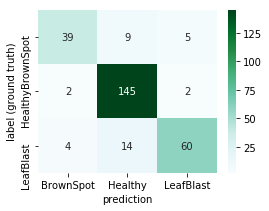

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 544	TRAIN	Loss: 0.21	Correct: 2013/2510(80.2%)
		VALID.:	Loss: 0.3	Correct: 239/280(85.36%)
----------------------------------------


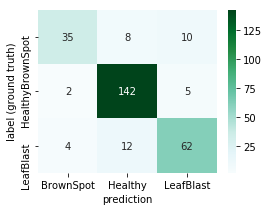

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 545	TRAIN	Loss: 0.43	Correct: 2013/2510(80.2%)
		VALID.:	Loss: 0.46	Correct: 240/280(85.71%)
----------------------------------------


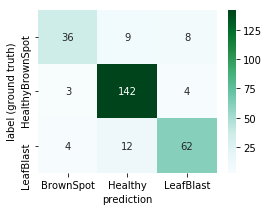

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 546	TRAIN	Loss: 0.12	Correct: 1989/2510(79.24%)
		VALID.:	Loss: 0.42	Correct: 243/280(86.79%)
----------------------------------------


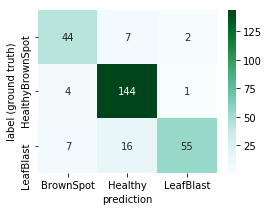

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 547	TRAIN	Loss: 0.28	Correct: 2018/2510(80.4%)
		VALID.:	Loss: 0.47	Correct: 239/280(85.36%)
----------------------------------------


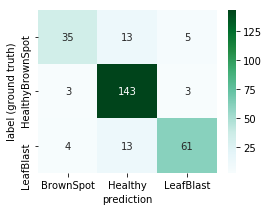

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 548	TRAIN	Loss: 0.69	Correct: 2009/2510(80.04%)
		VALID.:	Loss: 0.41	Correct: 246/280(87.86%)
----------------------------------------


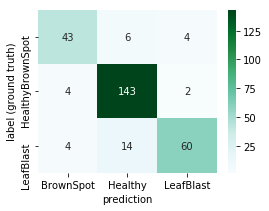

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 549	TRAIN	Loss: 0.95	Correct: 1993/2510(79.4%)
		VALID.:	Loss: 0.42	Correct: 240/280(85.71%)
----------------------------------------


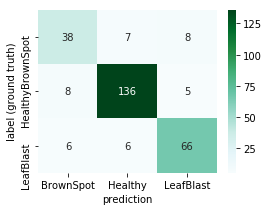

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 550	TRAIN	Loss: 0.99	Correct: 1942/2510(77.37%)
		VALID.:	Loss: 0.33	Correct: 235/280(83.93%)
----------------------------------------


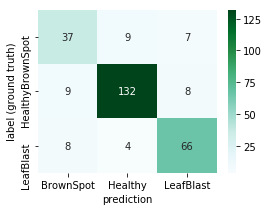

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 551	TRAIN	Loss: 0.78	Correct: 1955/2510(77.89%)
		VALID.:	Loss: 0.5	Correct: 241/280(86.07%)
----------------------------------------


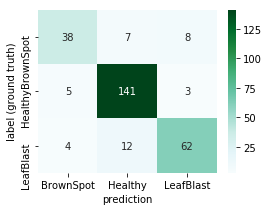

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 552	TRAIN	Loss: 0.26	Correct: 2011/2510(80.12%)
		VALID.:	Loss: 0.39	Correct: 249/280(88.93%)
----------------------------------------


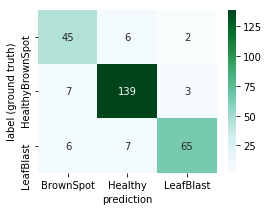

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 553	TRAIN	Loss: 0.25	Correct: 1991/2510(79.32%)
		VALID.:	Loss: 0.32	Correct: 250/280(89.29%)
----------------------------------------


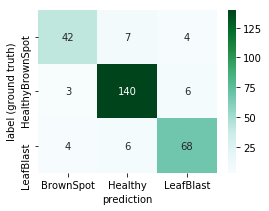

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 554	TRAIN	Loss: 0.3	Correct: 1962/2510(78.17%)
		VALID.:	Loss: 0.42	Correct: 241/280(86.07%)
----------------------------------------


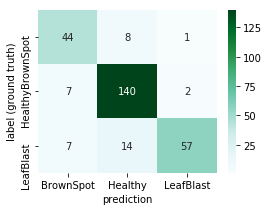

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 555	TRAIN	Loss: 1.06	Correct: 1991/2510(79.32%)
		VALID.:	Loss: 0.4	Correct: 238/280(85.0%)
----------------------------------------


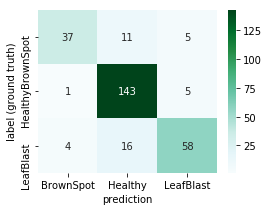

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 556	TRAIN	Loss: 0.38	Correct: 1981/2510(78.92%)
		VALID.:	Loss: 0.44	Correct: 242/280(86.43%)
----------------------------------------


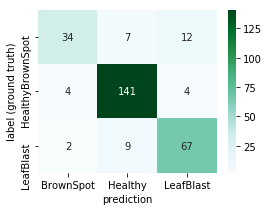

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 557	TRAIN	Loss: 0.97	Correct: 1990/2510(79.28%)
		VALID.:	Loss: 0.45	Correct: 236/280(84.29%)
----------------------------------------


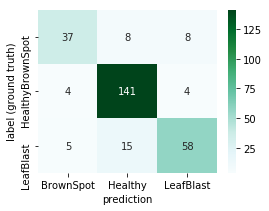

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 558	TRAIN	Loss: 1.11	Correct: 2020/2510(80.48%)
		VALID.:	Loss: 0.58	Correct: 222/280(79.29%)
----------------------------------------


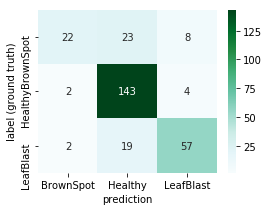

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 559	TRAIN	Loss: 0.29	Correct: 1957/2510(77.97%)
		VALID.:	Loss: 0.41	Correct: 245/280(87.5%)
----------------------------------------


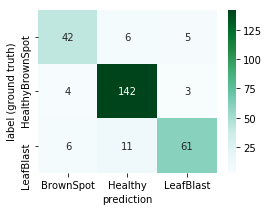

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 560	TRAIN	Loss: 0.83	Correct: 1985/2510(79.08%)
		VALID.:	Loss: 0.43	Correct: 241/280(86.07%)
----------------------------------------


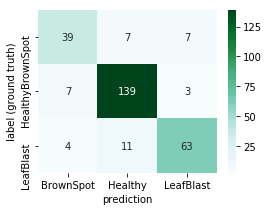

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 561	TRAIN	Loss: 0.94	Correct: 1989/2510(79.24%)
		VALID.:	Loss: 0.54	Correct: 240/280(85.71%)
----------------------------------------


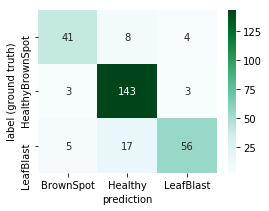

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 562	TRAIN	Loss: 0.26	Correct: 2017/2510(80.36%)
		VALID.:	Loss: 0.45	Correct: 243/280(86.79%)
----------------------------------------


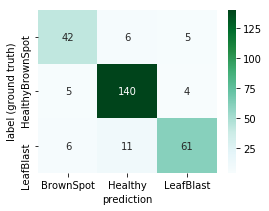

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 563	TRAIN	Loss: 0.2	Correct: 2023/2510(80.6%)
		VALID.:	Loss: 0.38	Correct: 246/280(87.86%)
----------------------------------------


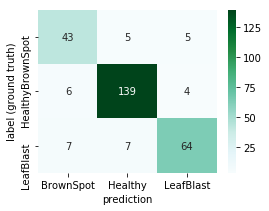

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 564	TRAIN	Loss: 0.7	Correct: 2000/2510(79.68%)
		VALID.:	Loss: 0.46	Correct: 241/280(86.07%)
----------------------------------------


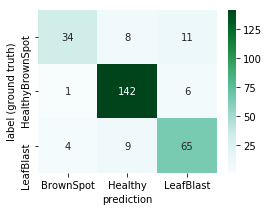

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 565	TRAIN	Loss: 0.57	Correct: 1997/2510(79.56%)
		VALID.:	Loss: 0.3	Correct: 245/280(87.5%)
----------------------------------------


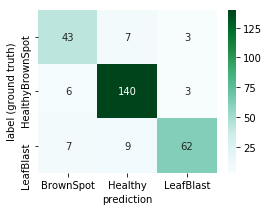

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 566	TRAIN	Loss: 0.61	Correct: 2011/2510(80.12%)
		VALID.:	Loss: 0.3	Correct: 244/280(87.14%)
----------------------------------------


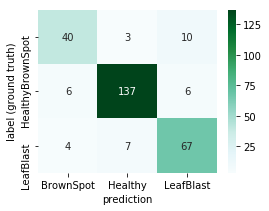

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 567	TRAIN	Loss: 0.57	Correct: 1982/2510(78.96%)
		VALID.:	Loss: 0.39	Correct: 245/280(87.5%)
----------------------------------------


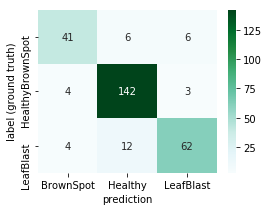

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 568	TRAIN	Loss: 0.29	Correct: 2012/2510(80.16%)
		VALID.:	Loss: 0.31	Correct: 244/280(87.14%)
----------------------------------------


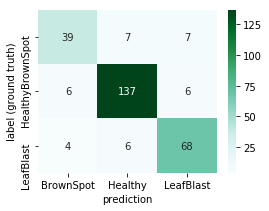

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 569	TRAIN	Loss: 0.56	Correct: 1980/2510(78.88%)
		VALID.:	Loss: 0.45	Correct: 242/280(86.43%)
----------------------------------------


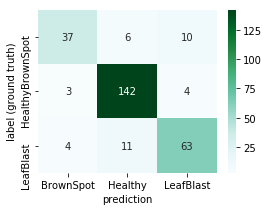

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 570	TRAIN	Loss: 0.44	Correct: 1994/2510(79.44%)
		VALID.:	Loss: 0.34	Correct: 245/280(87.5%)
----------------------------------------


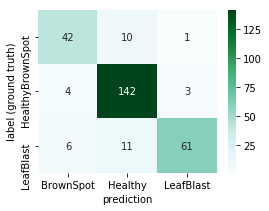

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 571	TRAIN	Loss: 0.62	Correct: 2009/2510(80.04%)
		VALID.:	Loss: 0.32	Correct: 246/280(87.86%)
----------------------------------------


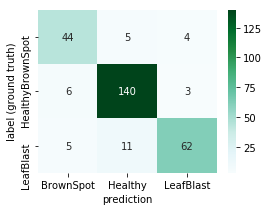

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 572	TRAIN	Loss: 0.69	Correct: 2000/2510(79.68%)
		VALID.:	Loss: 0.35	Correct: 249/280(88.93%)
----------------------------------------


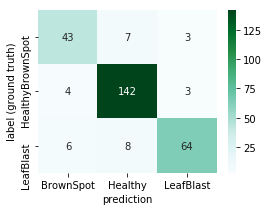

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 573	TRAIN	Loss: 0.79	Correct: 2003/2510(79.8%)
		VALID.:	Loss: 0.41	Correct: 246/280(87.86%)
----------------------------------------


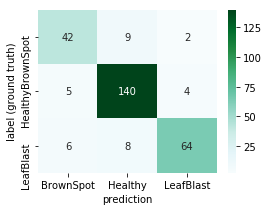

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 574	TRAIN	Loss: 0.93	Correct: 1998/2510(79.6%)
		VALID.:	Loss: 0.38	Correct: 246/280(87.86%)
----------------------------------------


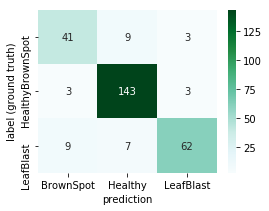

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 575	TRAIN	Loss: 0.5	Correct: 2003/2510(79.8%)
		VALID.:	Loss: 0.46	Correct: 247/280(88.21%)
----------------------------------------


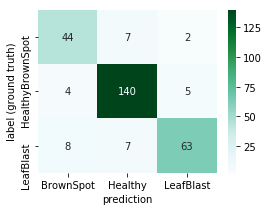

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 576	TRAIN	Loss: 0.75	Correct: 1921/2510(76.53%)
		VALID.:	Loss: 0.35	Correct: 234/280(83.57%)
----------------------------------------


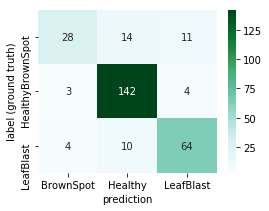

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 577	TRAIN	Loss: 0.64	Correct: 1913/2510(76.22%)
		VALID.:	Loss: 0.46	Correct: 243/280(86.79%)
----------------------------------------


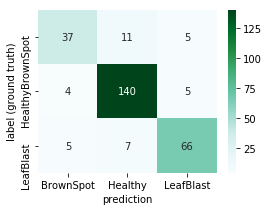

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 578	TRAIN	Loss: 0.35	Correct: 1949/2510(77.65%)
		VALID.:	Loss: 0.62	Correct: 231/280(82.5%)
----------------------------------------


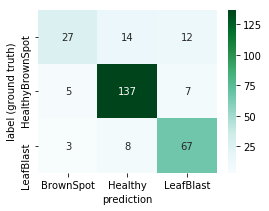

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 579	TRAIN	Loss: 0.69	Correct: 1960/2510(78.09%)
		VALID.:	Loss: 0.45	Correct: 241/280(86.07%)
----------------------------------------


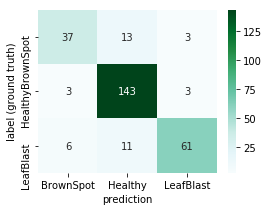

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 580	TRAIN	Loss: 0.51	Correct: 1940/2510(77.29%)
		VALID.:	Loss: 0.5	Correct: 238/280(85.0%)
----------------------------------------


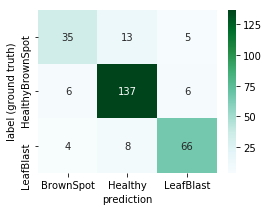

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 581	TRAIN	Loss: 0.62	Correct: 1942/2510(77.37%)
		VALID.:	Loss: 0.4	Correct: 240/280(85.71%)
----------------------------------------


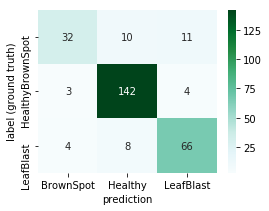

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 582	TRAIN	Loss: 0.46	Correct: 1993/2510(79.4%)
		VALID.:	Loss: 0.33	Correct: 248/280(88.57%)
----------------------------------------


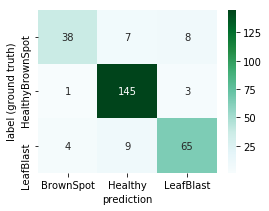

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 583	TRAIN	Loss: 0.63	Correct: 1964/2510(78.25%)
		VALID.:	Loss: 0.53	Correct: 247/280(88.21%)
----------------------------------------


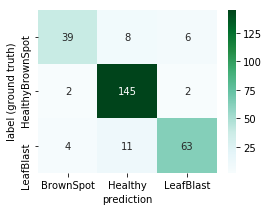

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 584	TRAIN	Loss: 0.28	Correct: 2008/2510(80.0%)
		VALID.:	Loss: 0.27	Correct: 244/280(87.14%)
----------------------------------------


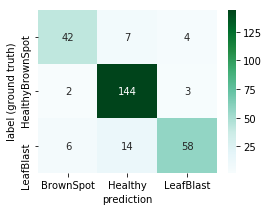

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 585	TRAIN	Loss: 0.26	Correct: 2018/2510(80.4%)
		VALID.:	Loss: 0.47	Correct: 243/280(86.79%)
----------------------------------------


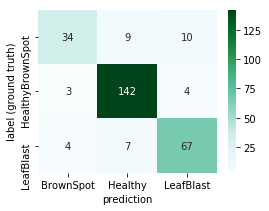

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 586	TRAIN	Loss: 0.5	Correct: 2013/2510(80.2%)
		VALID.:	Loss: 0.45	Correct: 245/280(87.5%)
----------------------------------------


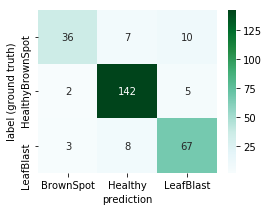

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 587	TRAIN	Loss: 0.7	Correct: 1999/2510(79.64%)
		VALID.:	Loss: 0.42	Correct: 243/280(86.79%)
----------------------------------------


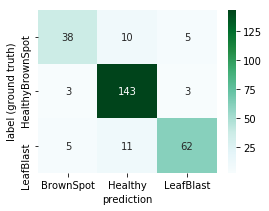

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 588	TRAIN	Loss: 0.5	Correct: 1989/2510(79.24%)
		VALID.:	Loss: 0.47	Correct: 246/280(87.86%)
----------------------------------------


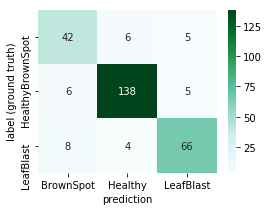

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 589	TRAIN	Loss: 0.43	Correct: 1964/2510(78.25%)
		VALID.:	Loss: 0.38	Correct: 248/280(88.57%)
----------------------------------------


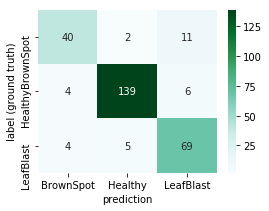

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 590	TRAIN	Loss: 0.99	Correct: 2001/2510(79.72%)
		VALID.:	Loss: 0.29	Correct: 246/280(87.86%)
----------------------------------------


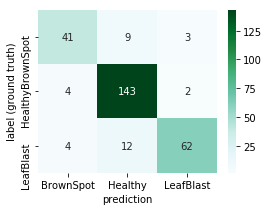

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 591	TRAIN	Loss: 1.29	Correct: 2011/2510(80.12%)
		VALID.:	Loss: 0.41	Correct: 243/280(86.79%)
----------------------------------------


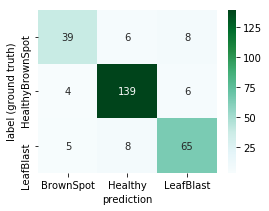

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 592	TRAIN	Loss: 0.38	Correct: 1940/2510(77.29%)
		VALID.:	Loss: 0.44	Correct: 240/280(85.71%)
----------------------------------------


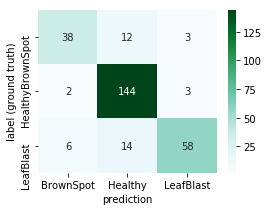

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 593	TRAIN	Loss: 0.51	Correct: 1981/2510(78.92%)
		VALID.:	Loss: 0.47	Correct: 247/280(88.21%)
----------------------------------------


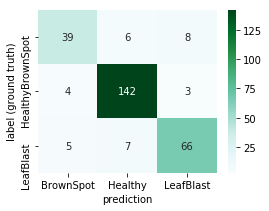

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 594	TRAIN	Loss: 0.41	Correct: 1983/2510(79.0%)
		VALID.:	Loss: 0.44	Correct: 249/280(88.93%)
----------------------------------------


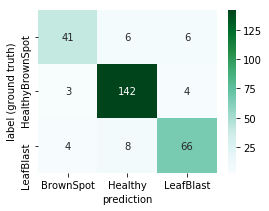

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 595	TRAIN	Loss: 0.94	Correct: 1976/2510(78.73%)
		VALID.:	Loss: 0.44	Correct: 230/280(82.14%)
----------------------------------------


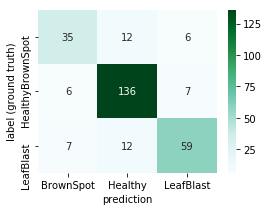

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 596	TRAIN	Loss: 0.63	Correct: 1941/2510(77.33%)
		VALID.:	Loss: 0.53	Correct: 237/280(84.64%)
----------------------------------------


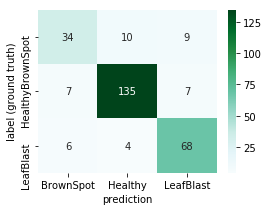

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 597	TRAIN	Loss: 0.35	Correct: 1955/2510(77.89%)
		VALID.:	Loss: 0.5	Correct: 241/280(86.07%)
----------------------------------------


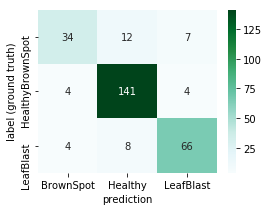

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 598	TRAIN	Loss: 0.95	Correct: 1937/2510(77.17%)
		VALID.:	Loss: 0.43	Correct: 234/280(83.57%)
----------------------------------------


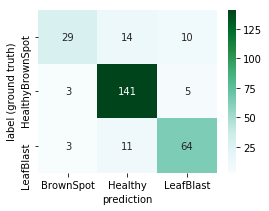

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 599	TRAIN	Loss: 0.36	Correct: 1913/2510(76.22%)
		VALID.:	Loss: 0.43	Correct: 233/280(83.21%)
----------------------------------------


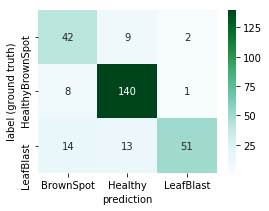

---- batch: 0(251)
---- batch: 100(251)
---- batch: 200(251)
Epoch: 600	TRAIN	Loss: 0.81	Correct: 1981/2510(78.92%)
		VALID.:	Loss: 0.44	Correct: 232/280(82.86%)
----------------------------------------


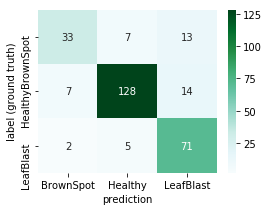

End.
Duration: 47043 seconds


In [22]:
train_losses, valid_losses, train_corrects, valid_corrects = \
    train(model,
          nn.CrossEntropyLoss(),
          torch.optim.Adam(model.parameters(), lr=0.001),
          train_loader, valid_loader, 
          n_epoch=600)

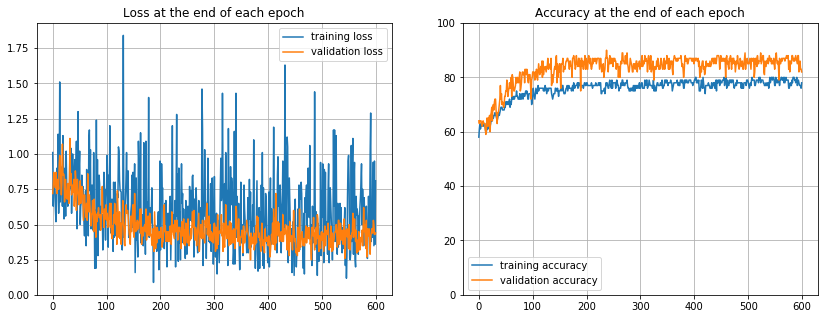

In [23]:
plot_train_results(train_losses, valid_losses, 
                   train_corrects, valid_corrects, 
                   len(train_loader.sampler.indices), len(valid_loader.sampler.indices))

In [68]:
torch.save(model.state_dict(), 'model_naive_6_16_120_84.pt')
pickle.dump(train_losses, open('train_losses_naive_6_16_120_84.pkl', 'wb'))
pickle.dump(valid_losses, open('valid_losses_naive_6_16_120_84.pkl', 'wb'))
pickle.dump(train_corrects, open('train_corrects_naive_6_16_120_84.pkl', 'wb'))
pickle.dump(valid_corrects, open('valid_corrects_naive_6_16_120_84.pkl', 'wb'))

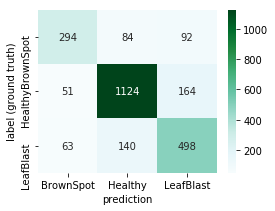

Validation accuracy: 76.33 %


In [63]:
evaluate_model(model, train_loader, DEVICE, 'Training')

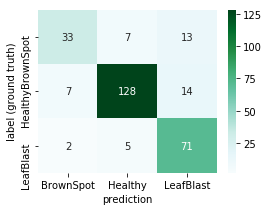

Validation accuracy: 82.86 %


In [62]:
evaluate_model(model, valid_loader, DEVICE, 'Validation')